<a href="https://colab.research.google.com/github/ChiNonsoHenry16/Comparative-Analysis-of-Classical-ML-and-Neural-Network-Models-for-Pig-Weight-Prediction/blob/main/A_Comparative_Analysis_of_Classical_Machine_Learning_and_Neural_Network_Models_for_Pig_Weight_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following are the codes for the paper titled "A Comparative Analysis of Classical Machine Learning and Neural Network Models for Pig Weight Prediction". Note that the notebook also contains some experimentation (which was not reported), but it led to the best values that were reported in the paper.

In [ ]:
!pip install lightgbm catboost xgboost memory_profiler openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.6 MB/s eta 0:00:00


In [ ]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import xgboost as xgb


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from memory_profiler import memory_usage

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import (
    HistGradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, IsolationForest
)
from sklearn.linear_model import (
    TheilSenRegressor, LinearRegression, Lasso, Ridge, ElasticNet
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [ ]:
# LOAD DATA
from google.colab import files
uploaded = files.upload()

import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

Saving dataset.xlsx to dataset.xlsx


In [ ]:
# BASIC CLEANING & FEATURE ENGINEERING

# Rename columns as needed
data.rename(columns={'male/female':'gender'}, inplace=True)

# Parse dates
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

# One-hot encoding for gender & breed
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

# Feature: age in days
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

# Replace 0 height (if any) with the median of non-zero heights
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

# Drop unwanted columns
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

data.head()


Chest circumference of pig  Abdominal circumference of pigs  \
0                         110                              115   
1                         105                              116   
2                         109                              120   
3                         105                              112   
4                         107                              116   

   Waist circumference of pig  Weight measurement  Length of pig  \
0                         107               113.5            120   
1                         106               111.4            119   
2                         104               114.6            125   
3                         100               111.8            123   
4                         106               114.2            118   

   The height of a pig  female   male   S21    S23  age_in_days  
0                   63    True  False  True  False          193  
1                   63    True  False  True  False          192  
2                   63    True  False  True  False          194  
3                   63    True  False  True  False          192  
4                   63    True  False  True  False          189

In [ ]:
# Compute descriptive statistics with variance, rounded to three decimals
print("\nDescriptive Statistics (Min, Max, Mean, Std, Var) (rounded to 3 decimals):")
desc_stats = data.agg(['min', 'max', 'mean', 'std', 'var']).T.round(3) # Use agg to calculate variance
print(desc_stats)


Descriptive Statistics (Min, Max, Mean, Std, Var) (rounded to 3 decimals):
                                   min    max        mean       std        var
Chest circumference of pig        93.0  129.0  106.643186  3.214395  10.332337
Abdominal circumference of pigs  100.0  133.0  116.269639  3.619371   13.09985
Waist circumference of pig        90.0  124.0  104.297695  3.331089  11.096157
Weight measurement                90.1  155.6  110.593016   7.05241  49.736481
Length of pig                     99.0  136.0  120.129559  2.749768   7.561227
The height of a pig               55.0   72.0   63.138878  1.608286   2.586583
female                           False   True     0.54489  0.498006    0.24801
male                             False   True     0.45511  0.498006    0.24801
S21                              False   True    0.808417  0.393566   0.154895
S23                              False   True    0.191583  0.393566   0.154895
age_in_days                      149.0  220.0  174.7823

In [ ]:
# OUTLIER REMOVAL (on ONLY 4 FEATURES)
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

# SELECT ONLY THOSE COLUMNS FOR X
X = data[main_features]
y = data['Weight measurement']

In [ ]:
# NORMALIZATION

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
# TRAIN-TEST SPLIT

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# HYPERPARAMETER TUNING: HistGradientBoostingRegressor

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [10, 20, 30],
}

hist = HistGradientBoostingRegressor(random_state=42)
hist_search = RandomizedSearchCV(hist, param_dist, n_iter=15, cv=5, scoring='r2', random_state=42)
hist_search.fit(X_train, y_train)

print("\nBest HistGB params:", hist_search.best_params_)
print("Best cross-validated R2 (HistGB):", hist_search.best_score_)
print("Validation R2 (HistGB):", hist_search.score(X_val, y_val))



Best HistGB params: {'min_samples_leaf': 10, 'max_iter': 300, 'max_depth': 3, 'learning_rate': 0.1}
Best cross-validated R2 (HistGB): 0.5700436428317845
Validation R2 (HistGB): 0.5792162317765859


In [ ]:
# XGBoost (Optional additional model)

xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 1.0]
}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
xgb_search = RandomizedSearchCV(xg_reg, xgb_param_dist, n_iter=15, cv=5, scoring='r2', random_state=42)
xgb_search.fit(X_train, y_train)

print("\nBest XGBoost params:", xgb_search.best_params_)
print("Best cross-validated R2 (XGB):", xgb_search.best_score_)
print("Validation R2 (XGB):", xgb_search.score(X_val, y_val))


Best XGBoost params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}
Best cross-validated R2 (XGB): 0.5665669836588078
Validation R2 (XGB): 0.5775606293352571


In [ ]:
# METRICS FOR BEST MODEL ON VALIDATION SET

def print_model_metrics(model, X_train, y_train, X_val, y_val, name=''):
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_val)
    print(f"\n{name} Train R2: {r2_score(y_train, y_pred_train):.3f}")
    print(f"{name} Val R2: {r2_score(y_val, y_pred):.3f}")
    print(f"{name} Val MAE: {mean_absolute_error(y_val, y_pred):.3f}")
    print(f"{name} Val RMSE: {np.sqrt(mean_squared_error(y_val, y_pred)):.3f}")

print_model_metrics(hist_search.best_estimator_, X_train, y_train, X_val, y_val, name='HistGB')
print_model_metrics(xgb_search.best_estimator_, X_train, y_train, X_val, y_val, name='XGBoost')



HistGB Train R2: 0.609
HistGB Val R2: 0.579
HistGB Val MAE: 3.337
HistGB Val RMSE: 4.286

XGBoost Train R2: 0.617
XGBoost Val R2: 0.578
XGBoost Val MAE: 3.341
XGBoost Val RMSE: 4.295


Does not include all the models and the parameters for time and memory performance.

In [ ]:
# MODEL SETUP

results = {}

# Helper to store and print
def get_metrics(model, X_train, y_train, X_val, y_val, name):
    y_pred = model.predict(X_val)
    y_train_pred = model.predict(X_train)
    res = {
        "Train R2": r2_score(y_train, y_train_pred),
        "Val R2": r2_score(y_val, y_pred),
        "Val MAE": mean_absolute_error(y_val, y_pred),
        "Val RMSE": np.sqrt(mean_squared_error(y_val, y_pred)),
        "Model": model
    }
    print(f"\n{name}:")
    for k, v in res.items():
        if k != "Model":
            print(f"{k}: {v:.4f}")
    results[name] = res

# HistGradientBoostingRegressor
hist_reg = HistGradientBoostingRegressor(
    learning_rate=0.1, max_iter=200, max_depth=5, min_samples_leaf=20, random_state=42
)
hist_reg.fit(X_train, y_train)
get_metrics(hist_reg, X_train, y_train, X_val, y_val, "HistGradientBoosting")

#  XGBRegressor
xgb_reg = XGBRegressor(
    objective='reg:squarederror', random_state=42,
    n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8
)
xgb_reg.fit(X_train, y_train)
get_metrics(xgb_reg, X_train, y_train, X_val, y_val, "XGBRegressor")

# LGBMRegressor (with some tuning)
lgbm_reg = LGBMRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, random_state=42
)
lgbm_reg.fit(X_train, y_train)
get_metrics(lgbm_reg, X_train, y_train, X_val, y_val, "LGBMRegressor")

# CatBoostRegressor (with some tuning)
catboost_reg = CatBoostRegressor(
    iterations=200, learning_rate=0.1, depth=5, subsample=0.8, random_seed=42, verbose=0
)
catboost_reg.fit(X_train, y_train)
get_metrics(catboost_reg, X_train, y_train, X_val, y_val, "CatBoostRegressor")

# AdaBoostRegressor
ada_reg = AdaBoostRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
ada_reg.fit(X_train, y_train)
get_metrics(ada_reg, X_train, y_train, X_val, y_val, "AdaBoostRegressor")

# TheilSen Regressor
ts_reg = TheilSenRegressor(random_state=42, max_iter=100)
ts_reg.fit(X_train, y_train)
get_metrics(ts_reg, X_train, y_train, X_val, y_val, "TheilSenRegressor")



HistGradientBoosting:
Train R2: 0.6215
Val R2: 0.5765
Val MAE: 3.3471
Val RMSE: 4.3004

XGBRegressor:
Train R2: 0.6544
Val R2: 0.5652
Val MAE: 3.3856
Val RMSE: 4.3573
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 4
[LightGBM] [Info] Start training from score 110.261799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

ADDING GRIDSERCH

Best Params HistGradientBoosting:  {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 200, 'min_samples_leaf': 10}

HistGradientBoosting:
Train R2: 0.6031
Val R2: 0.5811
Val MAE: 3.3323
Val RMSE: 4.2769
Best Params XGBRegressor:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

XGBRegressor:
Train R2: 0.5947
Val R2: 0.5820
Val MAE: 3.3272
Val RMSE: 4.2725
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 4
[LightGBM] [Info] Start training from score 110.261799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

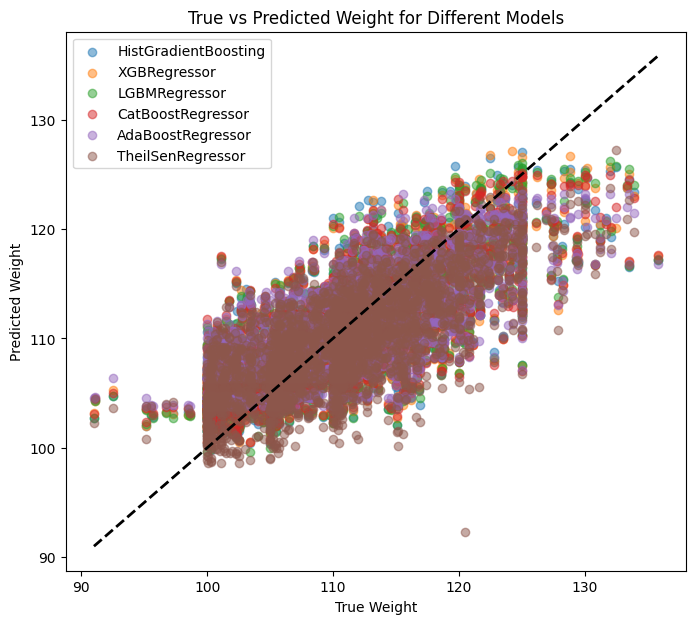

Train R2    Val R2   Val MAE  Val RMSE
HistGradientBoosting  0.603096  0.581093  3.332311  4.276910
XGBRegressor          0.594716  0.581966  3.327208  4.272453
LGBMRegressor         0.599463  0.583716  3.320817  4.263501
CatBoostRegressor     0.592830  0.583128  3.319643  4.266508
AdaBoostRegressor     0.547622  0.548944  3.485939  4.437990
TheilSenRegressor     0.529610  0.528416  3.498776  4.537859

In [ ]:
results = {}

# Helper function to store and print
def get_metrics(model, X_train, y_train, X_val, y_val, name):
    y_pred = model.predict(X_val)
    y_train_pred = model.predict(X_train)
    res = {
        "Train R2": r2_score(y_train, y_train_pred),
        "Val R2": r2_score(y_val, y_pred),
        "Val MAE": mean_absolute_error(y_val, y_pred),
        "Val RMSE": np.sqrt(mean_squared_error(y_val, y_pred)),
        "Model": model
    }
    print(f"\n{name}:")
    for k, v in res.items():
        if k != "Model":
            print(f"{k}: {v:.4f}")
    results[name] = res

# HistGradientBoostingRegressor with GridSearchCV

hist_params = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [3, 5],
    'min_samples_leaf': [10, 20]
}
histgrid = GridSearchCV(HistGradientBoostingRegressor(random_state=42),
                        param_grid=hist_params, cv=3, n_jobs=-1, scoring='r2')
histgrid.fit(X_train, y_train)
print("Best Params HistGradientBoosting: ", histgrid.best_params_)
get_metrics(histgrid.best_estimator_, X_train, y_train, X_val, y_val, "HistGradientBoosting")

# XGBRegressor with GridSearchCV

xgb_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}
xgbgrid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
                       param_grid=xgb_params, cv=3, n_jobs=-1, scoring='r2')
xgbgrid.fit(X_train, y_train)
print("Best Params XGBRegressor: ", xgbgrid.best_params_)
get_metrics(xgbgrid.best_estimator_, X_train, y_train, X_val, y_val, "XGBRegressor")

# LGBMRegressor with GridSearchCV

lgbm_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}
lgbmgrid = GridSearchCV(LGBMRegressor(random_state=42),
                        param_grid=lgbm_params, cv=3, n_jobs=-1, scoring='r2')
lgbmgrid.fit(X_train, y_train)
print("Best Params LGBMRegressor: ", lgbmgrid.best_params_)
get_metrics(lgbmgrid.best_estimator_, X_train, y_train, X_val, y_val, "LGBMRegressor")

# CatBoostRegressor with GridSearchCV

cat_params = {
    'learning_rate': [0.05, 0.1],
    'depth': [3, 5],
    'iterations': [100, 200],
    'subsample': [0.8, 1.0]
}
catgrid = GridSearchCV(CatBoostRegressor(verbose=0, random_seed=42),
                       param_grid=cat_params, cv=3, n_jobs=-1, scoring='r2')
catgrid.fit(X_train, y_train)
print("Best Params CatBoostRegressor: ", catgrid.best_params_)
get_metrics(catgrid.best_estimator_, X_train, y_train, X_val, y_val, "CatBoostRegressor")

# AdaBoostRegressor with GridSearchCV

ada_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}
adagird = GridSearchCV(AdaBoostRegressor(random_state=42),
                       param_grid=ada_params, cv=3, n_jobs=-1, scoring='r2')
adagird.fit(X_train, y_train)
print("Best Params AdaBoostRegressor: ", adagird.best_params_)
get_metrics(adagird.best_estimator_, X_train, y_train, X_val, y_val, "AdaBoostRegressor")

# TheilSenRegressor

ts_reg = TheilSenRegressor(random_state=42, max_iter=100)
ts_reg.fit(X_train, y_train)
get_metrics(ts_reg, X_train, y_train, X_val, y_val, "TheilSenRegressor")

# PLOT PREDICTIONS

plt.figure(figsize=(8,7))
for name, res in results.items():
    model = res["Model"]
    y_pred = model.predict(X_val)
    plt.scatter(y_val, y_pred, label=name, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("True Weight")
plt.ylabel("Predicted Weight")
plt.legend()
plt.title("True vs Predicted Weight for Different Models")
plt.show()

# PRINT SUMMARY TABLE
summary = pd.DataFrame.from_dict(
    {name: {k: v for k, v in res.items() if k != "Model"} for name, res in results.items()},
    orient='index'
)
display(summary)

In [ ]:
results = {}

# METRICS FUNCTION
def get_all_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def get_metrics(model, X_train, y_train, X_val, y_val, name):
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_metrics = get_all_metrics(y_train, train_pred)
    val_metrics = get_all_metrics(y_val, val_pred)
    results[name] = {
        'Train R2': train_metrics['R2'],
        'Train MAE': train_metrics['MAE'],
        'Train RMSE': train_metrics['RMSE'],
        'Train MAPE': train_metrics['MAPE'],
        'Test R2': val_metrics['R2'],
        'Test MAE': val_metrics['MAE'],
        'Test RMSE': val_metrics['RMSE'],
        'Test MAPE': val_metrics['MAPE'],
        "Model": model
    }
    print(f"\n{name}:")
    print("  Train: R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        train_metrics['R2'], train_metrics['RMSE'],
        train_metrics['MAE'], train_metrics['MAPE']))
    print("  Test : R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        val_metrics['R2'], val_metrics['RMSE'],
        val_metrics['MAE'], val_metrics['MAPE']))

# HistGradientBoostingRegressor with GridSearchCV

hist_params = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [3, 5],
    'min_samples_leaf': [10, 20]
}
histgrid = GridSearchCV(HistGradientBoostingRegressor(random_state=42),
                        param_grid=hist_params, cv=3, n_jobs=-1, scoring='r2')
histgrid.fit(X_train, y_train)
print("\nBest Params HistGradientBoosting:", histgrid.best_params_)
get_metrics(histgrid.best_estimator_, X_train, y_train, X_val, y_val, "HistGradientBoosting")

# XGBRegressor with GridSearchCV

xgb_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}
xgbgrid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
                       param_grid=xgb_params, cv=3, n_jobs=-1, scoring='r2')
xgbgrid.fit(X_train, y_train)
print("\nBest Params XGBRegressor:", xgbgrid.best_params_)
get_metrics(xgbgrid.best_estimator_, X_train, y_train, X_val, y_val, "XGBRegressor")

# LGBMRegressor with GridSearchCV

lgbm_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}
lgbmgrid = GridSearchCV(LGBMRegressor(random_state=42),
                        param_grid=lgbm_params, cv=3, n_jobs=-1, scoring='r2')
lgbmgrid.fit(X_train, y_train)
print("\nBest Params LGBMRegressor:", lgbmgrid.best_params_)
get_metrics(lgbmgrid.best_estimator_, X_train, y_train, X_val, y_val, "LGBMRegressor")

# CatBoostRegressor with GridSearchCV

cat_params = {
    'learning_rate': [0.05, 0.1],
    'depth': [3, 5],
    'iterations': [100, 200],
    'subsample': [0.8, 1.0]
}
catgrid = GridSearchCV(CatBoostRegressor(verbose=0, random_seed=42),
                       param_grid=cat_params, cv=3, n_jobs=-1, scoring='r2')
catgrid.fit(X_train, y_train)
print("\nBest Params CatBoostRegressor:", catgrid.best_params_)
get_metrics(catgrid.best_estimator_, X_train, y_train, X_val, y_val, "CatBoostRegressor")

# AdaBoostRegressor with GridSearchCV

ada_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}
adagird = GridSearchCV(AdaBoostRegressor(random_state=42),
                       param_grid=ada_params, cv=3, n_jobs=-1, scoring='r2')
adagird.fit(X_train, y_train)
print("\nBest Params AdaBoostRegressor:", adagird.best_params_)
get_metrics(adagird.best_estimator_, X_train, y_train, X_val, y_val, "AdaBoostRegressor")

# TheilSenRegressor (no grid search)

ts_reg = TheilSenRegressor(random_state=42, max_iter=100)
ts_reg.fit(X_train, y_train)
get_metrics(ts_reg, X_train, y_train, X_val, y_val, "TheilSenRegressor")

# SUMMARY TABLE
summary_rows = []
for name, res in results.items():
    row = res.copy()
    row['ModelName'] = name
    summary_rows


Best Params HistGradientBoosting: {'learning_rate': 0.05, 'max_depth': 5, 'max_iter': 200, 'min_samples_leaf': 20}

HistGradientBoosting:
  Train: R2=0.7388 RMSE=3.3811 MAE=2.5851 MAPE=0.02%
  Test : R2=0.6902 RMSE=3.6137 MAE=2.7554 MAPE=0.02%

Best Params XGBRegressor: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

XGBRegressor:
  Train: R2=0.7345 RMSE=3.4090 MAE=2.6138 MAPE=0.02%
  Test : R2=0.6900 RMSE=3.6147 MAE=2.7570 MAPE=0.02%
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 10
[LightGBM] [Info] Start training from score 110.470374
[LightGBM] [Warning] No further splits wit


HistGradientBoosting:
  Train: R2=0.7388 RMSE=3.3811 MAE=2.5851 MAPE=0.02%
  Test : R2=0.6902 RMSE=3.6137 MAE=2.7554 MAPE=0.02%

XGBRegressor:
  Train: R2=0.7345 RMSE=3.4090 MAE=2.6138 MAPE=0.02%
  Test : R2=0.6900 RMSE=3.6147 MAE=2.7570 MAPE=0.02%
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 10
[LightGBM] [Info] Start training from score 110.470374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



MLPRegressor:
  Train: R2=0.6320 RMSE=4.0130 MAE=3.1060 MAPE=0.03%
  Test : R2=0.6346 RMSE=3.9245 MAE=3.0320 MAPE=0.03%

SVR:
  Train: R2=0.6695 RMSE=3.8032 MAE=2.8724 MAPE=0.03%
  Test : R2=0.6653 RMSE=3.7561 MAE=2.8529 MAPE=0.03%

KNN:
  Train: R2=0.9971 RMSE=0.3533 MAE=0.0386 MAPE=0.00%
  Test : R2=0.6505 RMSE=3.8378 MAE=2.8849 MAPE=0.03%

LinearRegression:
  Train: R2=0.6268 RMSE=4.0416 MAE=3.1345 MAPE=0.03%
  Test : R2=0.6304 RMSE=3.9466 MAE=3.0562 MAPE=0.03%

Lasso:
  Train: R2=0.6248 RMSE=4.0523 MAE=3.1417 MAPE=0.03%
  Test : R2=0.6276 RMSE=3.9617 MAE=3.0648 MAPE=0.03%

Ridge:
  Train: R2=0.6266 RMSE=4.0427 MAE=3.1349 MAPE=0.03%
  Test : R2=0.6298 RMSE=3.9502 MAE=3.0588 MAPE=0.03%

ElasticNet:
  Train: R2=0.5887 RMSE=4.2427 MAE=3.2624 MAPE=0.03%
  Test : R2=0.5821 RMSE=4.1966 MAE=3.2308 MAPE=0.03%

TheilSenRegressor:
  Train: R2=0.5543 RMSE=4.4166 MAE=3.4318 MAPE=0.03%
  Test : R2=0.5439 RMSE=4.3845 MAE=3.3969 MAPE=0.03%

--- Summary Table (Main Metrics) ---


ModelName  Train R2  Train RMSE  Train MAE  Train MAPE  \
0   HistGradientBoosting  0.738802    3.381138   2.585082    0.023268   
1           XGBRegressor  0.734473    3.409042   2.613756    0.023540   
2          LGBMRegressor  0.738802    3.381138   2.585081    0.023268   
3      CatBoostRegressor  0.725618    3.465419   2.648688    0.023856   
4      AdaBoostRegressor  0.602711    4.169950   3.239525    0.029416   
5           RandomForest  0.952704    1.438762   1.062387    0.009537   
6           DecisionTree  0.621947    4.067751   3.133443    0.028252   
7           MLPRegressor  0.632048    4.013038   3.105990    0.028027   
8                    SVR  0.669518    3.803220   2.872446    0.025817   
9                    KNN  0.997148    0.353306   0.038613    0.000349   
10      LinearRegression  0.626788    4.041619   3.134490    0.028276   
11                 Lasso  0.624819    4.052266   3.141663    0.028335   
12                 Ridge  0.626582    4.042734   3.134855    0.028277   
13            ElasticNet  0.588734    4.242669   3.262421    0.029380   
14     TheilSenRegressor  0.554329    4.416566   3.431825    0.030957   

     Test R2  Test RMSE  Test MAE  Test MAPE  
0   0.690160   3.613703  2.755419   0.024747  
1   0.689993   3.614679  2.756954   0.024771  
2   0.690149   3.613767  2.755552   0.024748  
3   0.690988   3.608875  2.743738   0.024653  
4   0.593876   4.137261  3.212636   0.029145  
5   0.669051   3.734774  2.848003   0.025571  
6   0.588004   4.167068  3.189709   0.028710  
7   0.634579   3.924465  3.032018   0.027363  
8   0.665261   3.756098  2.852889   0.025630  
9   0.650540   3.837801  2.884876   0.025829  
10  0.630437   3.946645  3.056165   0.027570  
11  0.627615   3.961683  3.064832   0.027648  
12  0.629777   3.950165  3.058782   0.027591  
13  0.582135   4.196639  3.230776   0.029092  
14  0.543878   4.384545  3.396864   0.030639

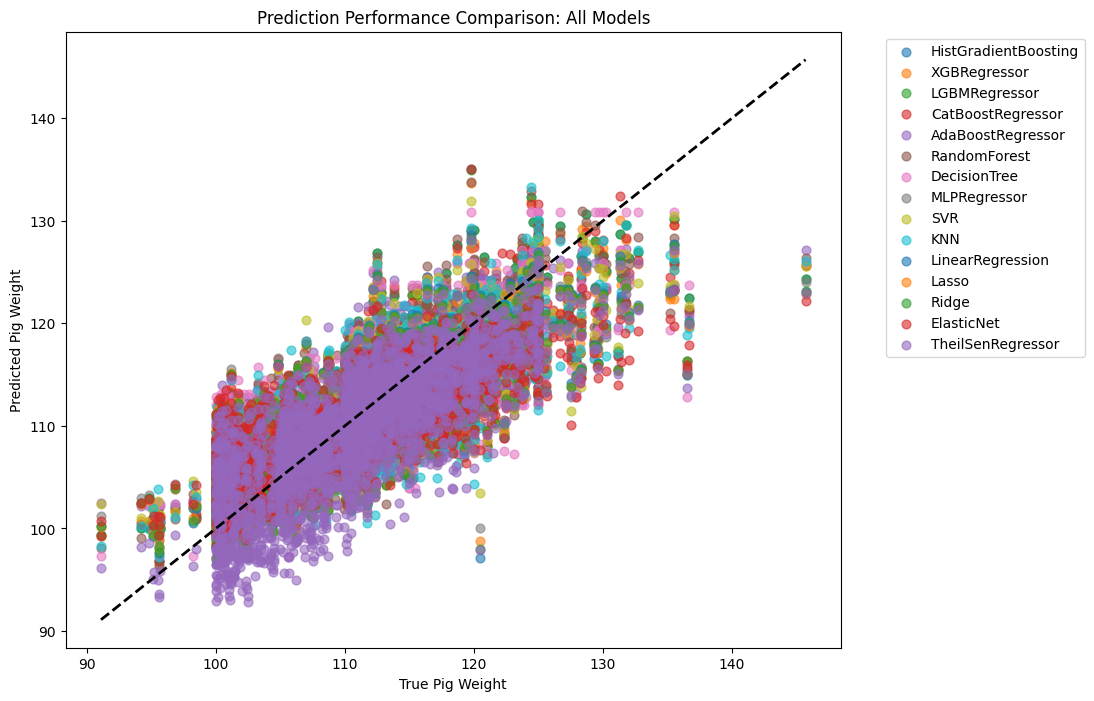

from matplotlib import pyplot as plt
summary_df['Train R2'].plot(kind='hist', bins=20, title='Train R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Train RMSE'].plot(kind='hist', bins=20, title='Train RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Train MAE'].plot(kind='hist', bins=20, title='Train MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Train MAPE'].plot(kind='hist', bins=20, title='Train MAPE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df.plot(kind='scatter', x='Train R2', y='Train RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df.plot(kind='scatter', x='Train RMSE', y='Train MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df.plot(kind='scatter', x='Train MAE', y='Train MAPE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df.plot(kind='scatter', x='Train MAPE', y='Test R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Train R2'].plot(kind='line', figsize=(8, 4), title='Train R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Train RMSE'].plot(kind='line', figsize=(8, 4), title='Train RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Train MAE'].plot(kind='line', figsize=(8, 4), title='Train MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Train MAPE'].plot(kind='line', figsize=(8, 4), title='Train MAPE')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
results = {}

# METRICS FUNCTION

def get_all_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def get_metrics(model, X_train, y_train, X_val, y_val, name):
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_metrics = get_all_metrics(y_train, train_pred)
    val_metrics = get_all_metrics(y_val, val_pred)
    results[name] = {
        'Train R2': train_metrics['R2'],
        'Train MAE': train_metrics['MAE'],
        'Train RMSE': train_metrics['RMSE'],
        'Train MAPE': train_metrics['MAPE'],
        'Test R2': val_metrics['R2'],
        'Test MAE': val_metrics['MAE'],
        'Test RMSE': val_metrics['RMSE'],
        'Test MAPE': val_metrics['MAPE'],
        "Model": model,
        "Val Prediction": val_pred # for plotting
    }
    print(f"\n{name}:")
    print("  Train: R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        train_metrics['R2'], train_metrics['RMSE'],
        train_metrics['MAE'], train_metrics['MAPE']))
    print("  Test : R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        val_metrics['R2'], val_metrics['RMSE'],
        val_metrics['MAE'], val_metrics['MAPE']))

# TREE/GRADIENT/ENSEMBLE MODELS WITH GRIDSEARCH
# HistGradientBoostingRegressor
hist_params = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [3, 5],
    'min_samples_leaf': [10, 20]
}
histgrid = GridSearchCV(HistGradientBoostingRegressor(random_state=42),
                        param_grid=hist_params, cv=3, n_jobs=-1, scoring='r2')
histgrid.fit(X_train, y_train)
get_metrics(histgrid.best_estimator_, X_train, y_train, X_val, y_val, "HistGradientBoosting")

# XGBRegressor
xgb_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}
xgbgrid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
                       param_grid=xgb_params, cv=3, n_jobs=-1, scoring='r2')
xgbgrid.fit(X_train, y_train)
get_metrics(xgbgrid.best_estimator_, X_train, y_train, X_val, y_val, "XGBRegressor")

# LightGBM
lgbm_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}
lgbmgrid = GridSearchCV(LGBMRegressor(random_state=42),
                        param_grid=lgbm_params, cv=3, n_jobs=-1, scoring='r2')
lgbmgrid.fit(X_train, y_train)
get_metrics(lgbmgrid.best_estimator_, X_train, y_train, X_val, y_val, "LGBMRegressor")

# (iv) CatBoostRegressor
cat_params = {
    'learning_rate': [0.05, 0.1],
    'depth': [3, 5],
    'iterations': [100, 200],
    'subsample': [0.8, 1.0]
}
catgrid = GridSearchCV(CatBoostRegressor(verbose=0, random_seed=42),
                       param_grid=cat_params, cv=3, n_jobs=-1, scoring='r2')
catgrid.fit(X_train, y_train)
get_metrics(catgrid.best_estimator_, X_train, y_train, X_val, y_val, "CatBoostRegressor")

# AdaBoostRegressor
ada_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}
adagird = GridSearchCV(AdaBoostRegressor(random_state=42),
                       param_grid=ada_params, cv=3, n_jobs=-1, scoring='r2')
adagird.fit(X_train, y_train)
get_metrics(adagird.best_estimator_, X_train, y_train, X_val, y_val, "AdaBoostRegressor")

# Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, None]
}
rfgrid = GridSearchCV(RandomForestRegressor(random_state=42),
                      param_grid=rf_params, cv=3, n_jobs=-1, scoring='r2')
rfgrid.fit(X_train, y_train)
get_metrics(rfgrid.best_estimator_, X_train, y_train, X_val, y_val, "RandomForest")

# Decision Tree
dt_params = {
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5],
}
dtgrid = GridSearchCV(DecisionTreeRegressor(random_state=42),
                      param_grid=dt_params, cv=3, n_jobs=-1, scoring='r2')
dtgrid.fit(X_train, y_train)
get_metrics(dtgrid.best_estimator_, X_train, y_train, X_val, y_val, "DecisionTree")

# ultilayer Perceptron
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'max_iter': [300],
}
mlpgrid = GridSearchCV(MLPRegressor(random_state=42),
                      param_grid=mlp_params, cv=3, n_jobs=-1, scoring='r2')
mlpgrid.fit(X_train, y_train)
get_metrics(mlpgrid.best_estimator_, X_train, y_train, X_val, y_val, "MLPRegressor")

# Support Vector Regressor
svr_params = {
    'C': [1, 10],
    'kernel': ['rbf', 'linear'],
}
svrgrid = GridSearchCV(SVR(),
                      param_grid=svr_params, cv=3, n_jobs=-1, scoring='r2')
svrgrid.fit(X_train, y_train)
get_metrics(svrgrid.best_estimator_, X_train, y_train, X_val, y_val, "SVR")

# K-Nearest Neighbors
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
}
knngrid = GridSearchCV(KNeighborsRegressor(),
                       param_grid=knn_params, cv=3, n_jobs=-1, scoring='r2')
knngrid.fit(X_train, y_train)
get_metrics(knngrid.best_estimator_, X_train, y_train, X_val, y_val, "KNN")

# LINEAR/REGULARIZED LINEAR MODELS
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
get_metrics(lr, X_train, y_train, X_val, y_val, "LinearRegression")

# Lasso Regression
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
lasso.fit(X_train, y_train)
get_metrics(lasso, X_train, y_train, X_val, y_val, "Lasso")

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
get_metrics(ridge, X_train, y_train, X_val, y_val, "Ridge")

# ElasticNet
enet = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42)
enet.fit(X_train, y_train)
get_metrics(enet, X_train, y_train, X_val, y_val, "ElasticNet")

# TheilSenRegressor (robust)
ts_reg = TheilSenRegressor(random_state=42, max_iter=100)
ts_reg.fit(X_train, y_train)
get_metrics(ts_reg, X_train, y_train, X_val, y_val, "TheilSenRegressor")

# SUMMARY TABLE

summary_rows = []
for name, res in results.items():
    row = res.copy()
    row['ModelName'] = name
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
order = [
    'ModelName',
    'Train R2', 'Train RMSE', 'Train MAE', 'Train MAPE',
    'Test R2', 'Test RMSE', 'Test MAE', 'Test MAPE'
]
print("\n--- Summary Table (Main Metrics) ---")
summary_df = summary_df[order]
display(summary_df)

# DIAGRAM: SCATTERPLOT OF MODEL PREDICTIONS

plt.figure(figsize=(10,8))
for name, res in results.items():
    plt.scatter(y_val, res["Val Prediction"], label=name, alpha=0.6, s=40)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("True Pig Weight")
plt.ylabel("Predicted Pig Weight")
plt.title("Prediction Performance Comparison: All Models")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), ncol=1)
plt.show()

This is for 70:30 Split


HistGradientBoosting:
  Train: R2=0.6083 RMSE=4.0743 MAE=3.2031 MAPE=2.91%
  Test : R2=0.5790 RMSE=4.2874 MAE=3.3362 MAPE=3.01%
  Train Time: 0.640s | Peak Mem: 1012.81MB

GradientBoostingRegressor:
  Train: R2=0.6322 RMSE=3.9485 MAE=3.0925 MAPE=2.81%
  Test : R2=0.5735 RMSE=4.3153 MAE=3.3506 MAPE=3.02%
  Train Time: 1.317s | Peak Mem: 1012.81MB

XGBRegressor:
  Train: R2=0.6329 RMSE=3.9442 MAE=3.0971 MAPE=2.81%
  Test : R2=0.5745 RMSE=4.3102 MAE=3.3532 MAPE=3.02%
  Train Time: 0.304s | Peak Mem: 1012.81MB
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 4
[LightGBM] [Info] Start training from score 110.261799
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



SVR:
  Train: R2=0.5801 RMSE=4.2185 MAE=3.2836 MAPE=2.97%
  Test : R2=0.5776 RMSE=4.2948 MAE=3.3365 MAPE=3.01%
  Train Time: 8.084s | Peak Mem: 1013.37MB

KNN:
  Train: R2=0.6325 RMSE=3.9468 MAE=3.0986 MAPE=2.81%
  Test : R2=0.5003 RMSE=4.6713 MAE=3.6366 MAPE=3.28%
  Train Time: 0.092s | Peak Mem: 1013.36MB

LinearRegression:
  Train: R2=0.5400 RMSE=4.4155 MAE=3.4716 MAPE=3.15%
  Test : R2=0.5486 RMSE=4.4395 MAE=3.4507 MAPE=3.11%
  Train Time: 0.009s | Peak Mem: 1013.36MB

Lasso:
  Train: R2=0.5396 RMSE=4.4174 MAE=3.4744 MAPE=3.15%
  Test : R2=0.5471 RMSE=4.4471 MAE=3.4596 MAPE=3.12%
  Train Time: 0.010s | Peak Mem: 1013.36MB

Ridge:
  Train: R2=0.5399 RMSE=4.4162 MAE=3.4714 MAPE=3.15%
  Test : R2=0.5483 RMSE=4.4411 MAE=3.4527 MAPE=3.11%
  Train Time: 0.009s | Peak Mem: 1013.36MB

ElasticNet:
  Train: R2=0.5030 RMSE=4.5898 MAE=3.6101 MAPE=3.27%
  Test : R2=0.5046 RMSE=4.6510 MAE=3.6357 MAPE=3.28%
  Train Time: 0.009s | Peak Mem: 1013.36MB

TheilSenRegressor:
  Train: R2=0.5296 RMSE=4.

<ipython-input-25-7d2412d37dc1>:161: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))


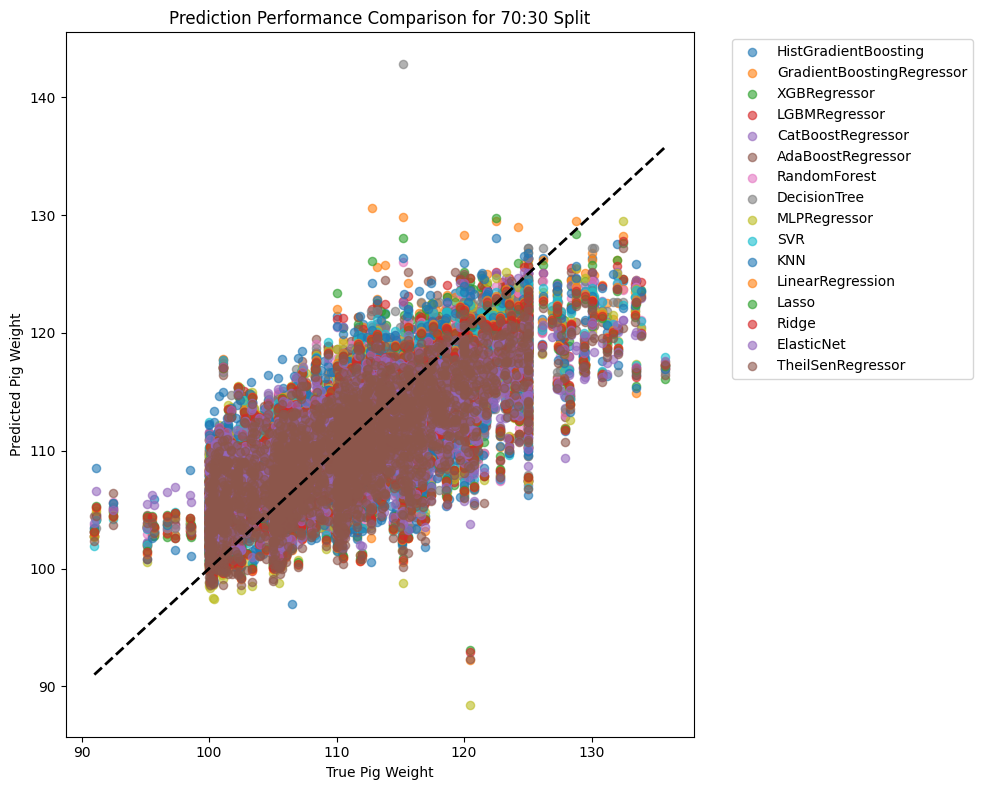

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

#  METRICS

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-7, np.inf))) * 100

def get_all_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def train_and_profile(model, X_train, y_train):
    """
    Trains a model, measuring time and memory.
    Returns trained model, training time (sec), and peak memory usage (MB).
    """
    train_time, mem_peak = None, None
    def fit_model():
        nonlocal train_time
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        return model
    mem_usage = memory_usage(fit_model, max_usage=True, retval=True)
    mem_peak = mem_usage[0]  # MB
    return model, train_time, mem_peak

def get_metrics_with_resource(model, X_train, y_train, X_val, y_val, name, resource_dict):
    model, train_time, mem_peak = train_and_profile(model, X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_metrics = get_all_metrics(y_train, train_pred)
    val_metrics = get_all_metrics(y_val, val_pred)
    results[name] = {
        'Train R2': train_metrics['R2'],
        'Train MAE': train_metrics['MAE'],
        'Train RMSE': train_metrics['RMSE'],
        'Train MAPE': train_metrics['MAPE'],
        'Test R2': val_metrics['R2'],
        'Test MAE': val_metrics['MAE'],
        'Test RMSE': val_metrics['RMSE'],
        'Test MAPE': val_metrics['MAPE'],
        'Model': model,
        'Val Prediction': val_pred,
        'Train Time (sec)': train_time,
        'Peak Mem (MB)': mem_peak,
    }
    resource_dict[name] = {"Train Time (sec)": train_time, "Peak Mem (MB)": mem_peak}
    print(f"\n{name}:")
    print("  Train: R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        train_metrics['R2'], train_metrics['RMSE'], train_metrics['MAE'], train_metrics['MAPE']))
    print("  Test : R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        val_metrics['R2'], val_metrics['RMSE'], val_metrics['MAE'], val_metrics['MAPE']))
    print(f"  Train Time: {train_time:.3f}s | Peak Mem: {mem_peak:.2f}MB")

results = {}
resource_dict = {}

# ML MODELS
# HistGradientBoosting
hist_params = {'learning_rate': [0.05], 'max_iter': [100], 'max_depth': [5], 'min_samples_leaf': [10]}
histgrid = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid=hist_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(histgrid, X_train, y_train, X_val, y_val, "HistGradientBoosting", resource_dict)

# Gradient Boosting Regressor (Classic) with a simple parameter grid
gbr_params = {'learning_rate': [0.1], 'n_estimators': [100], 'max_depth': [5]}
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=gbr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(gbr_grid, X_train, y_train, X_val, y_val, "GradientBoostingRegressor", resource_dict)

# XGBoost
xgb_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
xgbgrid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1), param_grid=xgb_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(xgbgrid, X_train, y_train, X_val, y_val, "XGBRegressor", resource_dict)

# LGBM
lgbm_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
lgbmgrid = GridSearchCV(LGBMRegressor(random_state=42), param_grid=lgbm_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(lgbmgrid, X_train, y_train, X_val, y_val, "LGBMRegressor", resource_dict)

# CatBoost
cat_params = {'learning_rate': [0.1], 'depth': [5], 'iterations': [100], 'subsample': [0.8]}
catgrid = GridSearchCV(CatBoostRegressor(verbose=0, random_seed=42), param_grid=cat_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(catgrid, X_train, y_train, X_val, y_val, "CatBoostRegressor", resource_dict)

# AdaBoost
ada_params = {'learning_rate': [0.1], 'n_estimators': [100]}
adagird = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid=ada_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(adagird, X_train, y_train, X_val, y_val, "AdaBoostRegressor", resource_dict)

# Random Forest
rf_params = {'n_estimators': [100], 'max_depth': [5]}
rfgrid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(rfgrid, X_train, y_train, X_val, y_val, "RandomForest", resource_dict)

# Decision Tree
dt_params = {'max_depth': [5], 'min_samples_split': [2]}
dtgrid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid=dt_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(dtgrid, X_train, y_train, X_val, y_val, "DecisionTree", resource_dict)

# Multilayer Perceptron (MLP)
mlp_params = {'hidden_layer_sizes': [(100,)], 'activation': ['relu'], 'solver': ['adam'], 'max_iter': [200]}
mlpgrid = GridSearchCV(MLPRegressor(random_state=42), param_grid=mlp_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(mlpgrid, X_train, y_train, X_val, y_val, "MLPRegressor", resource_dict)

# Support Vector Machine (SVM)
svr_params = {'C': [1], 'kernel': ['rbf']}
svrgrid = GridSearchCV(SVR(), param_grid=svr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(svrgrid, X_train, y_train, X_val, y_val, "SVR", resource_dict)

# K Nearest Neighbors (KNN)
knn_params = {'n_neighbors': [5], 'weights': ['uniform']}
knngrid = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(knngrid, X_train, y_train, X_val, y_val, "KNN", resource_dict)

# Linear Regression
lr = LinearRegression()
get_metrics_with_resource(lr, X_train, y_train, X_val, y_val, "LinearRegression", resource_dict)

# Lasso Regression
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
get_metrics_with_resource(lasso, X_train, y_train, X_val, y_val, "Lasso", resource_dict)

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
get_metrics_with_resource(ridge, X_train, y_train, X_val, y_val, "Ridge", resource_dict)

# ElasticNet Regression
enet = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42)
get_metrics_with_resource(enet, X_train, y_train, X_val, y_val, "ElasticNet", resource_dict)

# TheilSen Regressor
ts_reg = TheilSenRegressor(random_state=42, max_iter=100)
get_metrics_with_resource(ts_reg, X_train, y_train, X_val, y_val, "TheilSenRegressor", resource_dict)


#  SUMMARY TABLE

summary_rows = []
for name, res in results.items():
    row = res.copy()
    row['ModelName'] = name
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
order = [
    'ModelName',
    'Train R2', 'Train RMSE', 'Train MAE', 'Train MAPE',
    'Test R2', 'Test RMSE', 'Test MAE', 'Test MAPE',
    'Train Time (sec)', 'Peak Mem (MB)'
]

# Round to three decimals (except model name)
summary_df = summary_df[order]
to_round = [col for col in order if col != 'ModelName']
summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))

print("\n--- Summary Table (Main Metrics + Resource Usage, rounded to 3 decimals) ---")
print(summary_df.to_string(index=False))


# DIAGRAM: SCATTERPLOT OF MODEL PREDICTIONS

plt.figure(figsize=(10,8))
for name, res in results.items():
    plt.scatter(y_val, res["Val Prediction"], label=name, alpha=0.6, s=35)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("True Pig Weight")
plt.ylabel("Predicted Pig Weight")
plt.title("Prediction Performance Comparison for 70:30 Split")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), ncol=1)
plt.tight_layout()
plt.show()



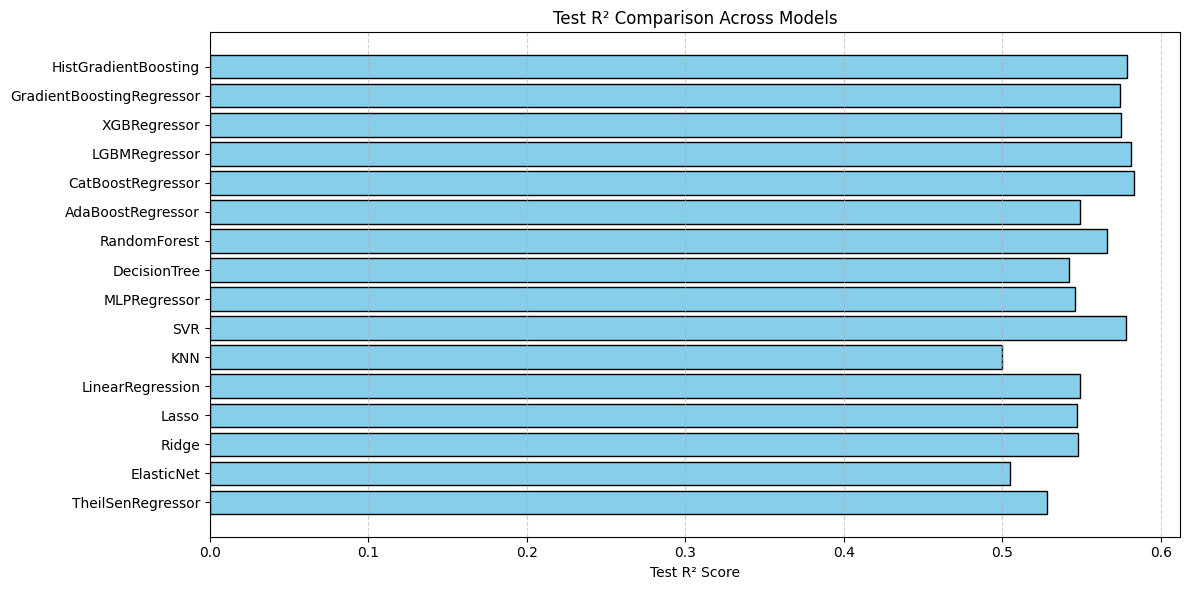

In [ ]:
# Re-import necessary libraries after kernel reset: For 70:30
import pandas as pd
import matplotlib.pyplot as plt

# Data from the user's table
data = {
    "ModelName": [
        "HistGradientBoosting", "GradientBoostingRegressor", "XGBRegressor", "LGBMRegressor",
        "CatBoostRegressor", "AdaBoostRegressor", "RandomForest", "DecisionTree",
        "MLPRegressor", "SVR", "KNN", "LinearRegression", "Lasso", "Ridge",
        "ElasticNet", "TheilSenRegressor"
    ],
    "Test R2": [
        0.579, 0.574, 0.575, 0.581, 0.583, 0.549, 0.566, 0.542,
        0.546, 0.578, 0.500, 0.549, 0.547, 0.548, 0.505, 0.528
    ],
    "Test RMSE": [
        4.287, 4.315, 4.310, 4.277, 4.268, 4.438, 4.354, 4.472,
        4.454, 4.295, 4.671, 4.439, 4.447, 4.441, 4.651, 4.538
    ]
}

df = pd.DataFrame(data)

# Plotting Test R² Comparison
plt.figure(figsize=(12, 6))
plt.barh(df["ModelName"], df["Test R2"], color="skyblue", edgecolor="black")
plt.xlabel("Test R² Score")
plt.title("Test R² Comparison Across Models")
plt.gca().invert_yaxis()  # Highest scores on top
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


This is for 80:20 Split


HistGradientBoosting:
  Train: R2=0.6071 RMSE=4.0831 MAE=3.2089 MAPE=2.91%
  Test : R2=0.5819 RMSE=4.2960 MAE=3.3251 MAPE=3.00%
  Train Time: 0.652s | Peak Mem: 1012.37MB

GradientBoostingRegressor:
  Train: R2=0.6298 RMSE=3.9636 MAE=3.1076 MAPE=2.82%
  Test : R2=0.5740 RMSE=4.3364 MAE=3.3493 MAPE=3.02%
  Train Time: 1.633s | Peak Mem: 1012.37MB

XGBRegressor:
  Train: R2=0.6297 RMSE=3.9639 MAE=3.1132 MAPE=2.83%
  Test : R2=0.5761 RMSE=4.3261 MAE=3.3568 MAPE=3.03%
  Train Time: 1.169s | Peak Mem: 1012.37MB
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 7584, number of used features: 4
[LightGBM] [Info] Start training from score 110.296361
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



SVR:
  Train: R2=0.5814 RMSE=4.2146 MAE=3.2885 MAPE=2.98%
  Test : R2=0.5789 RMSE=4.3117 MAE=3.3239 MAPE=3.00%
  Train Time: 9.807s | Peak Mem: 1012.64MB

KNN:
  Train: R2=0.6369 RMSE=3.9251 MAE=3.0902 MAPE=2.80%
  Test : R2=0.5127 RMSE=4.6383 MAE=3.6166 MAPE=3.26%
  Train Time: 0.103s | Peak Mem: 1012.64MB

LinearRegression:
  Train: R2=0.5393 RMSE=4.4214 MAE=3.4754 MAPE=3.15%
  Test : R2=0.5568 RMSE=4.4231 MAE=3.4290 MAPE=3.09%
  Train Time: 0.009s | Peak Mem: 1012.64MB

Lasso:
  Train: R2=0.5389 RMSE=4.4232 MAE=3.4783 MAPE=3.15%
  Test : R2=0.5549 RMSE=4.4329 MAE=3.4395 MAPE=3.10%
  Train Time: 0.010s | Peak Mem: 1012.64MB

Ridge:
  Train: R2=0.5392 RMSE=4.4219 MAE=3.4753 MAPE=3.15%
  Test : R2=0.5563 RMSE=4.4256 MAE=3.4314 MAPE=3.09%
  Train Time: 0.011s | Peak Mem: 1012.64MB

ElasticNet:
  Train: R2=0.5025 RMSE=4.5944 MAE=3.6178 MAPE=3.28%
  Test : R2=0.5097 RMSE=4.6521 MAE=3.6202 MAPE=3.26%
  Train Time: 0.014s | Peak Mem: 1012.64MB

TheilSenRegressor:
  Train: R2=0.5285 RMSE=4.

<ipython-input-26-d04aa0f1c484>:161: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))


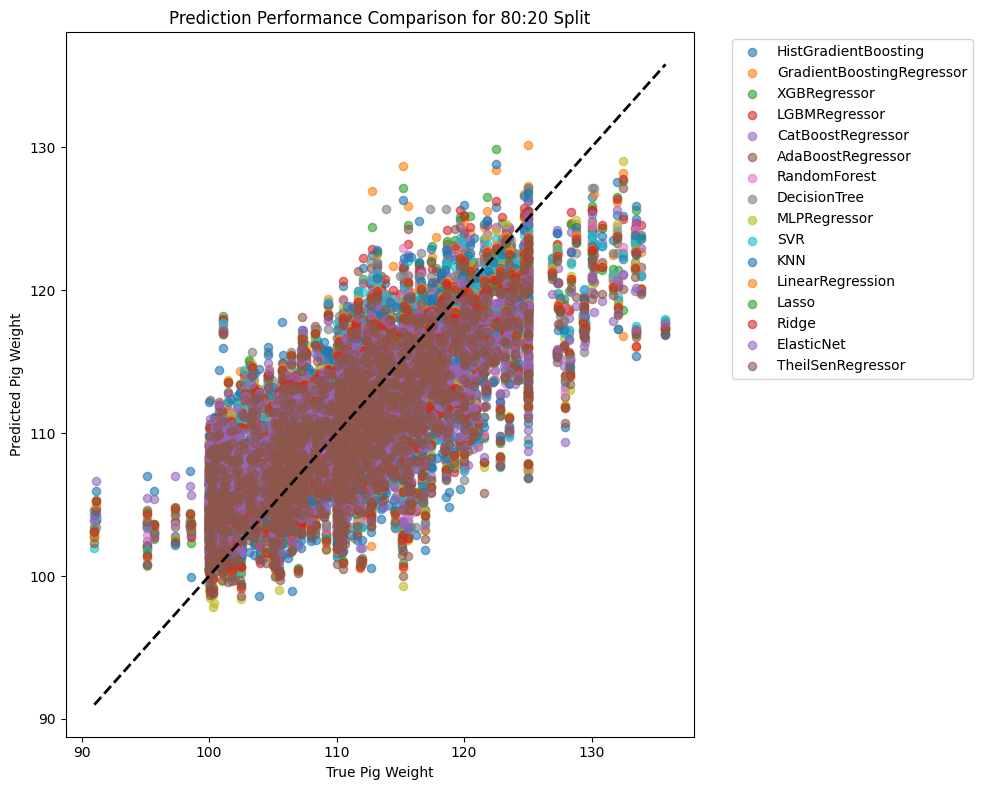

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# METRICS
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-7, np.inf))) * 100

def get_all_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def train_and_profile(model, X_train, y_train):
    """
    Trains a model, measuring time and memory.
    Returns trained model, training time (sec), and peak memory usage (MB).
    """
    train_time, mem_peak = None, None
    def fit_model():
        nonlocal train_time
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        return model
    mem_usage = memory_usage(fit_model, max_usage=True, retval=True)
    mem_peak = mem_usage[0]  # MB
    return model, train_time, mem_peak

def get_metrics_with_resource(model, X_train, y_train, X_val, y_val, name, resource_dict):
    model, train_time, mem_peak = train_and_profile(model, X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_metrics = get_all_metrics(y_train, train_pred)
    val_metrics = get_all_metrics(y_val, val_pred)
    results[name] = {
        'Train R2': train_metrics['R2'],
        'Train MAE': train_metrics['MAE'],
        'Train RMSE': train_metrics['RMSE'],
        'Train MAPE': train_metrics['MAPE'],
        'Test R2': val_metrics['R2'],
        'Test MAE': val_metrics['MAE'],
        'Test RMSE': val_metrics['RMSE'],
        'Test MAPE': val_metrics['MAPE'],
        'Model': model,
        'Val Prediction': val_pred,
        'Train Time (sec)': train_time,
        'Peak Mem (MB)': mem_peak,
    }
    resource_dict[name] = {"Train Time (sec)": train_time, "Peak Mem (MB)": mem_peak}
    print(f"\n{name}:")
    print("  Train: R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        train_metrics['R2'], train_metrics['RMSE'], train_metrics['MAE'], train_metrics['MAPE']))
    print("  Test : R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        val_metrics['R2'], val_metrics['RMSE'], val_metrics['MAE'], val_metrics['MAPE']))
    print(f"  Train Time: {train_time:.3f}s | Peak Mem: {mem_peak:.2f}MB")

results = {}
resource_dict = {}

#  ML MODELS (GRID OR REASONABLE PARAMS)

# HistGradientBoosting
hist_params = {'learning_rate': [0.05], 'max_iter': [100], 'max_depth': [5], 'min_samples_leaf': [10]}
histgrid = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid=hist_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(histgrid, X_train, y_train, X_val, y_val, "HistGradientBoosting", resource_dict)

# Gradient Boosting Regressor (Classic) with a simple parameter grid
gbr_params = {'learning_rate': [0.1], 'n_estimators': [100], 'max_depth': [5]}
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=gbr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(gbr_grid, X_train, y_train, X_val, y_val, "GradientBoostingRegressor", resource_dict)

# XGBoost
xgb_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
xgbgrid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1), param_grid=xgb_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(xgbgrid, X_train, y_train, X_val, y_val, "XGBRegressor", resource_dict)

# LGBM
lgbm_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
lgbmgrid = GridSearchCV(LGBMRegressor(random_state=42), param_grid=lgbm_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(lgbmgrid, X_train, y_train, X_val, y_val, "LGBMRegressor", resource_dict)

# CatBoost
cat_params = {'learning_rate': [0.1], 'depth': [5], 'iterations': [100], 'subsample': [0.8]}
catgrid = GridSearchCV(CatBoostRegressor(verbose=0, random_seed=42), param_grid=cat_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(catgrid, X_train, y_train, X_val, y_val, "CatBoostRegressor", resource_dict)

# AdaBoost
ada_params = {'learning_rate': [0.1], 'n_estimators': [100]}
adagird = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid=ada_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(adagird, X_train, y_train, X_val, y_val, "AdaBoostRegressor", resource_dict)

# Random Forest
rf_params = {'n_estimators': [100], 'max_depth': [5]}
rfgrid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(rfgrid, X_train, y_train, X_val, y_val, "RandomForest", resource_dict)

# Decision Tree
dt_params = {'max_depth': [5], 'min_samples_split': [2]}
dtgrid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid=dt_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(dtgrid, X_train, y_train, X_val, y_val, "DecisionTree", resource_dict)

# Multilayer Perceptron (MLP)
mlp_params = {'hidden_layer_sizes': [(100,)], 'activation': ['relu'], 'solver': ['adam'], 'max_iter': [200]}
mlpgrid = GridSearchCV(MLPRegressor(random_state=42), param_grid=mlp_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(mlpgrid, X_train, y_train, X_val, y_val, "MLPRegressor", resource_dict)

# Support Vector Machine (SVM)
svr_params = {'C': [1], 'kernel': ['rbf']}
svrgrid = GridSearchCV(SVR(), param_grid=svr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(svrgrid, X_train, y_train, X_val, y_val, "SVR", resource_dict)

# K Nearest Neighbors (KNN)
knn_params = {'n_neighbors': [5], 'weights': ['uniform']}
knngrid = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(knngrid, X_train, y_train, X_val, y_val, "KNN", resource_dict)

# Linear Regression
lr = LinearRegression()
get_metrics_with_resource(lr, X_train, y_train, X_val, y_val, "LinearRegression", resource_dict)

# Lasso Regression
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
get_metrics_with_resource(lasso, X_train, y_train, X_val, y_val, "Lasso", resource_dict)

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
get_metrics_with_resource(ridge, X_train, y_train, X_val, y_val, "Ridge", resource_dict)

# ElasticNet Regression
enet = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42)
get_metrics_with_resource(enet, X_train, y_train, X_val, y_val, "ElasticNet", resource_dict)

# TheilSen Regressor
ts_reg = TheilSenRegressor(random_state=42, max_iter=100)
get_metrics_with_resource(ts_reg, X_train, y_train, X_val, y_val, "TheilSenRegressor", resource_dict)


# SUMMARY TABLE
summary_rows = []
for name, res in results.items():
    row = res.copy()
    row['ModelName'] = name
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
order = [
    'ModelName',
    'Train R2', 'Train RMSE', 'Train MAE', 'Train MAPE',
    'Test R2', 'Test RMSE', 'Test MAE', 'Test MAPE',
    'Train Time (sec)', 'Peak Mem (MB)'
]

# Round to three decimals (except model name)
summary_df = summary_df[order]
to_round = [col for col in order if col != 'ModelName']
summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))

print("\n--- Summary Table (Main Metrics + Resource Usage, rounded to 3 decimals) ---")
print(summary_df.to_string(index=False))


#  DIAGRAM: SCATTERPLOT OF MODEL PREDICTIONS

plt.figure(figsize=(10,8))
for name, res in results.items():
    plt.scatter(y_val, res["Val Prediction"], label=name, alpha=0.6, s=35)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("True Pig Weight")
plt.ylabel("Predicted Pig Weight")
plt.title("Prediction Performance Comparison for 80:20 Split")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), ncol=1)
plt.tight_layout()
plt.show()



This is for 60:40 Train Test Split


HistGradientBoosting:
  Train: R2=0.6123 RMSE=4.0423 MAE=3.1858 MAPE=2.89%
  Test : R2=0.5713 RMSE=4.3297 MAE=3.3718 MAPE=3.05%
  Train Time: 0.913s | Peak Mem: 1020.67MB

GradientBoostingRegressor:
  Train: R2=0.6429 RMSE=3.8795 MAE=3.0414 MAPE=2.76%
  Test : R2=0.5613 RMSE=4.3802 MAE=3.4006 MAPE=3.07%
  Train Time: 1.657s | Peak Mem: 1020.67MB

XGBRegressor:
  Train: R2=0.6415 RMSE=3.8869 MAE=3.0513 MAPE=2.77%
  Test : R2=0.5660 RMSE=4.3565 MAE=3.3835 MAPE=3.06%
  Train Time: 0.253s | Peak Mem: 1020.67MB
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 4
[LightGBM] [Info] Start training from score 110.262939
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



SVR:
  Train: R2=0.5823 RMSE=4.1953 MAE=3.2751 MAPE=2.97%
  Test : R2=0.5739 RMSE=4.3166 MAE=3.3454 MAPE=3.02%
  Train Time: 4.885s | Peak Mem: 1020.81MB

KNN:
  Train: R2=0.6419 RMSE=3.8845 MAE=3.0557 MAPE=2.77%
  Test : R2=0.5078 RMSE=4.6394 MAE=3.6114 MAPE=3.26%
  Train Time: 0.092s | Peak Mem: 1020.81MB

LinearRegression:
  Train: R2=0.5406 RMSE=4.4002 MAE=3.4651 MAPE=3.14%
  Test : R2=0.5456 RMSE=4.4576 MAE=3.4656 MAPE=3.13%
  Train Time: 0.011s | Peak Mem: 1020.81MB

Lasso:
  Train: R2=0.5402 RMSE=4.4021 MAE=3.4686 MAPE=3.14%
  Test : R2=0.5444 RMSE=4.4636 MAE=3.4719 MAPE=3.13%
  Train Time: 0.010s | Peak Mem: 1020.81MB

Ridge:
  Train: R2=0.5404 RMSE=4.4011 MAE=3.4655 MAPE=3.14%
  Test : R2=0.5454 RMSE=4.4588 MAE=3.4663 MAPE=3.13%
  Train Time: 0.009s | Peak Mem: 1020.81MB

ElasticNet:
  Train: R2=0.5029 RMSE=4.5769 MAE=3.6079 MAPE=3.27%
  Test : R2=0.5054 RMSE=4.6508 MAE=3.6291 MAPE=3.27%
  Train Time: 0.009s | Peak Mem: 1020.81MB

TheilSenRegressor:
  Train: R2=0.5310 RMSE=4.

<ipython-input-27-12c7b36dac1a>:161: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))


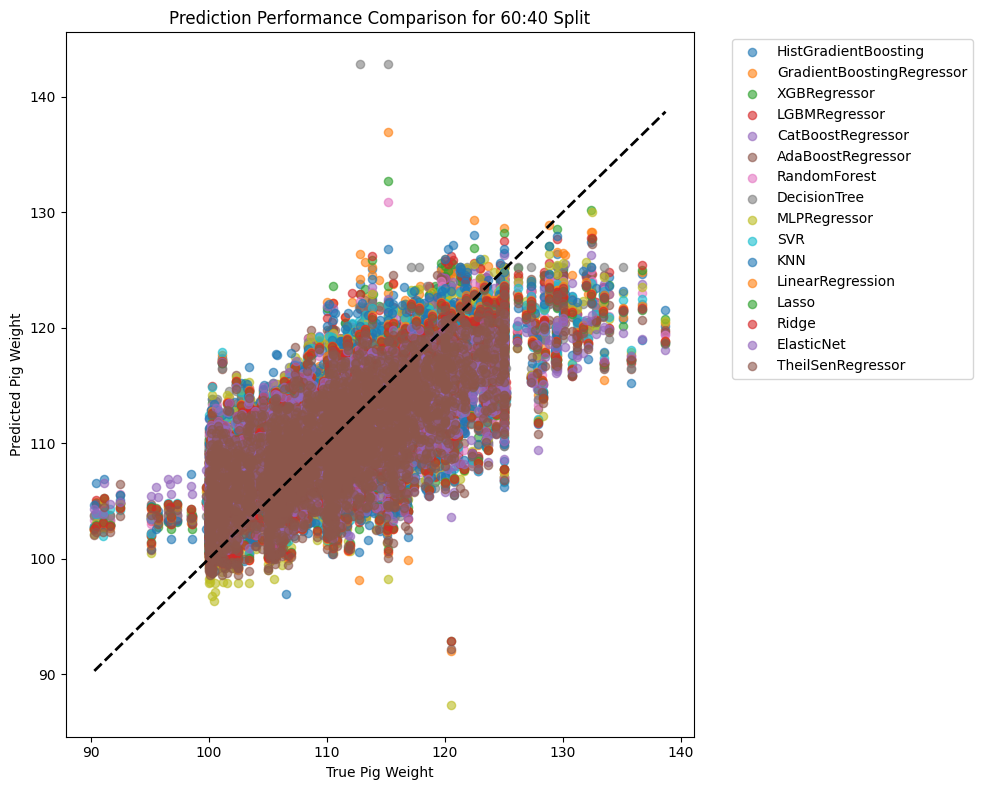

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42
)

# METRICS

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-7, np.inf))) * 100

def get_all_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def train_and_profile(model, X_train, y_train):
    """
    Trains a model, measuring time and memory.
    Returns trained model, training time (sec), and peak memory usage (MB).
    """
    train_time, mem_peak = None, None
    def fit_model():
        nonlocal train_time
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        return model
    mem_usage = memory_usage(fit_model, max_usage=True, retval=True)
    mem_peak = mem_usage[0]  # MB
    return model, train_time, mem_peak

def get_metrics_with_resource(model, X_train, y_train, X_val, y_val, name, resource_dict):
    model, train_time, mem_peak = train_and_profile(model, X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_metrics = get_all_metrics(y_train, train_pred)
    val_metrics = get_all_metrics(y_val, val_pred)
    results[name] = {
        'Train R2': train_metrics['R2'],
        'Train MAE': train_metrics['MAE'],
        'Train RMSE': train_metrics['RMSE'],
        'Train MAPE': train_metrics['MAPE'],
        'Test R2': val_metrics['R2'],
        'Test MAE': val_metrics['MAE'],
        'Test RMSE': val_metrics['RMSE'],
        'Test MAPE': val_metrics['MAPE'],
        'Model': model,
        'Val Prediction': val_pred,
        'Train Time (sec)': train_time,
        'Peak Mem (MB)': mem_peak,
    }
    resource_dict[name] = {"Train Time (sec)": train_time, "Peak Mem (MB)": mem_peak}
    print(f"\n{name}:")
    print("  Train: R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        train_metrics['R2'], train_metrics['RMSE'], train_metrics['MAE'], train_metrics['MAPE']))
    print("  Test : R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        val_metrics['R2'], val_metrics['RMSE'], val_metrics['MAE'], val_metrics['MAPE']))
    print(f"  Train Time: {train_time:.3f}s | Peak Mem: {mem_peak:.2f}MB")

results = {}
resource_dict = {}

#  ML MODELS (GRID OR REASONABLE PARAMS)

# HistGradientBoosting
hist_params = {'learning_rate': [0.05], 'max_iter': [100], 'max_depth': [5], 'min_samples_leaf': [10]}
histgrid = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid=hist_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(histgrid, X_train, y_train, X_val, y_val, "HistGradientBoosting", resource_dict)

# Gradient Boosting Regressor (Classic) with a simple parameter grid
gbr_params = {'learning_rate': [0.1], 'n_estimators': [100], 'max_depth': [5]}
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=gbr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(gbr_grid, X_train, y_train, X_val, y_val, "GradientBoostingRegressor", resource_dict)

# XGBoost
xgb_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
xgbgrid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1), param_grid=xgb_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(xgbgrid, X_train, y_train, X_val, y_val, "XGBRegressor", resource_dict)

# LGBM
lgbm_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
lgbmgrid = GridSearchCV(LGBMRegressor(random_state=42), param_grid=lgbm_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(lgbmgrid, X_train, y_train, X_val, y_val, "LGBMRegressor", resource_dict)

# CatBoost
cat_params = {'learning_rate': [0.1], 'depth': [5], 'iterations': [100], 'subsample': [0.8]}
catgrid = GridSearchCV(CatBoostRegressor(verbose=0, random_seed=42), param_grid=cat_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(catgrid, X_train, y_train, X_val, y_val, "CatBoostRegressor", resource_dict)

# AdaBoost
ada_params = {'learning_rate': [0.1], 'n_estimators': [100]}
adagird = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid=ada_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(adagird, X_train, y_train, X_val, y_val, "AdaBoostRegressor", resource_dict)

# Random Forest
rf_params = {'n_estimators': [100], 'max_depth': [5]}
rfgrid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(rfgrid, X_train, y_train, X_val, y_val, "RandomForest", resource_dict)

# Decision Tree
dt_params = {'max_depth': [5], 'min_samples_split': [2]}
dtgrid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid=dt_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(dtgrid, X_train, y_train, X_val, y_val, "DecisionTree", resource_dict)

# Multilayer Perceptron (MLP)
mlp_params = {'hidden_layer_sizes': [(100,)], 'activation': ['relu'], 'solver': ['adam'], 'max_iter': [200]}
mlpgrid = GridSearchCV(MLPRegressor(random_state=42), param_grid=mlp_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(mlpgrid, X_train, y_train, X_val, y_val, "MLPRegressor", resource_dict)

# Support Vector Machine (SVM)
svr_params = {'C': [1], 'kernel': ['rbf']}
svrgrid = GridSearchCV(SVR(), param_grid=svr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(svrgrid, X_train, y_train, X_val, y_val, "SVR", resource_dict)

# K Nearest Neighbors (KNN)
knn_params = {'n_neighbors': [5], 'weights': ['uniform']}
knngrid = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(knngrid, X_train, y_train, X_val, y_val, "KNN", resource_dict)

# Linear Regression
lr = LinearRegression()
get_metrics_with_resource(lr, X_train, y_train, X_val, y_val, "LinearRegression", resource_dict)

# Lasso Regression
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
get_metrics_with_resource(lasso, X_train, y_train, X_val, y_val, "Lasso", resource_dict)

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
get_metrics_with_resource(ridge, X_train, y_train, X_val, y_val, "Ridge", resource_dict)

# ElasticNet Regression
enet = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42)
get_metrics_with_resource(enet, X_train, y_train, X_val, y_val, "ElasticNet", resource_dict)

# TheilSen Regressor
ts_reg = TheilSenRegressor(random_state=42, max_iter=100)
get_metrics_with_resource(ts_reg, X_train, y_train, X_val, y_val, "TheilSenRegressor", resource_dict)


# SUMMARY TABLE

summary_rows = []
for name, res in results.items():
    row = res.copy()
    row['ModelName'] = name
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
order = [
    'ModelName',
    'Train R2', 'Train RMSE', 'Train MAE', 'Train MAPE',
    'Test R2', 'Test RMSE', 'Test MAE', 'Test MAPE',
    'Train Time (sec)', 'Peak Mem (MB)'
]

# Round to three decimals (except model name)
summary_df = summary_df[order]
to_round = [col for col in order if col != 'ModelName']
summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))

print("\n--- Summary Table (Main Metrics + Resource Usage, rounded to 3 decimals) ---")
print(summary_df.to_string(index=False))


# DIAGRAM: SCATTERPLOT OF MODEL PREDICTIONS

plt.figure(figsize=(10,8))
for name, res in results.items():
    plt.scatter(y_val, res["Val Prediction"], label=name, alpha=0.6, s=35)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("True Pig Weight")
plt.ylabel("Predicted Pig Weight")
plt.title("Prediction Performance Comparison for 60:40 Split")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), ncol=1)
plt.tight_layout()
plt.show()



This is for 90:10 Train-Test Split


HistGradientBoosting:
  Train: R2=0.6073 RMSE=4.0743 MAE=3.1980 MAPE=2.90%
  Test : R2=0.5726 RMSE=4.4867 MAE=3.4702 MAPE=3.12%
  Train Time: 0.670s | Peak Mem: 1021.66MB

GradientBoostingRegressor:
  Train: R2=0.6270 RMSE=3.9709 MAE=3.1088 MAPE=2.82%
  Test : R2=0.5682 RMSE=4.5095 MAE=3.4912 MAPE=3.14%
  Train Time: 1.638s | Peak Mem: 1021.73MB

XGBRegressor:
  Train: R2=0.6249 RMSE=3.9823 MAE=3.1215 MAPE=2.83%
  Test : R2=0.5706 RMSE=4.4973 MAE=3.4798 MAPE=3.13%
  Train Time: 0.642s | Peak Mem: 1021.91MB
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 8532, number of used features: 4
[LightGBM] [Info] Start training from score 110.299320
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



SVR:
  Train: R2=0.5826 RMSE=4.2006 MAE=3.2707 MAPE=2.96%
  Test : R2=0.5684 RMSE=4.5084 MAE=3.4785 MAPE=3.12%
  Train Time: 11.950s | Peak Mem: 1022.78MB

KNN:
  Train: R2=0.6341 RMSE=3.9329 MAE=3.0950 MAPE=2.80%
  Test : R2=0.4904 RMSE=4.8993 MAE=3.7928 MAPE=3.41%
  Train Time: 0.115s | Peak Mem: 1022.78MB

LinearRegression:
  Train: R2=0.5428 RMSE=4.3965 MAE=3.4534 MAPE=3.13%
  Test : R2=0.5436 RMSE=4.6364 MAE=3.5665 MAPE=3.20%
  Train Time: 0.009s | Peak Mem: 1022.78MB

Lasso:
  Train: R2=0.5424 RMSE=4.3983 MAE=3.4567 MAPE=3.13%
  Test : R2=0.5415 RMSE=4.6469 MAE=3.5767 MAPE=3.21%
  Train Time: 0.010s | Peak Mem: 1022.78MB

Ridge:
  Train: R2=0.5427 RMSE=4.3969 MAE=3.4535 MAPE=3.13%
  Test : R2=0.5428 RMSE=4.6405 MAE=3.5698 MAPE=3.21%
  Train Time: 0.009s | Peak Mem: 1022.78MB

ElasticNet:
  Train: R2=0.5059 RMSE=4.5706 MAE=3.5985 MAPE=3.26%
  Test : R2=0.4931 RMSE=4.8862 MAE=3.7607 MAPE=3.37%
  Train Time: 0.010s | Peak Mem: 1022.78MB

TheilSenRegressor:
  Train: R2=0.5326 RMSE=4

<ipython-input-28-bba3964ebab0>:161: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))


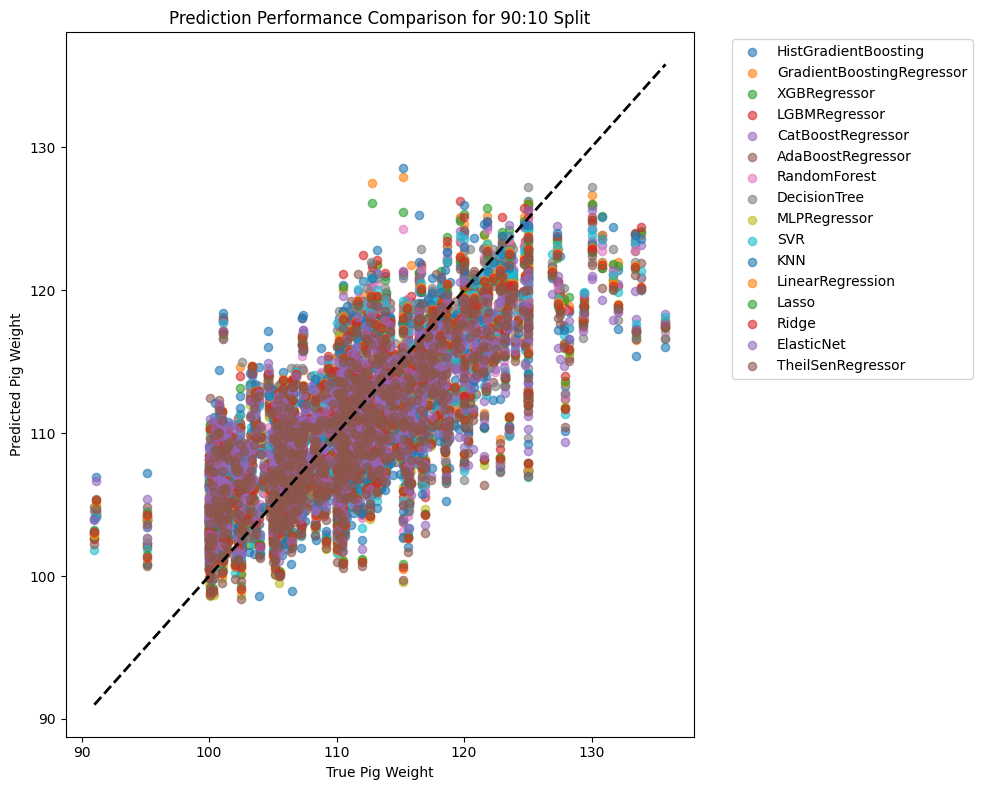

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.1, random_state=42
)

#  METRICS

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-7, np.inf))) * 100

def get_all_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def train_and_profile(model, X_train, y_train):
    """
    Trains a model, measuring time and memory.
    Returns trained model, training time (sec), and peak memory usage (MB).
    """
    train_time, mem_peak = None, None
    def fit_model():
        nonlocal train_time
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        return model
    mem_usage = memory_usage(fit_model, max_usage=True, retval=True)
    mem_peak = mem_usage[0]  # MB
    return model, train_time, mem_peak

def get_metrics_with_resource(model, X_train, y_train, X_val, y_val, name, resource_dict):
    model, train_time, mem_peak = train_and_profile(model, X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_metrics = get_all_metrics(y_train, train_pred)
    val_metrics = get_all_metrics(y_val, val_pred)
    results[name] = {
        'Train R2': train_metrics['R2'],
        'Train MAE': train_metrics['MAE'],
        'Train RMSE': train_metrics['RMSE'],
        'Train MAPE': train_metrics['MAPE'],
        'Test R2': val_metrics['R2'],
        'Test MAE': val_metrics['MAE'],
        'Test RMSE': val_metrics['RMSE'],
        'Test MAPE': val_metrics['MAPE'],
        'Model': model,
        'Val Prediction': val_pred,
        'Train Time (sec)': train_time,
        'Peak Mem (MB)': mem_peak,
    }
    resource_dict[name] = {"Train Time (sec)": train_time, "Peak Mem (MB)": mem_peak}
    print(f"\n{name}:")
    print("  Train: R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        train_metrics['R2'], train_metrics['RMSE'], train_metrics['MAE'], train_metrics['MAPE']))
    print("  Test : R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        val_metrics['R2'], val_metrics['RMSE'], val_metrics['MAE'], val_metrics['MAPE']))
    print(f"  Train Time: {train_time:.3f}s | Peak Mem: {mem_peak:.2f}MB")

results = {}
resource_dict = {}

# ML MODELS
# HistGradientBoosting
hist_params = {'learning_rate': [0.05], 'max_iter': [100], 'max_depth': [5], 'min_samples_leaf': [10]}
histgrid = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid=hist_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(histgrid, X_train, y_train, X_val, y_val, "HistGradientBoosting", resource_dict)

# Gradient Boosting Regressor (Classic) with a simple parameter grid
gbr_params = {'learning_rate': [0.1], 'n_estimators': [100], 'max_depth': [5]}
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=gbr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(gbr_grid, X_train, y_train, X_val, y_val, "GradientBoostingRegressor", resource_dict)

# XGBoost
xgb_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
xgbgrid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1), param_grid=xgb_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(xgbgrid, X_train, y_train, X_val, y_val, "XGBRegressor", resource_dict)

# LGBM
lgbm_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
lgbmgrid = GridSearchCV(LGBMRegressor(random_state=42), param_grid=lgbm_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(lgbmgrid, X_train, y_train, X_val, y_val, "LGBMRegressor", resource_dict)

# CatBoost
cat_params = {'learning_rate': [0.1], 'depth': [5], 'iterations': [100], 'subsample': [0.8]}
catgrid = GridSearchCV(CatBoostRegressor(verbose=0, random_seed=42), param_grid=cat_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(catgrid, X_train, y_train, X_val, y_val, "CatBoostRegressor", resource_dict)

# AdaBoost
ada_params = {'learning_rate': [0.1], 'n_estimators': [100]}
adagird = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid=ada_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(adagird, X_train, y_train, X_val, y_val, "AdaBoostRegressor", resource_dict)

# Random Forest
rf_params = {'n_estimators': [100], 'max_depth': [5]}
rfgrid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(rfgrid, X_train, y_train, X_val, y_val, "RandomForest", resource_dict)

# Decision Tree
dt_params = {'max_depth': [5], 'min_samples_split': [2]}
dtgrid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid=dt_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(dtgrid, X_train, y_train, X_val, y_val, "DecisionTree", resource_dict)

# Multilayer Perceptron (MLP)
mlp_params = {'hidden_layer_sizes': [(100,)], 'activation': ['relu'], 'solver': ['adam'], 'max_iter': [200]}
mlpgrid = GridSearchCV(MLPRegressor(random_state=42), param_grid=mlp_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(mlpgrid, X_train, y_train, X_val, y_val, "MLPRegressor", resource_dict)

# Support Vector Machine (SVM)
svr_params = {'C': [1], 'kernel': ['rbf']}
svrgrid = GridSearchCV(SVR(), param_grid=svr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(svrgrid, X_train, y_train, X_val, y_val, "SVR", resource_dict)

# K Nearest Neighbors (KNN)
knn_params = {'n_neighbors': [5], 'weights': ['uniform']}
knngrid = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(knngrid, X_train, y_train, X_val, y_val, "KNN", resource_dict)

# Linear Regression
lr = LinearRegression()
get_metrics_with_resource(lr, X_train, y_train, X_val, y_val, "LinearRegression", resource_dict)

# Lasso Regression
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
get_metrics_with_resource(lasso, X_train, y_train, X_val, y_val, "Lasso", resource_dict)

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
get_metrics_with_resource(ridge, X_train, y_train, X_val, y_val, "Ridge", resource_dict)

# ElasticNet Regression
enet = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42)
get_metrics_with_resource(enet, X_train, y_train, X_val, y_val, "ElasticNet", resource_dict)

# TheilSen Regressor
ts_reg = TheilSenRegressor(random_state=42, max_iter=100)
get_metrics_with_resource(ts_reg, X_train, y_train, X_val, y_val, "TheilSenRegressor", resource_dict)


# SUMMARY TABLE

summary_rows = []
for name, res in results.items():
    row = res.copy()
    row['ModelName'] = name
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
order = [
    'ModelName',
    'Train R2', 'Train RMSE', 'Train MAE', 'Train MAPE',
    'Test R2', 'Test RMSE', 'Test MAE', 'Test MAPE',
    'Train Time (sec)', 'Peak Mem (MB)'
]

# Round to three decimals (except model name)
summary_df = summary_df[order]
to_round = [col for col in order if col != 'ModelName']
summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))

print("\n--- Summary Table (Main Metrics + Resource Usage, rounded to 3 decimals) ---")
print(summary_df.to_string(index=False))


# DIAGRAM: SCATTERPLOT OF MODEL PREDICTIONS

plt.figure(figsize=(10,8))
for name, res in results.items():
    plt.scatter(y_val, res["Val Prediction"], label=name, alpha=0.6, s=35)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("True Pig Weight")
plt.ylabel("Predicted Pig Weight")
plt.title("Prediction Performance Comparison for 90:10 Split")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), ncol=1)
plt.tight_layout()
plt.show()



Comparing R2 of 70:30 and 80:20 train-test splits

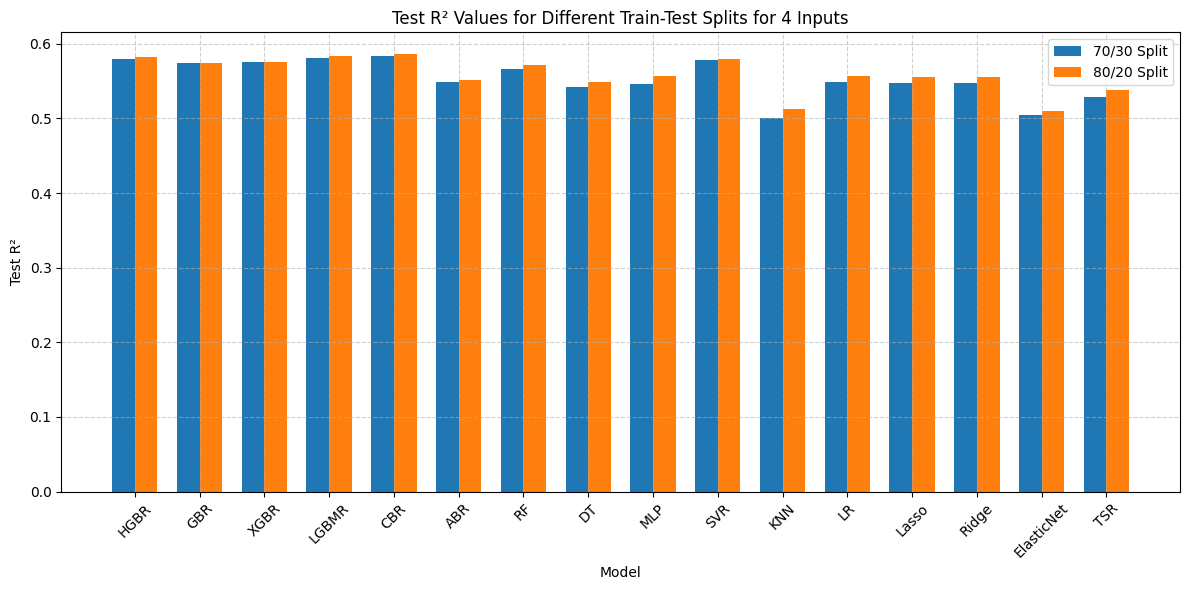

In [ ]:
# Re-import necessary libraries after code state reset
import matplotlib.pyplot as plt
import numpy as np

# Model names (same in both tables)
models = [
    'HGBR', 'GBR', 'XGBR', 'LGBMR', 'CBR', 'ABR', 'RF', 'DT', 'MLP',
    'SVR', 'KNN', 'LR', 'Lasso', 'Ridge', 'ElasticNet', 'TSR'
]

# Test R² values from Table 1 (70/30 split)
test_r2_table1 = [
    0.579, 0.574, 0.575, 0.581, 0.583, 0.549, 0.566, 0.542, 0.546,
    0.578, 0.500, 0.549, 0.547, 0.548, 0.505, 0.528
]

# Test R² values from Table 2 (80/20 split)
test_r2_table2 = [
    0.582, 0.574, 0.576, 0.584, 0.586, 0.551, 0.572, 0.549, 0.557,
    0.579, 0.513, 0.557, 0.555, 0.556, 0.510, 0.538
]

x = np.arange(len(models))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, test_r2_table1, width, label='70/30 Split')
bars2 = ax.bar(x + width/2, test_r2_table2, width, label='80/20 Split')

# Labels and formatting
ax.set_xlabel('Model')
ax.set_ylabel('Test R²')
ax.set_title('Test R² Values for Different Train-Test Splits for 4 Inputs')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

REDOING FOR ALL FEATURES

In [ ]:
# OUTLIER REMOVAL (on ONLY 4 FEATURES)
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

# SELECT ONLY THOSE COLUMNS FOR X
X = data[main_features]
y = data['Weight measurement']

In [ ]:
# NORMALIZATION

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

THis is for 70_30 Train-Test Split


HistGradientBoosting:
  Train: R2=0.7303 RMSE=3.4356 MAE=2.6373 MAPE=2.37%
  Test : R2=0.6896 RMSE=3.6167 MAE=2.7698 MAPE=2.49%
  Train Time: 1.584s | Peak Mem: 995.01MB

GradientBoostingRegressor:
  Train: R2=0.7533 RMSE=3.2856 MAE=2.5082 MAPE=2.26%
  Test : R2=0.6891 RMSE=3.6201 MAE=2.7545 MAPE=2.47%
  Train Time: 2.910s | Peak Mem: 995.04MB

XGBRegressor:
  Train: R2=0.7551 RMSE=3.2742 MAE=2.5034 MAPE=2.26%
  Test : R2=0.6887 RMSE=3.6223 MAE=2.7520 MAPE=2.47%
  Train Time: 0.367s | Peak Mem: 995.29MB
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 10
[LightGBM] [Info] Start training from score 110.470374
[Lig

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



SVR:
  Train: R2=0.6473 RMSE=3.9289 MAE=2.9792 MAPE=2.68%
  Test : R2=0.6430 RMSE=3.8792 MAE=2.9538 MAPE=2.65%
  Train Time: 8.725s | Peak Mem: 996.95MB

KNN:
  Train: R2=0.7610 RMSE=3.2340 MAE=2.4167 MAPE=2.17%
  Test : R2=0.6380 RMSE=3.9059 MAE=2.9664 MAPE=2.66%
  Train Time: 0.244s | Peak Mem: 996.95MB

LinearRegression:
  Train: R2=0.6268 RMSE=4.0416 MAE=3.1345 MAPE=2.83%
  Test : R2=0.6304 RMSE=3.9466 MAE=3.0562 MAPE=2.76%
  Train Time: 0.010s | Peak Mem: 996.96MB

Lasso:
  Train: R2=0.6248 RMSE=4.0523 MAE=3.1417 MAPE=2.83%
  Test : R2=0.6276 RMSE=3.9617 MAE=3.0648 MAPE=2.76%
  Train Time: 0.012s | Peak Mem: 996.96MB

Ridge:
  Train: R2=0.6266 RMSE=4.0427 MAE=3.1349 MAPE=2.83%
  Test : R2=0.6298 RMSE=3.9502 MAE=3.0588 MAPE=2.76%
  Train Time: 0.010s | Peak Mem: 996.96MB

ElasticNet:
  Train: R2=0.5887 RMSE=4.2427 MAE=3.2624 MAPE=2.94%
  Test : R2=0.5821 RMSE=4.1966 MAE=3.2308 MAPE=2.91%
  Train Time: 0.020s | Peak Mem: 996.96MB

TheilSenRegressor:
  Train: R2=0.5543 RMSE=4.4166 M

<ipython-input-9-7d2412d37dc1>:161: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))


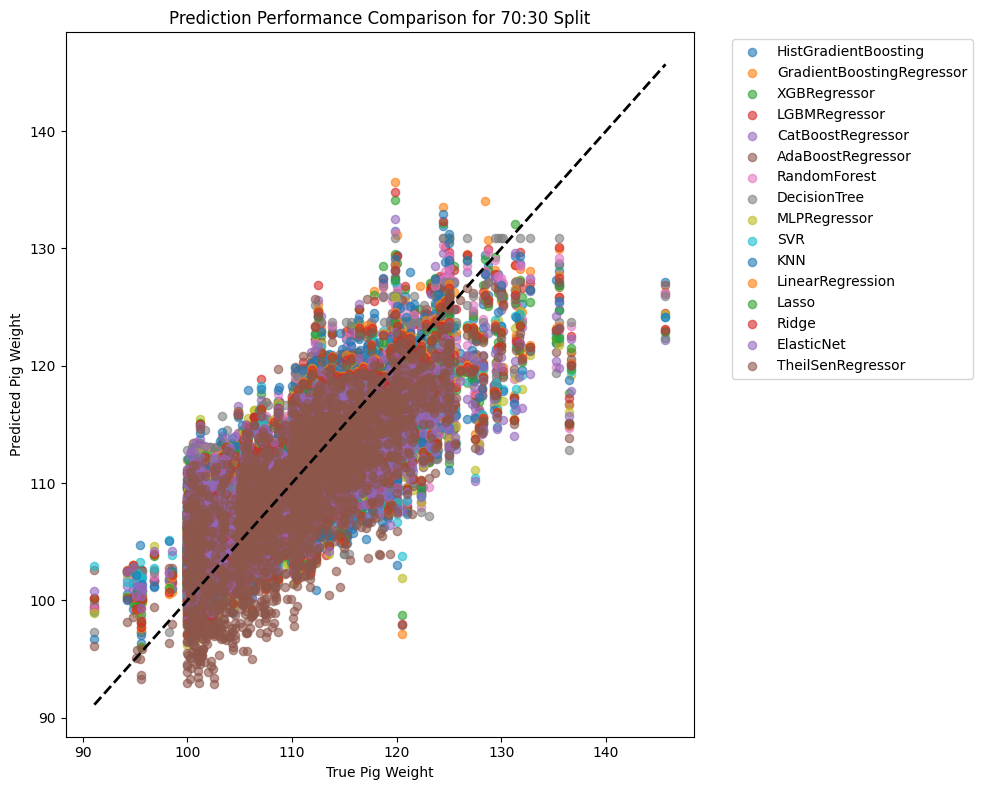

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# METRICS

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-7, np.inf))) * 100

def get_all_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def train_and_profile(model, X_train, y_train):
    """
    Trains a model, measuring time and memory.
    Returns trained model, training time (sec), and peak memory usage (MB).
    """
    train_time, mem_peak = None, None
    def fit_model():
        nonlocal train_time
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        return model
    mem_usage = memory_usage(fit_model, max_usage=True, retval=True)
    mem_peak = mem_usage[0]  # MB
    return model, train_time, mem_peak

def get_metrics_with_resource(model, X_train, y_train, X_val, y_val, name, resource_dict):
    model, train_time, mem_peak = train_and_profile(model, X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_metrics = get_all_metrics(y_train, train_pred)
    val_metrics = get_all_metrics(y_val, val_pred)
    results[name] = {
        'Train R2': train_metrics['R2'],
        'Train MAE': train_metrics['MAE'],
        'Train RMSE': train_metrics['RMSE'],
        'Train MAPE': train_metrics['MAPE'],
        'Test R2': val_metrics['R2'],
        'Test MAE': val_metrics['MAE'],
        'Test RMSE': val_metrics['RMSE'],
        'Test MAPE': val_metrics['MAPE'],
        'Model': model,
        'Val Prediction': val_pred,
        'Train Time (sec)': train_time,
        'Peak Mem (MB)': mem_peak,
    }
    resource_dict[name] = {"Train Time (sec)": train_time, "Peak Mem (MB)": mem_peak}
    print(f"\n{name}:")
    print("  Train: R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        train_metrics['R2'], train_metrics['RMSE'], train_metrics['MAE'], train_metrics['MAPE']))
    print("  Test : R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        val_metrics['R2'], val_metrics['RMSE'], val_metrics['MAE'], val_metrics['MAPE']))
    print(f"  Train Time: {train_time:.3f}s | Peak Mem: {mem_peak:.2f}MB")

results = {}
resource_dict = {}

#  ML MODELS (GRID OR REASONABLE PARAMS)

# HistGradientBoosting
hist_params = {'learning_rate': [0.05], 'max_iter': [100], 'max_depth': [5], 'min_samples_leaf': [10]}
histgrid = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid=hist_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(histgrid, X_train, y_train, X_val, y_val, "HistGradientBoosting", resource_dict)

# Gradient Boosting Regressor (Classic) with a simple parameter grid
gbr_params = {'learning_rate': [0.1], 'n_estimators': [100], 'max_depth': [5]}
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=gbr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(gbr_grid, X_train, y_train, X_val, y_val, "GradientBoostingRegressor", resource_dict)

# XGBoost
xgb_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
xgbgrid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1), param_grid=xgb_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(xgbgrid, X_train, y_train, X_val, y_val, "XGBRegressor", resource_dict)

# LGBM
lgbm_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
lgbmgrid = GridSearchCV(LGBMRegressor(random_state=42), param_grid=lgbm_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(lgbmgrid, X_train, y_train, X_val, y_val, "LGBMRegressor", resource_dict)

# CatBoost
cat_params = {'learning_rate': [0.1], 'depth': [5], 'iterations': [100], 'subsample': [0.8]}
catgrid = GridSearchCV(CatBoostRegressor(verbose=0, random_seed=42), param_grid=cat_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(catgrid, X_train, y_train, X_val, y_val, "CatBoostRegressor", resource_dict)

# AdaBoost
ada_params = {'learning_rate': [0.1], 'n_estimators': [100]}
adagird = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid=ada_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(adagird, X_train, y_train, X_val, y_val, "AdaBoostRegressor", resource_dict)

# Random Forest
rf_params = {'n_estimators': [100], 'max_depth': [5]}
rfgrid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(rfgrid, X_train, y_train, X_val, y_val, "RandomForest", resource_dict)

# Decision Tree
dt_params = {'max_depth': [5], 'min_samples_split': [2]}
dtgrid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid=dt_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(dtgrid, X_train, y_train, X_val, y_val, "DecisionTree", resource_dict)

# Multilayer Perceptron (MLP)
mlp_params = {'hidden_layer_sizes': [(100,)], 'activation': ['relu'], 'solver': ['adam'], 'max_iter': [200]}
mlpgrid = GridSearchCV(MLPRegressor(random_state=42), param_grid=mlp_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(mlpgrid, X_train, y_train, X_val, y_val, "MLPRegressor", resource_dict)

# Support Vector Machine (SVM)
svr_params = {'C': [1], 'kernel': ['rbf']}
svrgrid = GridSearchCV(SVR(), param_grid=svr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(svrgrid, X_train, y_train, X_val, y_val, "SVR", resource_dict)

# K Nearest Neighbors (KNN)
knn_params = {'n_neighbors': [5], 'weights': ['uniform']}
knngrid = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(knngrid, X_train, y_train, X_val, y_val, "KNN", resource_dict)

# Linear Regression
lr = LinearRegression()
get_metrics_with_resource(lr, X_train, y_train, X_val, y_val, "LinearRegression", resource_dict)

# Lasso Regression
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
get_metrics_with_resource(lasso, X_train, y_train, X_val, y_val, "Lasso", resource_dict)

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
get_metrics_with_resource(ridge, X_train, y_train, X_val, y_val, "Ridge", resource_dict)

# ElasticNet Regression
enet = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42)
get_metrics_with_resource(enet, X_train, y_train, X_val, y_val, "ElasticNet", resource_dict)

# TheilSen Regressor
ts_reg = TheilSenRegressor(random_state=42, max_iter=100)
get_metrics_with_resource(ts_reg, X_train, y_train, X_val, y_val, "TheilSenRegressor", resource_dict)


# SUMMARY TABLE

summary_rows = []
for name, res in results.items():
    row = res.copy()
    row['ModelName'] = name
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
order = [
    'ModelName',
    'Train R2', 'Train RMSE', 'Train MAE', 'Train MAPE',
    'Test R2', 'Test RMSE', 'Test MAE', 'Test MAPE',
    'Train Time (sec)', 'Peak Mem (MB)'
]

# Round to three decimals
summary_df = summary_df[order]
to_round = [col for col in order if col != 'ModelName']
summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))

print("\n--- Summary Table (Main Metrics + Resource Usage, rounded to 3 decimals) ---")
print(summary_df.to_string(index=False))


#  DIAGRAM: SCATTERPLOT OF MODEL PREDICTIONS

plt.figure(figsize=(10,8))
for name, res in results.items():
    plt.scatter(y_val, res["Val Prediction"], label=name, alpha=0.6, s=35)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("True Pig Weight")
plt.ylabel("Predicted Pig Weight")
plt.title("Prediction Performance Comparison for 70:30 Split")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), ncol=1)
plt.tight_layout()
plt.show()



This is for 80:20 Train-Test Split


HistGradientBoosting:
  Train: R2=0.7284 RMSE=3.4299 MAE=2.6246 MAPE=2.36%
  Test : R2=0.6904 RMSE=3.6554 MAE=2.7898 MAPE=2.51%
  Train Time: 5.310s | Peak Mem: 392.08MB

GradientBoostingRegressor:
  Train: R2=0.7513 RMSE=3.2823 MAE=2.5099 MAPE=2.26%
  Test : R2=0.6880 RMSE=3.6698 MAE=2.7931 MAPE=2.51%
  Train Time: 2.611s | Peak Mem: 392.32MB

XGBRegressor:
  Train: R2=0.7525 RMSE=3.2743 MAE=2.5022 MAPE=2.25%
  Test : R2=0.6908 RMSE=3.6530 MAE=2.7804 MAPE=2.50%
  Train Time: 0.487s | Peak Mem: 397.05MB
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 7584, number of used features: 10
[LightGBM] [Info] Start training from score 110.474749
[Lig

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



SVR:
  Train: R2=0.6485 RMSE=3.9016 MAE=2.9649 MAPE=2.66%
  Test : R2=0.6553 RMSE=3.8570 MAE=2.9291 MAPE=2.63%
  Train Time: 10.950s | Peak Mem: 605.01MB

KNN:
  Train: R2=0.7620 RMSE=3.2108 MAE=2.4102 MAPE=2.16%
  Test : R2=0.6508 RMSE=3.8823 MAE=2.9466 MAPE=2.64%
  Train Time: 0.295s | Peak Mem: 409.04MB

LinearRegression:
  Train: R2=0.6259 RMSE=4.0252 MAE=3.1217 MAPE=2.82%
  Test : R2=0.6358 RMSE=3.9648 MAE=3.0655 MAPE=2.76%
  Train Time: 0.010s | Peak Mem: 410.25MB

Lasso:
  Train: R2=0.6239 RMSE=4.0358 MAE=3.1287 MAPE=2.82%
  Test : R2=0.6337 RMSE=3.9765 MAE=3.0700 MAPE=2.77%
  Train Time: 0.011s | Peak Mem: 410.32MB

Ridge:
  Train: R2=0.6258 RMSE=4.0260 MAE=3.1220 MAPE=2.82%
  Test : R2=0.6355 RMSE=3.9663 MAE=3.0659 MAPE=2.76%
  Train Time: 0.013s | Peak Mem: 410.81MB

ElasticNet:
  Train: R2=0.5864 RMSE=4.2323 MAE=3.2573 MAPE=2.93%
  Test : R2=0.5911 RMSE=4.2012 MAE=3.2235 MAPE=2.90%
  Train Time: 0.021s | Peak Mem: 410.82MB

TheilSenRegressor:
  Train: R2=0.5574 RMSE=4.3782 

<ipython-input-8-d04aa0f1c484>:161: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))


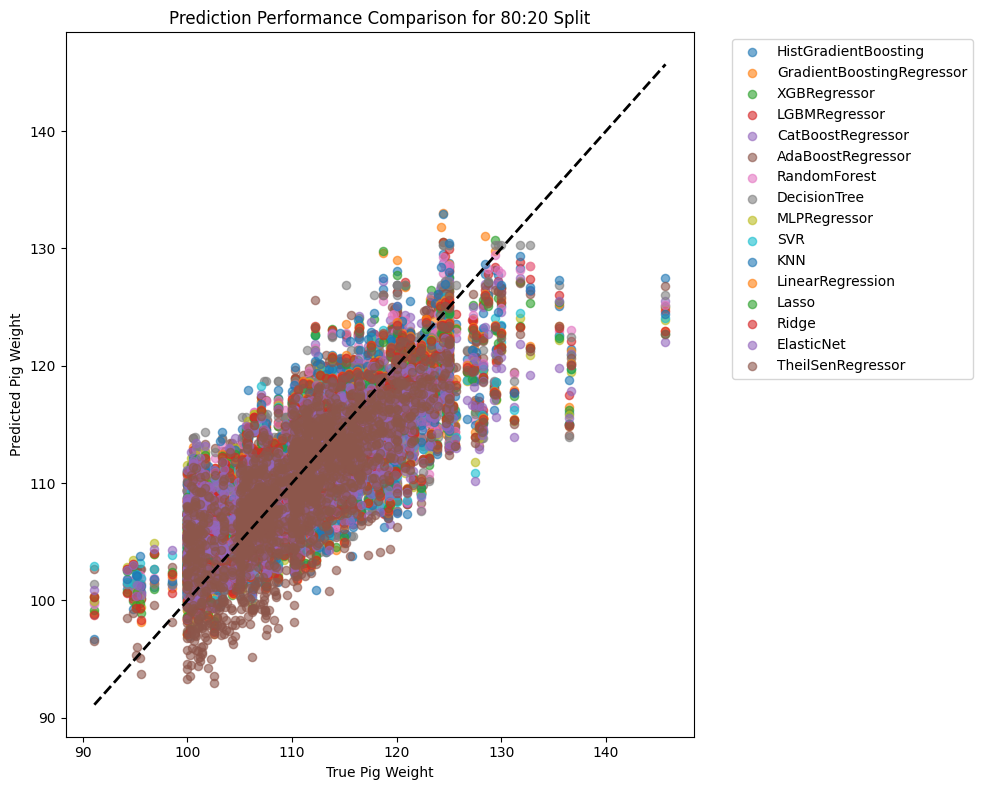

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

#  METRICS

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-7, np.inf))) * 100

def get_all_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def train_and_profile(model, X_train, y_train):
    """
    Trains a model, measuring time and memory.
    Returns trained model, training time (sec), and peak memory usage (MB).
    """
    train_time, mem_peak = None, None
    def fit_model():
        nonlocal train_time
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        return model
    mem_usage = memory_usage(fit_model, max_usage=True, retval=True)
    mem_peak = mem_usage[0]  # MB
    return model, train_time, mem_peak

def get_metrics_with_resource(model, X_train, y_train, X_val, y_val, name, resource_dict):
    model, train_time, mem_peak = train_and_profile(model, X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_metrics = get_all_metrics(y_train, train_pred)
    val_metrics = get_all_metrics(y_val, val_pred)
    results[name] = {
        'Train R2': train_metrics['R2'],
        'Train MAE': train_metrics['MAE'],
        'Train RMSE': train_metrics['RMSE'],
        'Train MAPE': train_metrics['MAPE'],
        'Test R2': val_metrics['R2'],
        'Test MAE': val_metrics['MAE'],
        'Test RMSE': val_metrics['RMSE'],
        'Test MAPE': val_metrics['MAPE'],
        'Model': model,
        'Val Prediction': val_pred,
        'Train Time (sec)': train_time,
        'Peak Mem (MB)': mem_peak,
    }
    resource_dict[name] = {"Train Time (sec)": train_time, "Peak Mem (MB)": mem_peak}
    print(f"\n{name}:")
    print("  Train: R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        train_metrics['R2'], train_metrics['RMSE'], train_metrics['MAE'], train_metrics['MAPE']))
    print("  Test : R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
        val_metrics['R2'], val_metrics['RMSE'], val_metrics['MAE'], val_metrics['MAPE']))
    print(f"  Train Time: {train_time:.3f}s | Peak Mem: {mem_peak:.2f}MB")

results = {}
resource_dict = {}

#  ML MODELS (GRID OR REASONABLE PARAMS)

# HistGradientBoosting
hist_params = {'learning_rate': [0.05], 'max_iter': [100], 'max_depth': [5], 'min_samples_leaf': [10]}
histgrid = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid=hist_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(histgrid, X_train, y_train, X_val, y_val, "HistGradientBoosting", resource_dict)

# Gradient Boosting Regressor (Classic) with a simple parameter grid
gbr_params = {'learning_rate': [0.1], 'n_estimators': [100], 'max_depth': [5]}
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=gbr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(gbr_grid, X_train, y_train, X_val, y_val, "GradientBoostingRegressor", resource_dict)

# XGBoost
xgb_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
xgbgrid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1), param_grid=xgb_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(xgbgrid, X_train, y_train, X_val, y_val, "XGBRegressor", resource_dict)

# LGBM
lgbm_params = {'learning_rate': [0.1], 'max_depth': [5], 'n_estimators': [100], 'subsample': [0.8]}
lgbmgrid = GridSearchCV(LGBMRegressor(random_state=42), param_grid=lgbm_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(lgbmgrid, X_train, y_train, X_val, y_val, "LGBMRegressor", resource_dict)

# CatBoost
cat_params = {'learning_rate': [0.1], 'depth': [5], 'iterations': [100], 'subsample': [0.8]}
catgrid = GridSearchCV(CatBoostRegressor(verbose=0, random_seed=42), param_grid=cat_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(catgrid, X_train, y_train, X_val, y_val, "CatBoostRegressor", resource_dict)

# AdaBoost
ada_params = {'learning_rate': [0.1], 'n_estimators': [100]}
adagird = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid=ada_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(adagird, X_train, y_train, X_val, y_val, "AdaBoostRegressor", resource_dict)

# Random Forest
rf_params = {'n_estimators': [100], 'max_depth': [5]}
rfgrid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(rfgrid, X_train, y_train, X_val, y_val, "RandomForest", resource_dict)

# Decision Tree
dt_params = {'max_depth': [5], 'min_samples_split': [2]}
dtgrid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid=dt_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(dtgrid, X_train, y_train, X_val, y_val, "DecisionTree", resource_dict)

# Multilayer Perceptron (MLP)
mlp_params = {'hidden_layer_sizes': [(100,)], 'activation': ['relu'], 'solver': ['adam'], 'max_iter': [200]}
mlpgrid = GridSearchCV(MLPRegressor(random_state=42), param_grid=mlp_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(mlpgrid, X_train, y_train, X_val, y_val, "MLPRegressor", resource_dict)

# Support Vector Machine (SVM)
svr_params = {'C': [1], 'kernel': ['rbf']}
svrgrid = GridSearchCV(SVR(), param_grid=svr_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(svrgrid, X_train, y_train, X_val, y_val, "SVR", resource_dict)

# K Nearest Neighbors (KNN)
knn_params = {'n_neighbors': [5], 'weights': ['uniform']}
knngrid = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=3, n_jobs=-1, scoring='r2')
get_metrics_with_resource(knngrid, X_train, y_train, X_val, y_val, "KNN", resource_dict)

# Linear Regression
lr = LinearRegression()
get_metrics_with_resource(lr, X_train, y_train, X_val, y_val, "LinearRegression", resource_dict)

# Lasso Regression
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
get_metrics_with_resource(lasso, X_train, y_train, X_val, y_val, "Lasso", resource_dict)

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
get_metrics_with_resource(ridge, X_train, y_train, X_val, y_val, "Ridge", resource_dict)

# ElasticNet Regression
enet = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42)
get_metrics_with_resource(enet, X_train, y_train, X_val, y_val, "ElasticNet", resource_dict)

# TheilSen Regressor
ts_reg = TheilSenRegressor(random_state=42, max_iter=100)
get_metrics_with_resource(ts_reg, X_train, y_train, X_val, y_val, "TheilSenRegressor", resource_dict)


# SUMMARY TABLE

summary_rows = []
for name, res in results.items():
    row = res.copy()
    row['ModelName'] = name
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
order = [
    'ModelName',
    'Train R2', 'Train RMSE', 'Train MAE', 'Train MAPE',
    'Test R2', 'Test RMSE', 'Test MAE', 'Test MAPE',
    'Train Time (sec)', 'Peak Mem (MB)'
]

# Round to three decimals (except model name)
summary_df = summary_df[order]
to_round = [col for col in order if col != 'ModelName']
summary_df[to_round] = summary_df[to_round].applymap(lambda x: round(x, 3))

print("\n--- Summary Table (Main Metrics + Resource Usage, rounded to 3 decimals) ---")
print(summary_df.to_string(index=False))


# DIAGRAM: SCATTERPLOT OF MODEL PREDICTIONS

plt.figure(figsize=(10,8))
for name, res in results.items():
    plt.scatter(y_val, res["Val Prediction"], label=name, alpha=0.6, s=35)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("True Pig Weight")
plt.ylabel("Predicted Pig Weight")
plt.title("Prediction Performance Comparison for 80:20 Split")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), ncol=1)
plt.tight_layout()
plt.show()



In [ ]:
from docx import Document
from docx.shared import Inches
import pandas as pd

# Create the data dictionary
data = [
    ["HistGradientBoosting", 0.728, 3.430, 2.625, 2.363, 0.690, 3.655, 2.790, 2.506, 5.310, 392.082],
    ["GradientBoostingRegressor", 0.751, 3.282, 2.510, 2.261, 0.688, 3.670, 2.793, 2.506, 2.611, 392.324],
    ["XGBRegressor", 0.752, 3.274, 2.502, 2.254, 0.691, 3.653, 2.780, 2.496, 0.487, 397.047],
    ["LGBMRegressor", 0.741, 3.351, 2.562, 2.305, 0.691, 3.650, 2.784, 2.499, 3.092, 400.246],
    ["CatBoostRegressor", 0.704, 3.578, 2.740, 2.468, 0.687, 3.677, 2.804, 2.521, 1.479, 408.059],
    ["AdaBoostRegressor", 0.593, 4.198, 3.278, 2.970, 0.584, 4.239, 3.320, 3.007, 3.722, 409.355],
    ["RandomForest", 0.663, 3.823, 2.925, 2.637, 0.645, 3.915, 2.993, 2.695, 2.020, 409.555],
    ["DecisionTree", 0.621, 4.050, 3.087, 2.781, 0.601, 4.152, 3.173, 2.856, 0.076, 409.570],
    ["MLPRegressor", 0.619, 4.061, 3.146, 2.837, 0.630, 3.997, 3.086, 2.782, 13.087, 410.000],
    ["SVR", 0.649, 3.902, 2.965, 2.663, 0.655, 3.857, 2.929, 2.630, 10.950, 605.008],
    ["KNN", 0.762, 3.211, 2.410, 2.162, 0.651, 3.882, 2.947, 2.637, 0.295, 409.043],
    ["LinearRegression", 0.626, 4.025, 3.122, 2.816, 0.636, 3.965, 3.065, 2.765, 0.010, 410.250],
    ["Lasso", 0.624, 4.036, 3.129, 2.822, 0.634, 3.976, 3.070, 2.769, 0.011, 410.316],
    ["Ridge", 0.626, 4.026, 3.122, 2.816, 0.636, 3.966, 3.066, 2.765, 0.013, 410.812],
    ["ElasticNet", 0.586, 4.232, 3.257, 2.933, 0.591, 4.201, 3.224, 2.902, 0.021, 410.816],
    ["TheilSenRegressor", 0.557, 4.378, 3.400, 3.066, 0.570, 4.307, 3.339, 3.008, 2.225, 990.789]
]

columns = [
    "ModelName", "Train R2", "Train RMSE", "Train MAE", "Train MAPE",
    "Test R2", "Test RMSE", "Test MAE", "Test MAPE",
    "Train Time (sec)", "Peak Mem (MB)"
]

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Create a Word document
doc = Document()
doc.add_heading('Model Performance Comparison', 0)

# Add a table
table = doc.add_table(rows=1, cols=len(columns))
hdr_cells = table.rows[0].cells
for i, col in enumerate(columns):
    hdr_cells[i].text = col

# Add data rows
for _, row in df.iterrows():
    row_cells = table.add_row().cells
    for i, item in enumerate(row):
        row_cells[i].text = str(item)

# Save document
output_path = "/mnt/data/Model_Performance_Comparison.docx"
doc.save(output_path)

output_path


'/mnt/data/Model_Performance_Comparison.docx'

For Test R2 of all Splits

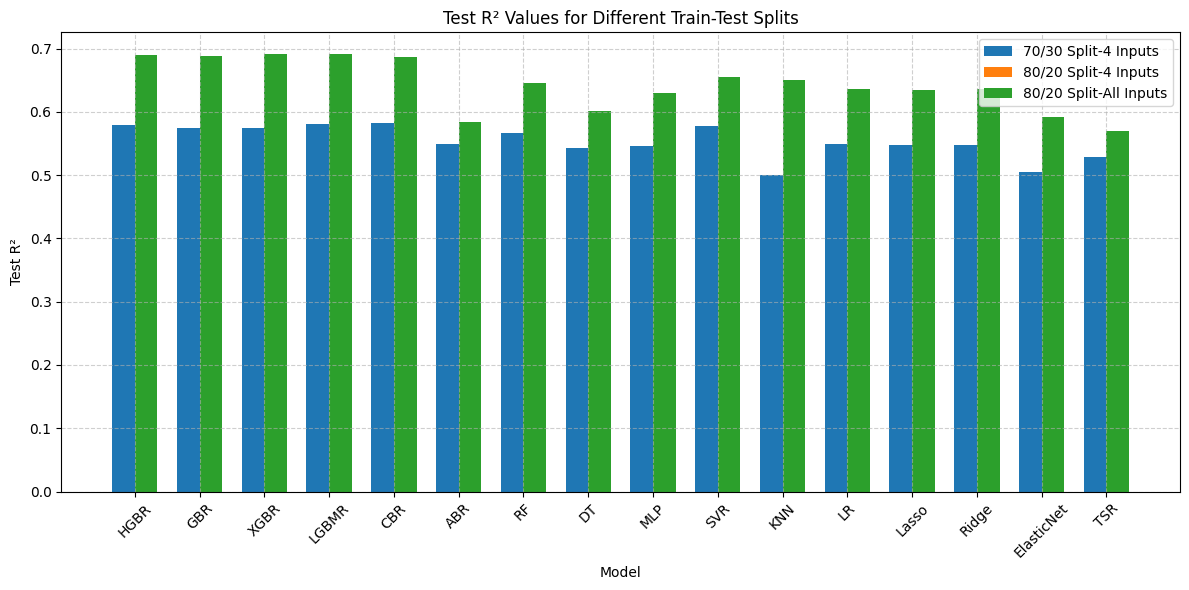

In [ ]:
# Re-import necessary libraries after code state reset
import matplotlib.pyplot as plt
import numpy as np

# Model names (same in both tables)
models = [
    'HGBR', 'GBR', 'XGBR', 'LGBMR', 'CBR', 'ABR', 'RF', 'DT', 'MLP',
    'SVR', 'KNN', 'LR', 'Lasso', 'Ridge', 'ElasticNet', 'TSR'
]

# Test R² values from Table 1 (70/30 split)
test_r2_table1 = [
    0.579, 0.574, 0.575, 0.581, 0.583, 0.549, 0.566, 0.542, 0.546,
    0.578, 0.500, 0.549, 0.547, 0.548, 0.505, 0.528
]

# Test R² values from Table 2 (80/20 split)
test_r2_table2 = [
    0.582, 0.574, 0.576, 0.584, 0.586, 0.551, 0.572, 0.549, 0.557,
    0.579, 0.513, 0.557, 0.555, 0.556, 0.510, 0.538
]

# Test R² values from Table 2 (80/20 split)
test_r2_table3 = [
    0.690, 0.688, 0.691, 0.691, 0.687, 0.584, 0.645, 0.601, 0.630,
    0.655, 0.651, 0.636, 0.634, 0.636, 0.591, 0.570

]

x = np.arange(len(models))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, test_r2_table1, width, label='70/30 Split-4 Inputs')
bars2 = ax.bar(x + width/2, test_r2_table2, width, label='80/20 Split-4 Inputs')
bars3 = ax.bar(x + width/2, test_r2_table3, width, label='80/20 Split-All Inputs')

# Labels and formatting
ax.set_xlabel('Model')
ax.set_ylabel('Test R²')
ax.set_title('Test R² Values for Different Train-Test Splits')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

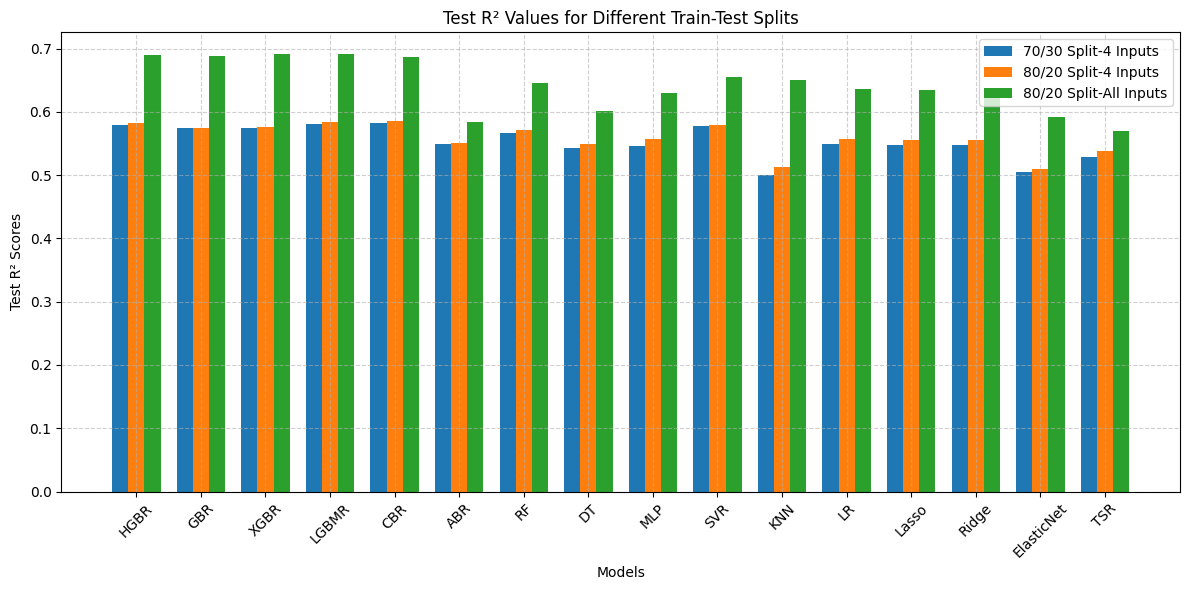

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    'HGBR', 'GBR', 'XGBR', 'LGBMR', 'CBR', 'ABR', 'RF', 'DT', 'MLP',
    'SVR', 'KNN', 'LR', 'Lasso', 'Ridge', 'ElasticNet', 'TSR'
]

# Test R² values
test_r2_table1 = [
    0.579, 0.574, 0.575, 0.581, 0.583, 0.549, 0.566, 0.542, 0.546,
    0.578, 0.500, 0.549, 0.547, 0.548, 0.505, 0.528
]
test_r2_table2 = [
    0.582, 0.574, 0.576, 0.584, 0.586, 0.551, 0.572, 0.549, 0.557,
    0.579, 0.513, 0.557, 0.555, 0.556, 0.510, 0.538
]
test_r2_table3 = [
    0.690, 0.688, 0.691, 0.691, 0.687, 0.584, 0.645, 0.601, 0.630,
    0.655, 0.651, 0.636, 0.634, 0.636, 0.591, 0.570
]

x = np.arange(len(models))  # label locations
width = 0.25  # each bar width

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, test_r2_table1, width, label='70/30 Split-4 Inputs')
bars2 = ax.bar(x,        test_r2_table2, width, label='80/20 Split-4 Inputs')
bars3 = ax.bar(x + width, test_r2_table3, width, label='80/20 Split-All Inputs')

# Labels and formatting
ax.set_xlabel('Models')
ax.set_ylabel('Test R² Scores')
ax.set_title('Test R² Values for Different Train-Test Splits')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Cross Validation for K=3, 5, 7, 10 for 4 Inputs

In [ ]:
!pip install lightgbm catboost xgboost memory_profiler openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import (
    HistGradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, IsolationForest, GradientBoostingRegressor
)
from sklearn.linear_model import (
    TheilSenRegressor, LinearRegression, Lasso, Ridge, ElasticNet
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from scipy import stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00


In [ ]:
# DATA LOAD AND CLEANING
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

Saving dataset.xlsx to dataset.xlsx



=== XGBR ===
 k=3: R2=0.568  RMSE=4.301  MAE=3.359  MAPE=3.040
 k=5: R2=0.575  RMSE=4.264  MAE=3.335  MAPE=3.020
 k=7: R2=0.575  RMSE=4.265  MAE=3.331  MAPE=3.016
 k=10: R2=0.575  RMSE=4.264  MAE=3.334  MAPE=3.019
 R2: Mean=0.573, Std=0.004, Var=0.00001, CI=(0.567, 0.579)
 RMSE: Mean=4.273, Std=0.018, Var=0.00034, CI=(4.244, 4.302)
 MAE: Mean=3.340, Std=0.013, Var=0.00016, CI=(3.319, 3.360)
 MAPE: Mean=3.024, Std=0.011, Var=0.00013, CI=(3.006, 3.042)
 Best k for Mean R2: 10 with Mean R2 = 0.575176092189103

=== HGBR ===
 k=3: R2=0.572  RMSE=4.282  MAE=3.352  MAPE=3.035
 k=5: R2=0.576  RMSE=4.261  MAE=3.333  MAPE=3.019
 k=7: R2=0.577  RMSE=4.256  MAE=3.328  MAPE=3.013
 k=10: R2=0.577  RMSE=4.256  MAE=3.329  MAPE=3.015
 R2: Mean=0.575, Std=0.002, Var=0.00001, CI=(0.571, 0.579)
 RMSE: Mean=4.264, Std=0.012, Var=0.00015, CI=(4.244, 4.283)
 MAE: Mean=3.335, Std=0.011, Var=0.00012, CI=(3.318, 3.353)
 MAPE: Mean=3.020, Std=0.010, Var=0.00009, CI=(3.005, 3.036)
 Best k for Mean R2: 10 with Me

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 k=3: R2=0.532  RMSE=4.474  MAE=3.478  MAPE=3.134
 k=5: R2=0.533  RMSE=4.470  MAE=3.477  MAPE=3.132
 k=7: R2=0.533  RMSE=4.471  MAE=3.475  MAPE=3.130
 k=10: R2=0.532  RMSE=4.473  MAE=3.476  MAPE=3.131
 R2: Mean=0.533, Std=0.000, Var=0.00000, CI=(0.532, 0.533)
 RMSE: Mean=4.472, Std=0.002, Var=0.00000, CI=(4.470, 4.475)
 MAE: Mean=3.476, Std=0.001, Var=0.00000, CI=(3.474, 3.479)
 MAPE: Mean=3.131, Std=0.002, Var=0.00000, CI=(3.129, 3.134)
 Best k for Mean R2: 5 with Mean R2 = 0.5329583327238637


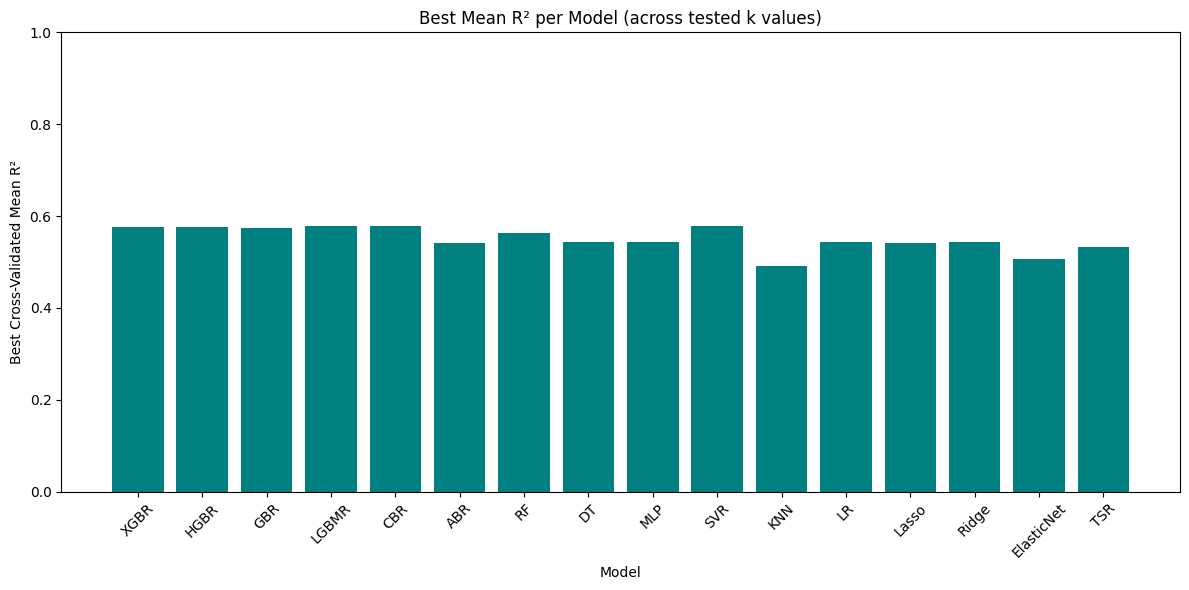

In [ ]:
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
data = data.drop(columns=['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth'])

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# METRIC FUNCTIONS
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-7, np.inf))) * 100

def metrics_all(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def get_ci(samples, alpha=0.05):
    n = len(samples)
    mean = np.mean(samples)
    std = np.std(samples, ddof=1)
    se = std / np.sqrt(n)
    # two-sided
    ci = stats.t.interval(1 - alpha, n-1, loc=mean, scale=se)
    return mean, std, np.var(samples, ddof=1), ci

# MODEL DICTIONARY
model_dict = {
    'XGBR': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8,
                         random_state=42, n_jobs=-1, objective='reg:squarederror'),
    'HGBR': HistGradientBoostingRegressor(learning_rate=0.1, max_iter=100, max_depth=5, min_samples_leaf=10,
                                          random_state=42),
    'GBR': GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42),
    'LGBMR': LGBMRegressor(learning_rate=0.1, n_estimators=100, max_depth=5, subsample=0.8, random_state=42),
    'CBR': CatBoostRegressor(learning_rate=0.1, iterations=100, depth=5, subsample=0.8, verbose=0, random_seed=42),
    'ABR': AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'RF': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'DT': DecisionTreeRegressor(max_depth=5, random_state=42),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=200, random_state=42),
    'SVR': SVR(C=1, kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5, weights='uniform'),
    'LR': LinearRegression(),
    'Lasso': Lasso(alpha=0.01, max_iter=10000, random_state=42),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42),
    'TSR': TheilSenRegressor(random_state=42, max_iter=100)
}

k_list = [3, 5, 7, 10]
final_results = {}

# CROSS VALIDATION FOR EACH MODEL
for model_name, model in model_dict.items():
    print(f"\n=== {model_name} ===")
    model_results = {'k': [], 'R2': [], 'RMSE': [], 'MAE': [], 'MAPE': []}
    full_cv_pred = {}
    for k in k_list:
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        y_pred_cv = cross_val_predict(model, X_scaled, y, cv=kf, n_jobs=-1)
        m = metrics_all(y, y_pred_cv)
        for metric in ['R2', 'RMSE', 'MAE', 'MAPE']:
            model_results[metric].append(m[metric])
        model_results['k'].append(k)
        full_cv_pred[k] = y_pred_cv

    # Store results for later selection/reports
    final_results[model_name] = model_results
    # Print all stats by k
    for idx, k in enumerate(k_list):
        print(f" k={k}: R2={model_results['R2'][idx]:.3f}  RMSE={model_results['RMSE'][idx]:.3f}  MAE={model_results['MAE'][idx]:.3f}  MAPE={model_results['MAPE'][idx]:.3f}")
    # For each metric, print mean, std, var, CI for k-folds
    for metric in ['R2', 'RMSE', 'MAE', 'MAPE']:
        mean, std, var, ci = get_ci(model_results[metric])
        print(f" {metric}: Mean={mean:.3f}, Std={std:.3f}, Var={var:.5f}, CI=({ci[0]:.3f}, {ci[1]:.3f})")
    # Best mean R2
    best_idx = np.argmax(model_results['R2'])
    print(" Best k for Mean R2:", k_list[best_idx], "with Mean R2 =", model_results['R2'][best_idx])

# BAR PLOT OF BEST K's MEAN R2 FOR EACH MODEL
best_r2s = []
best_ks = []
for model, res in final_results.items():
    idx = np.argmax(res['R2'])
    best_r2s.append(res['R2'][idx])
    best_ks.append(res['k'][idx])

plt.figure(figsize=(12, 6))
bars = plt.bar(list(model_dict.keys()), best_r2s, color='teal')
for idx, k_val in enumerate(best_ks):
    bars[idx].set_label(f'Best k={k_val}')
plt.ylabel('Best Cross-Validated Mean R²')
plt.xlabel('Model')
plt.title('Best Mean R² per Model (across tested k values)')
plt.ylim(top=1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
!pip install lightgbm catboost xgboost memory_profiler openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from memory_profiler import memory_usage

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import (
    HistGradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, IsolationForest, GradientBoostingRegressor
)
from sklearn.linear_model import (
    TheilSenRegressor, LinearRegression, Lasso, Ridge, ElasticNet
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from scipy import stats

# DATA LOAD AND CLEANING
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
data = data.drop(columns=['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth'])

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# METRIC FUNCTIONS
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-7, np.inf))) * 100

def metrics_all(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def get_ci(samples, alpha=0.05):
    n = len(samples)
    mean = np.mean(samples)
    std = np.std(samples, ddof=1)
    se = std / np.sqrt(n)
    # two-sided
    ci = stats.t.interval(1 - alpha, n-1, loc=mean, scale=se)
    return mean, std, np.var(samples, ddof=1), ci

# Function: Train & Profile
def train_and_profile(model, X_train, y_train):
    train_time = None
    def fit_model():
        nonlocal train_time
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        return model
    mem_usage = memory_usage(fit_model, max_usage=True, retval=True)
    mem_peak = mem_usage[0]
    return train_time, mem_peak

# MODEL DICTIONARY
model_dict = {
    'XGBR': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8,
                         random_state=42, n_jobs=-1, objective='reg:squarederror'),
    'HGBR': HistGradientBoostingRegressor(learning_rate=0.1, max_iter=100, max_depth=5, min_samples_leaf=10,
                                          random_state=42),
    'GBR': GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42),
    'LGBMR': LGBMRegressor(learning_rate=0.1, n_estimators=100, max_depth=5, subsample=0.8, random_state=42),
    'CBR': CatBoostRegressor(learning_rate=0.1, iterations=100, depth=5, subsample=0.8, verbose=0, random_seed=42),
    'ABR': AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'RF': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'DT': DecisionTreeRegressor(max_depth=5, random_state=42),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=200, random_state=42),
    'SVR': SVR(C=1, kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5, weights='uniform'),
    'LR': LinearRegression(),
    'Lasso': Lasso(alpha=0.01, max_iter=10000, random_state=42),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42),
    'TSR': TheilSenRegressor(random_state=42, max_iter=100)
}

k_list = [3, 5, 7, 10]
final_results = {}


In [ ]:
# CROSS VALIDATION & PROFILING FOR EACH MODEL
for model_name, model_proto in model_dict.items():
    print(f"\n=== {model_name} ===")
    model_results = {'k': [], 'R2': [], 'RMSE': [], 'MAE': [], 'MAPE': [], 'Train_Time': [], 'Peak_Mem': []}
    for k in k_list:
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        fold_metrics = {'R2': [], 'RMSE': [], 'MAE': [], 'MAPE': [], 'TrainTime': [], 'PeakMem': []}
        for train_idx, test_idx in kf.split(X_scaled):
            X_tr, X_te = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
            model = model_proto.__class__(**model_proto.get_params())  # New instance with same params
            train_time, mem_peak = train_and_profile(model, X_tr, y_tr)
            y_pred = model.predict(X_te)
            m = metrics_all(y_te, y_pred)
            fold_metrics['R2'].append(m['R2'])
            fold_metrics['RMSE'].append(m['RMSE'])
            fold_metrics['MAE'].append(m['MAE'])
            fold_metrics['MAPE'].append(m['MAPE'])
            fold_metrics['TrainTime'].append(train_time)
            fold_metrics['PeakMem'].append(mem_peak)
        for metric in ['R2', 'RMSE', 'MAE', 'MAPE', 'TrainTime', 'PeakMem']:
            model_results[metric if metric not in ['TrainTime', 'PeakMem'] else
                          ('Train_Time' if metric == 'TrainTime' else 'Peak_Mem')].append(np.mean(fold_metrics[metric]))
        model_results['k'].append(k)

    final_results[model_name] = model_results
    # Print all stats by k
    for idx, k in enumerate(k_list):
        print(f"k={k}: R2={model_results['R2'][idx]:.3f}  RMSE={model_results['RMSE'][idx]:.3f}  "
              f"MAE={model_results['MAE'][idx]:.3f}  MAPE={model_results['MAPE'][idx]:.3f}  "
              f"Time={model_results['Train_Time'][idx]:.3f}s Mem={model_results['Peak_Mem'][idx]:.2f}MB")
    # For each metric, print mean, std, var, CI for k-folds
    for metric in ['R2', 'RMSE', 'MAE', 'MAPE']:
        #The function name to 'get_ci'
        mean, std, var, ci = get_ci(model_results[metric])
        print(f" {metric}: Mean={mean:.3f}, Std={std:.3f}, Var={var:.5f}, CI=({ci[0]:.3f}, {ci[1]:.3f})")
    # Best mean R2
    best_idx = np.argmax(model_results['R2'])
    print(" Best k for Mean R2:", k_list[best_idx], "with Mean R2 =", model_results['R2'][best_idx])


=== XGBR ===
k=3: R2=0.567  RMSE=4.301  MAE=3.359  MAPE=3.040  Time=0.345s Mem=395.61MB
k=5: R2=0.575  RMSE=4.264  MAE=3.335  MAPE=3.020  Time=0.285s Mem=395.61MB
k=7: R2=0.574  RMSE=4.264  MAE=3.331  MAPE=3.016  Time=0.896s Mem=395.61MB
k=10: R2=0.574  RMSE=4.262  MAE=3.334  MAPE=3.019  Time=0.359s Mem=395.61MB
 R2: Mean=0.573, Std=0.004, Var=0.00001, CI=(0.567, 0.578)
 RMSE: Mean=4.273, Std=0.019, Var=0.00035, CI=(4.243, 4.302)
 MAE: Mean=3.340, Std=0.013, Var=0.00016, CI=(3.319, 3.360)
 MAPE: Mean=3.024, Std=0.011, Var=0.00013, CI=(3.006, 3.042)
 Best k for Mean R2: 5 with Mean R2 = 0.5745442494554714

=== HGBR ===
k=3: R2=0.571  RMSE=4.282  MAE=3.352  MAPE=3.035  Time=0.147s Mem=396.20MB
k=5: R2=0.575  RMSE=4.261  MAE=3.333  MAPE=3.019  Time=0.260s Mem=396.21MB
k=7: R2=0.576  RMSE=4.256  MAE=3.328  MAPE=3.013  Time=0.221s Mem=396.21MB
k=10: R2=0.576  RMSE=4.255  MAE=3.329  MAPE=3.015  Time=0.204s Mem=396.21MB
 R2: Mean=0.574, Std=0.002, Var=0.00001, CI=(0.571, 0.578)
 RMSE: Mean=4

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

k=3: R2=0.533  RMSE=4.465  MAE=3.495  MAPE=3.163  Time=3.676s Mem=410.41MB
k=5: R2=0.538  RMSE=4.441  MAE=3.480  MAPE=3.151  Time=4.478s Mem=410.50MB
k=7: R2=0.541  RMSE=4.428  MAE=3.470  MAPE=3.142  Time=4.584s Mem=410.53MB
k=10: R2=0.543  RMSE=4.415  MAE=3.460  MAPE=3.132  Time=4.994s Mem=410.54MB
 R2: Mean=0.539, Std=0.004, Var=0.00002, CI=(0.532, 0.546)
 RMSE: Mean=4.437, Std=0.021, Var=0.00046, CI=(4.403, 4.472)
 MAE: Mean=3.476, Std=0.015, Var=0.00022, CI=(3.452, 3.500)
 MAPE: Mean=3.147, Std=0.013, Var=0.00018, CI=(3.125, 3.168)
 Best k for Mean R2: 10 with Mean R2 = 0.5431593200514138

=== SVR ===


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


k=3: R2=0.574  RMSE=4.264  MAE=3.330  MAPE=3.012  Time=2.278s Mem=552.32MB
k=5: R2=0.576  RMSE=4.255  MAE=3.320  MAPE=3.003  Time=3.459s Mem=602.27MB
k=7: R2=0.577  RMSE=4.252  MAE=3.317  MAPE=3.000  Time=3.553s Mem=602.49MB
k=10: R2=0.577  RMSE=4.250  MAE=3.316  MAPE=3.000  Time=3.993s Mem=602.69MB
 R2: Mean=0.576, Std=0.001, Var=0.00000, CI=(0.574, 0.578)
 RMSE: Mean=4.256, Std=0.006, Var=0.00004, CI=(4.245, 4.266)
 MAE: Mean=3.321, Std=0.006, Var=0.00004, CI=(3.311, 3.330)
 MAPE: Mean=3.004, Std=0.005, Var=0.00003, CI=(2.995, 3.012)
 Best k for Mean R2: 10 with Mean R2 = 0.5766755342129046

=== KNN ===
k=3: R2=0.490  RMSE=4.669  MAE=3.667  MAPE=3.324  Time=0.011s Mem=411.34MB
k=5: R2=0.490  RMSE=4.668  MAE=3.660  MAPE=3.320  Time=0.019s Mem=411.36MB
k=7: R2=0.479  RMSE=4.718  MAE=3.704  MAPE=3.363  Time=0.021s Mem=411.36MB
k=10: R2=0.478  RMSE=4.719  MAE=3.709  MAPE=3.368  Time=0.017s Mem=411.36MB
 R2: Mean=0.484, Std=0.007, Var=0.00004, CI=(0.474, 0.495)
 RMSE: Mean=4.693, Std=0.02

# Cross Validation for K=3, 5, 7, 10 for All Inputs

In [ ]:
!pip install lightgbm catboost xgboost memory_profiler openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from memory_profiler import memory_usage

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import (
    HistGradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, IsolationForest, GradientBoostingRegressor
)
from sklearn.linear_model import (
    TheilSenRegressor, LinearRegression, Lasso, Ridge, ElasticNet
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from scipy import stats

# DATA LOAD AND CLEANING
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
data = data.drop(columns=['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth'])

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# METRIC FUNCTIONS
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-7, np.inf))) * 100

def metrics_all(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

def get_ci(samples, alpha=0.05):
    n = len(samples)
    mean = np.mean(samples)
    std = np.std(samples, ddof=1)
    se = std / np.sqrt(n)
    # two-sided
    ci = stats.t.interval(1 - alpha, n-1, loc=mean, scale=se)
    return mean, std, np.var(samples, ddof=1), ci

# Function: Train & Profile
def train_and_profile(model, X_train, y_train):
    train_time = None
    def fit_model():
        nonlocal train_time
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        return model
    mem_usage = memory_usage(fit_model, max_usage=True, retval=True)
    mem_peak = mem_usage[0]
    return train_time, mem_peak

# MODEL DICTIONARY
model_dict = {
    'XGBR': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8,
                         random_state=42, n_jobs=-1, objective='reg:squarederror'),
    'HGBR': HistGradientBoostingRegressor(learning_rate=0.1, max_iter=100, max_depth=5, min_samples_leaf=10,
                                          random_state=42),
    'GBR': GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42),
    'LGBMR': LGBMRegressor(learning_rate=0.1, n_estimators=100, max_depth=5, subsample=0.8, random_state=42),
    'CBR': CatBoostRegressor(learning_rate=0.1, iterations=100, depth=5, subsample=0.8, verbose=0, random_seed=42),
    'ABR': AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'RF': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'DT': DecisionTreeRegressor(max_depth=5, random_state=42),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=200, random_state=42),
    'SVR': SVR(C=1, kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5, weights='uniform'),
    'LR': LinearRegression(),
    'Lasso': Lasso(alpha=0.01, max_iter=10000, random_state=42),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42),
    'TSR': TheilSenRegressor(random_state=42, max_iter=100)
}

k_list = [3, 5, 7, 10]
final_results = {}


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


Saving dataset.xlsx to dataset.xlsx


In [ ]:
# CROSS VALIDATION & PROFILING FOR EACH MODEL
for model_name, model_proto in model_dict.items():
    print(f"\n=== {model_name} ===")
    model_results = {'k': [], 'R2': [], 'RMSE': [], 'MAE': [], 'MAPE': [], 'Train_Time': [], 'Peak_Mem': []}
    for k in k_list:
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        fold_metrics = {'R2': [], 'RMSE': [], 'MAE': [], 'MAPE': [], 'TrainTime': [], 'PeakMem': []}
        for train_idx, test_idx in kf.split(X_scaled):
            X_tr, X_te = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
            model = model_proto.__class__(**model_proto.get_params())  # New instance with same params
            train_time, mem_peak = train_and_profile(model, X_tr, y_tr)
            y_pred = model.predict(X_te)
            m = metrics_all(y_te, y_pred)
            fold_metrics['R2'].append(m['R2'])
            fold_metrics['RMSE'].append(m['RMSE'])
            fold_metrics['MAE'].append(m['MAE'])
            fold_metrics['MAPE'].append(m['MAPE'])
            fold_metrics['TrainTime'].append(train_time)
            fold_metrics['PeakMem'].append(mem_peak)
        for metric in ['R2', 'RMSE', 'MAE', 'MAPE', 'TrainTime', 'PeakMem']:
            model_results[metric if metric not in ['TrainTime', 'PeakMem'] else
                          ('Train_Time' if metric == 'TrainTime' else 'Peak_Mem')].append(np.mean(fold_metrics[metric]))
        model_results['k'].append(k)

    final_results[model_name] = model_results
    # Print all stats by k
    for idx, k in enumerate(k_list):
        print(f"k={k}: R2={model_results['R2'][idx]:.3f}  RMSE={model_results['RMSE'][idx]:.3f}  "
              f"MAE={model_results['MAE'][idx]:.3f}  MAPE={model_results['MAPE'][idx]:.3f}  "
              f"Time={model_results['Train_Time'][idx]:.3f}s Mem={model_results['Peak_Mem'][idx]:.2f}MB")
    # For each metric, print mean, std, var, CI for k-folds
    for metric in ['R2', 'RMSE', 'MAE', 'MAPE']:
        #The function name to 'get_ci'
        mean, std, var, ci = get_ci(model_results[metric])
        print(f" {metric}: Mean={mean:.3f}, Std={std:.3f}, Var={var:.5f}, CI=({ci[0]:.3f}, {ci[1]:.3f})")
    # Best mean R2
    best_idx = np.argmax(model_results['R2'])
    print(" Best k for Mean R2:", k_list[best_idx], "with Mean R2 =", model_results['R2'][best_idx])


=== XGBR ===
k=3: R2=0.688  RMSE=3.677  MAE=2.791  MAPE=2.508  Time=0.113s Mem=394.52MB
k=5: R2=0.690  RMSE=3.660  MAE=2.776  MAPE=2.495  Time=0.119s Mem=394.80MB
k=7: R2=0.690  RMSE=3.659  MAE=2.778  MAPE=2.497  Time=0.118s Mem=394.96MB
k=10: R2=0.691  RMSE=3.655  MAE=2.770  MAPE=2.489  Time=0.127s Mem=395.04MB
 R2: Mean=0.690, Std=0.001, Var=0.00000, CI=(0.687, 0.692)
 RMSE: Mean=3.663, Std=0.010, Var=0.00009, CI=(3.647, 3.678)
 MAE: Mean=2.779, Std=0.009, Var=0.00008, CI=(2.765, 2.793)
 MAPE: Mean=2.498, Std=0.008, Var=0.00006, CI=(2.485, 2.510)
 Best k for Mean R2: 10 with Mean R2 = 0.6906676054232807

=== HGBR ===
k=3: R2=0.688  RMSE=3.673  MAE=2.789  MAPE=2.508  Time=0.199s Mem=396.06MB
k=5: R2=0.690  RMSE=3.660  MAE=2.774  MAPE=2.494  Time=0.275s Mem=396.09MB
k=7: R2=0.689  RMSE=3.665  MAE=2.783  MAPE=2.502  Time=0.263s Mem=396.09MB
k=10: R2=0.690  RMSE=3.658  MAE=2.782  MAPE=2.501  Time=0.208s Mem=396.09MB
 R2: Mean=0.689, Std=0.001, Var=0.00000, CI=(0.688, 0.691)
 RMSE: Mean=

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

k=3: R2=0.603  RMSE=4.143  MAE=3.228  MAPE=2.915  Time=3.193s Mem=409.95MB
k=5: R2=0.618  RMSE=4.061  MAE=3.149  MAPE=2.842  Time=4.266s Mem=410.11MB
k=7: R2=0.623  RMSE=4.035  MAE=3.121  MAPE=2.812  Time=4.591s Mem=410.18MB
k=10: R2=0.625  RMSE=4.022  MAE=3.111  MAPE=2.806  Time=4.719s Mem=410.22MB
 R2: Mean=0.618, Std=0.010, Var=0.00010, CI=(0.602, 0.633)
 RMSE: Mean=4.065, Std=0.054, Var=0.00292, CI=(3.979, 4.151)
 MAE: Mean=3.152, Std=0.053, Var=0.00282, CI=(3.068, 3.237)
 MAPE: Mean=2.844, Std=0.050, Var=0.00247, CI=(2.765, 2.923)
 Best k for Mean R2: 10 with Mean R2 = 0.625325446734845

=== SVR ===


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


k=3: R2=0.645  RMSE=3.921  MAE=2.984  MAPE=2.680  Time=2.515s Mem=551.12MB
k=5: R2=0.648  RMSE=3.901  MAE=2.968  MAPE=2.667  Time=3.301s Mem=604.57MB
k=7: R2=0.649  RMSE=3.894  MAE=2.964  MAPE=2.663  Time=3.807s Mem=604.61MB
k=10: R2=0.649  RMSE=3.890  MAE=2.961  MAPE=2.660  Time=4.252s Mem=604.97MB
 R2: Mean=0.648, Std=0.002, Var=0.00000, CI=(0.644, 0.651)
 RMSE: Mean=3.902, Std=0.014, Var=0.00019, CI=(3.880, 3.924)
 MAE: Mean=2.969, Std=0.010, Var=0.00011, CI=(2.953, 2.986)
 MAPE: Mean=2.668, Std=0.009, Var=0.00008, CI=(2.653, 2.682)
 Best k for Mean R2: 10 with Mean R2 = 0.6494790818320296

=== KNN ===
k=3: R2=0.643  RMSE=3.930  MAE=2.965  MAPE=2.659  Time=0.014s Mem=409.47MB
k=5: R2=0.645  RMSE=3.915  MAE=2.946  MAPE=2.642  Time=0.018s Mem=409.49MB
k=7: R2=0.646  RMSE=3.907  MAE=2.950  MAPE=2.645  Time=0.020s Mem=409.49MB
k=10: R2=0.645  RMSE=3.913  MAE=2.947  MAPE=2.642  Time=0.022s Mem=409.49MB
 R2: Mean=0.645, Std=0.001, Var=0.00000, CI=(0.643, 0.647)
 RMSE: Mean=3.916, Std=0.01

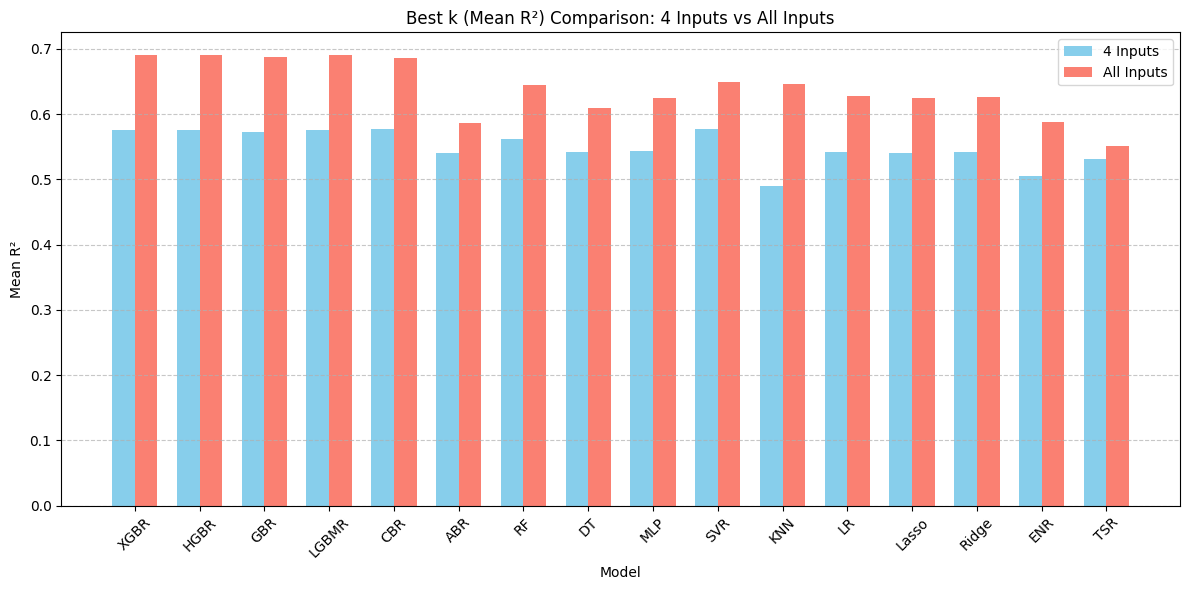

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for 4 Inputs
models_4 = ['XGBR', 'HGBR', 'GBR', 'LGBMR', 'CBR', 'ABR', 'RF', 'DT', 'MLP', 'SVR',
            'KNN', 'LR', 'Lasso', 'Ridge', 'ENR', 'TSR']
r2_4 = [0.575, 0.576, 0.573, 0.576, 0.577, 0.540, 0.562, 0.542, 0.543, 0.577,
        0.490, 0.542, 0.541, 0.542, 0.505, 0.532]

# Data for All Inputs
models_all = ['XGBR', 'HGBR', 'GBR', 'LGBMR', 'CBR', 'ABR', 'RF', 'DT', 'MLP', 'SVR',
              'KNN', 'LR', 'LaR', 'RiR', 'ENet', 'TSR']
r2_all = [0.6907, 0.6902, 0.6876, 0.6909, 0.6856, 0.5863, 0.6441, 0.6091, 0.6253, 0.6495,
          0.6464, 0.6273, 0.6252, 0.6270, 0.5874, 0.5519]

x = np.arange(len(models_4))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, r2_4, width, label='4 Inputs', color='skyblue')
bars2 = ax.bar(x + width/2, r2_all, width, label='All Inputs', color='salmon')

# Labels and formatting
ax.set_xlabel('Model')
ax.set_ylabel('Mean R²')
ax.set_title('Best k (Mean R²) Comparison: 4 Inputs vs All Inputs')
ax.set_xticks(x)
ax.set_xticklabels(models_4, rotation=45)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# LSTMS starting with Vanilla LSTM

This is for VLSTM, without the Training Time and Peak Memory Usage

In [ ]:
!pip install memory_profiler openpyxl


In [ ]:
!pip install tensorflow

In [ ]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers, activations
from memory_profiler import memory_usage
import time

# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io

data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

Saving dataset.xlsx to dataset.xlsx


This is for 70/30 split


--- Training LSTM: Optimizer=Adagrad, Activation=elu ---

--- Training LSTM: Optimizer=Adamax, Activation=selu ---

--- Training LSTM: Optimizer=Adam, Activation=relu ---

--- Training LSTM: Optimizer=Nadam, Activation=elu ---

--- Training LSTM: Optimizer=RMSprop, Activation=selu ---

--- Training LSTM: Optimizer=Adam, Activation=tanh ---

--- Training LSTM: Optimizer=SGD, Activation=softplus ---

--- Training LSTM: Optimizer=Adamax, Activation=tanh ---

--- Training LSTM: Optimizer=Adadelta, Activation=softplus ---


Optimizer Activation   Train_R2    Test_R2  Train_RMSE  Test_RMSE  \
2      Adam       relu   0.550563   0.559410    4.364488   4.386203   
1    Adamax       selu   0.545605   0.556193    4.388497   4.402186   
6       SGD   softplus   0.542069   0.551153    4.405538   4.427112   
4   RMSprop       selu   0.537503   0.545925    4.427447   4.452818   
3     Nadam        elu   0.537702   0.544727    4.426496   4.458691   
7    Adamax       tanh   0.527427   0.532850    4.475419   4.516472   
5      Adam       tanh   0.527396   0.532570    4.475564   4.517827   
8  Adadelta   softplus  -0.516303  -0.430812    8.016634   7.904285   
0   Adagrad        elu -36.282123 -34.965855   39.751118  39.629307   

   Train_MAE   Test_MAE  Train_MAPE  Test_MAPE    Train_MSE     Test_MSE  \
2   3.438367   3.401595    3.115103   3.066321    19.048754    19.238772   
1   3.458802   3.421257    3.136287   3.086593    19.258904    19.379237   
6   3.469012   3.445675    3.144921   3.107864    19.408768    19.599322   
4   3.479237   3.457678    3.152135   3.116643    19.602283    19.827589   
3   3.474810   3.457782    3.145138   3.113574    19.593868    19.879924   
7   3.515328   3.499494    3.183442   3.152150    20.029374    20.398521   
5   3.516575   3.501582    3.184669   3.154047    20.030672    20.410765   
8   6.346919   6.262553    5.761875   5.667247    64.266423    62.477721   
0  38.144820  38.043213   34.899492  34.702651  1580.151368  1570.482003   

   Training_Time_sec  Peak_Memory_MB  
2         239.869618      952.625000  
1         241.417177      939.636719  
6          31.661754     1056.878906  
4          82.373500     1013.925781  
3         174.339567      988.273438  
7         166.134163     1087.082031  
5         138.368329     1042.250000  
8         254.776181     1122.726562  
0         248.984995      911.453125


Best Pair (by Test MSE): ('Adam', 'relu')
Worst Pair (by Test MSE): ('Adagrad', 'elu')

Best training time (sec): 239.86961793899536
Best peak mem usage (MB): 952.625

Worst training time (sec): 248.98499488830566
Worst peak mem usage (MB): 911.453125


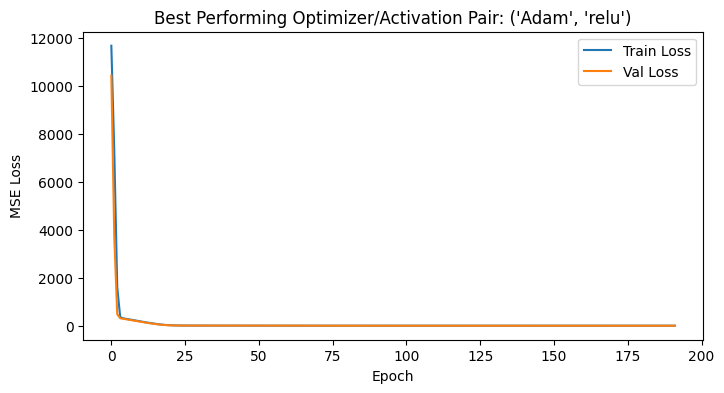


Best Performing Pair: Optimizer=Adam, Activation=relu
Train R2: 0.5505633045808963
Test  R2: 0.5594098556850847
Train RMSE: 4.3644878702814625
Test RMSE: 4.386202501588257
Train MAE: 3.438366896047012
Test  MAE: 3.401594809480208
Train MAPE: 3.1151030282779186
Test  MAPE: 3.066320991183664
Training Time (s): 239.86961793899536
Peak Memory (MB): 952.625


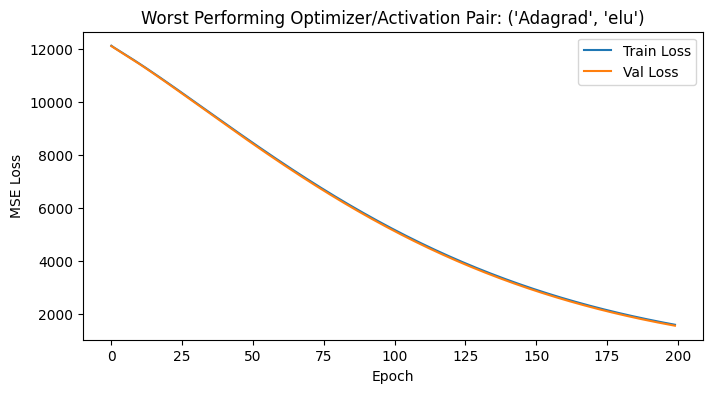


Worst Performing Pair: Optimizer=Adagrad, Activation=elu
Train R2: -36.282123287199624
Test  R2: -34.96585469929201
Train RMSE: 39.751117814823004
Test RMSE: 39.62930737024433
Train MAE: 38.14481979724224
Test  MAE: 38.043213296632146
Train MAPE: 34.8994924951553
Test  MAPE: 34.70265141106949
Training Time (s): 248.98499488830566
Peak Memory (MB): 911.453125


from matplotlib import pyplot as plt
_df_0['Train_R2'].plot(kind='hist', bins=20, title='Train_R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Test_R2'].plot(kind='hist', bins=20, title='Test_R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Train_RMSE'].plot(kind='hist', bins=20, title='Train_RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Test_RMSE'].plot(kind='hist', bins=20, title='Test_RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Optimizer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Activation').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Train_R2', y='Test_R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Test_R2', y='Train_RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Train_RMSE', y='Test_RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='Test_RMSE', y='Train_MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Test_RMSE']
  ys = series['Train_R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Test_RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Optimizer')):
  _plot_series(series, series_name, i)
  fig.legend(title='Optimizer', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Test_RMSE')
_ = plt.ylabel('Train_R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Test_RMSE']
  ys = series['Train_R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Test_RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Activation')):
  _plot_series(series, series_name, i)
  fig.legend(title='Activation', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Test_RMSE')
_ = plt.ylabel('Train_R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Test_RMSE']
  ys = series['Test_R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Test_RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Optimizer')):
  _plot_series(series, series_name, i)
  fig.legend(title='Optimizer', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Test_RMSE')
_ = plt.ylabel('Test_R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Test_RMSE']
  ys = series['Test_R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('Test_RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Activation')):
  _plot_series(series, series_name, i)
  fig.legend(title='Activation', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Test_RMSE')
_ = plt.ylabel('Test_R2')

from matplotlib import pyplot as plt
_df_14['Train_R2'].plot(kind='line', figsize=(8, 4), title='Train_R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Test_R2'].plot(kind='line', figsize=(8, 4), title='Test_R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Train_RMSE'].plot(kind='line', figsize=(8, 4), title='Train_RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Test_RMSE'].plot(kind='line', figsize=(8, 4), title='Test_RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Activation'].value_counts()
    for x_label, grp in _df_18.groupby('Optimizer')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Optimizer')
_ = plt.ylabel('Activation')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Optimizer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Train_R2', y='Optimizer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Activation'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Train_R2', y='Activation', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['Optimizer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='Test_R2', y='Optimizer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['Activation'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='Test_R2', y='Activation', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# BASIC CLEANING & FEATURE ENGINEERING
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

# OUTLIER REMOVAL
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']

# NORMALIZATION
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, shuffle=True)

# LSTM INPUT SHAPE ADAPTATION
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM  = np.expand_dims(X_test.values, axis=1)

# OPTIMIZER/ACTIVATION PAIRS
pairs = [
    ('Adagrad', 'elu'),
    ('Adamax' , 'selu'),
    ('Adam'   , 'relu'),
    ('Nadam'  , 'elu'),
    ('RMSprop', 'selu'),
    ('Adam'   , 'tanh'),
    ('SGD'    , 'softplus'),
    ('Adamax' , 'tanh'),
    ('Adadelta', 'softplus')
]

def train_lstm_with_profile(X_train_LSTM, y_train, X_test_LSTM, opt_name, act_name):
    optimizer = getattr(optimizers, opt_name)()
    activation = act_name
    model = Sequential([
        Input(shape=(1, X_train_LSTM.shape[2])),
        LSTM(200, activation=activation),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )

    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage # In MB
    return model, history, training_time, peak_memory

results = []
histories = {}

for opt_name, act_name in pairs:
    print(f"\n--- Training LSTM: Optimizer={opt_name}, Activation={act_name} ---")
    model, history, training_time, peak_memory = train_lstm_with_profile(
        X_train_LSTM, y_train, X_test_LSTM, opt_name, act_name
    )
    histories[(opt_name, act_name)] = history

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test  = model.predict(X_test_LSTM,  verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2  = r2_score(y_test , y_pred_test )

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test , y_pred_test ))
    train_mae  = mean_absolute_error(y_train, y_pred_train)
    test_mae   = mean_absolute_error(y_test , y_pred_test )
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape  = np.mean(np.abs((y_test  - y_pred_test ) / y_test )) * 100

    results.append({
        'Optimizer': opt_name,
        'Activation': act_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape,
        'Train_MSE': mean_squared_error(y_train, y_pred_train),
        'Test_MSE' : mean_squared_error(y_test, y_pred_test),
        'Training_Time_sec': training_time,
        'Peak_Memory_MB': peak_memory
    })

# RESULTS TABLE
results_df = pd.DataFrame(results)
display(results_df.sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])
print("\nBest Pair (by Test MSE):", best_pair)
print("Worst Pair (by Test MSE):", worst_pair)
print("\nBest training time (sec):", results_df.loc[best_idx, "Training_Time_sec"])
print("Best peak mem usage (MB):", results_df.loc[best_idx, "Peak_Memory_MB"])
print("\nWorst training time (sec):", results_df.loc[worst_idx, "Training_Time_sec"])
print("Worst peak mem usage (MB):", results_df.loc[worst_idx, "Peak_Memory_MB"])

# Loss plots for Best and Worst
for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print("Train R2:", results_df.loc[idx, 'Train_R2'].values[0])
    print("Test  R2:", results_df.loc[idx, 'Test_R2'].values[0])
    print("Train RMSE:", results_df.loc[idx, 'Train_RMSE'].values[0])
    print("Test RMSE:", results_df.loc[idx, 'Test_RMSE'].values[0])
    print("Train MAE:", results_df.loc[idx, 'Train_MAE'].values[0])
    print("Test  MAE:", results_df.loc[idx, 'Test_MAE'].values[0])
    print("Train MAPE:", results_df.loc[idx, 'Train_MAPE'].values[0])
    print("Test  MAPE:", results_df.loc[idx, 'Test_MAPE'].values[0])
    print("Training Time (s):", results_df.loc[idx, 'Training_Time_sec'].values[0])
    print("Peak Memory (MB):", results_df.loc[idx, 'Peak_Memory_MB'].values[0])

Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
2      Adam       relu     0.551    0.559       4.364      4.386      3.438   
1    Adamax       selu     0.546    0.556       4.388      4.402      3.459   
6       SGD   softplus     0.542    0.551       4.406      4.427      3.469   
4   RMSprop       selu     0.538    0.546       4.427      4.453      3.479   
3     Nadam        elu     0.538    0.545       4.426      4.459      3.475   
7    Adamax       tanh     0.527    0.533       4.475      4.516      3.515   
5      Adam       tanh     0.527    0.533       4.476      4.518      3.517   
8  Adadelta   softplus    -0.516   -0.431       8.017      7.904      6.347   
0   Adagrad        elu   -36.282  -34.966      39.751     39.629     38.145   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
2     3.402       3.115      3.066     19.049    19.239            239.870   
1     3.421       3.136      3.087     19.259    19.379            241.417   
6     3.446       3.145      3.108     19.409    19.599             31.662   
4     3.458       3.152      3.117     19.602    19.828             82.373   
3     3.458       3.145      3.114     19.594    19.880            174.340   
7     3.499       3.183      3.152     20.029    20.399            166.134   
5     3.502       3.185      3.154     20.031    20.411            138.368   
8     6.263       5.762      5.667     64.266    62.478            254.776   
0    38.043      34.899     34.703   1580.151  1570.482            248.985   

   Peak_Memory_MB  
2         952.625  
1         939.637  
6        1056.879  
4        1013.926  
3         988.273  
7        1087.082  
5        1042.250  
8        1122.727  
0         911.453


Best Pair (by Test MSE): ('Adam', 'relu')
Worst Pair (by Test MSE): ('Adagrad', 'elu')

Best training time (sec): 239.870
Best peak mem usage (MB): 952.625

Worst training time (sec): 248.985
Worst peak mem usage (MB): 911.453


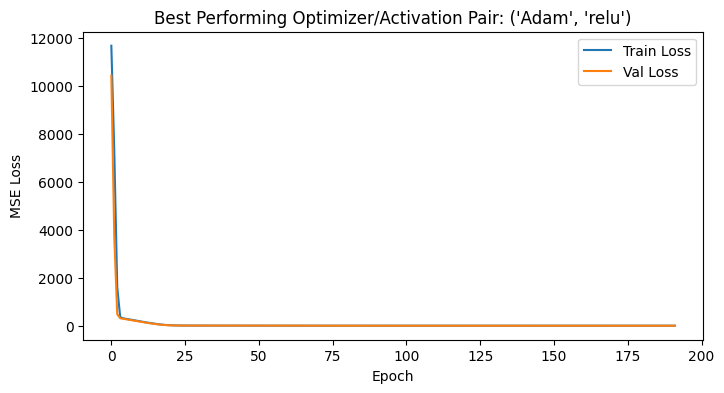


Best Performing Pair: Optimizer=Adam, Activation=relu
Train R2:    0.551
Test  R2:    0.559
Train RMSE:  4.364
Test  RMSE:  4.386
Train MAE:   3.438
Test  MAE:   3.402
Train MAPE:  3.115
Test  MAPE:  3.066
Train MSE:   19.049
Test  MSE:   19.239
Training Time (s): 239.870
Peak Memory (MB): 952.625


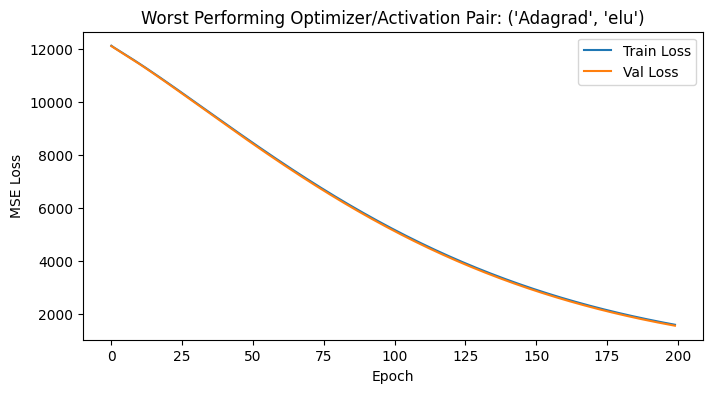


Worst Performing Pair: Optimizer=Adagrad, Activation=elu
Train R2:    -36.282
Test  R2:    -34.966
Train RMSE:  39.751
Test  RMSE:  39.629
Train MAE:   38.145
Test  MAE:   38.043
Train MAPE:  34.899
Test  MAPE:  34.703
Train MSE:   1580.151
Test  MSE:   1570.482
Training Time (s): 248.985
Peak Memory (MB): 911.453


In [ ]:
# RESULTS TABLE (rounded to 3 decimals)
results_df = pd.DataFrame(results)

# Display the table rounded to 3 decimals
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

# Loss plots for Best and Worst
for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))

This is for 80:20 split

In [ ]:
# BASIC CLEANING & FEATURE ENGINEERING
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

# OUTLIER REMOVAL
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']

# NORMALIZATION
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

# LSTM INPUT SHAPE ADAPTATION
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM  = np.expand_dims(X_test.values, axis=1)

# OPTIMIZER/ACTIVATION PAIRS
pairs = [
    ('Adagrad', 'elu'),
    ('Adamax' , 'selu'),
    ('Adam'   , 'relu'),
    ('Nadam'  , 'elu'),
    ('RMSprop', 'selu'),
    ('Adam'   , 'tanh'),
    ('SGD'    , 'softplus'),
    ('Adamax' , 'tanh'),
    ('Adadelta', 'softplus')
]

def train_lstm_with_profile(X_train_LSTM, y_train, X_test_LSTM, opt_name, act_name):
    optimizer = getattr(optimizers, opt_name)()
    activation = act_name
    model = Sequential([
        Input(shape=(1, X_train_LSTM.shape[2])),
        LSTM(200, activation=activation),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )

    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage # In MB
    return model, history, training_time, peak_memory

results = []
histories = {}

for opt_name, act_name in pairs:
    print(f"\n--- Training LSTM: Optimizer={opt_name}, Activation={act_name} ---")
    model, history, training_time, peak_memory = train_lstm_with_profile(
        X_train_LSTM, y_train, X_test_LSTM, opt_name, act_name
    )
    histories[(opt_name, act_name)] = history

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test  = model.predict(X_test_LSTM,  verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2  = r2_score(y_test , y_pred_test )

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test , y_pred_test ))
    train_mae  = mean_absolute_error(y_train, y_pred_train)
    test_mae   = mean_absolute_error(y_test , y_pred_test )
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape  = np.mean(np.abs((y_test  - y_pred_test ) / y_test )) * 100

    results.append({
        'Optimizer': opt_name,
        'Activation': act_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape,
        'Train_MSE': mean_squared_error(y_train, y_pred_train),
        'Test_MSE' : mean_squared_error(y_test, y_pred_test),
        'Training_Time_sec': training_time,
        'Peak_Memory_MB': peak_memory
    })



--- Training LSTM: Optimizer=Adagrad, Activation=elu ---

--- Training LSTM: Optimizer=Adamax, Activation=selu ---

--- Training LSTM: Optimizer=Adam, Activation=relu ---

--- Training LSTM: Optimizer=Nadam, Activation=elu ---

--- Training LSTM: Optimizer=RMSprop, Activation=selu ---

--- Training LSTM: Optimizer=Adam, Activation=tanh ---

--- Training LSTM: Optimizer=SGD, Activation=softplus ---

--- Training LSTM: Optimizer=Adamax, Activation=tanh ---

--- Training LSTM: Optimizer=Adadelta, Activation=softplus ---


Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
2      Adam       relu     0.551    0.568       4.364      4.369      3.435   
4   RMSprop       selu     0.543    0.561       4.406      4.404      3.462   
6       SGD   softplus     0.541    0.558       4.412      4.415      3.469   
3     Nadam        elu     0.538    0.556       4.426      4.429      3.475   
1    Adamax       selu     0.538    0.555       4.428      4.431      3.475   
7    Adamax       tanh     0.528    0.546       4.476      4.479      3.513   
5      Adam       tanh     0.525    0.544       4.489      4.488      3.524   
8  Adadelta   softplus    -1.016   -0.901       9.250      9.160      7.340   
0   Adagrad        elu   -25.933  -24.338      33.806     33.445     31.506   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
2     3.382       3.112      3.049     19.048    19.092            187.854   
4     3.411       3.134      3.073     19.411    19.395            301.030   
6     3.424       3.142      3.086     19.465    19.493             34.452   
3     3.428       3.145      3.087     19.593    19.617            283.023   
1     3.427       3.145      3.086     19.611    19.631            183.996   
7     3.468       3.180      3.123     20.035    20.059            272.795   
5     3.475       3.191      3.130     20.151    20.139            126.824   
8     7.304       6.662      6.608     85.558    83.903            297.009   
0    31.128      28.892     28.474   1142.824  1118.563            261.097   

   Peak_Memory_MB  
2         915.695  
4         978.109  
6        1015.930  
3         950.582  
1         885.016  
7        1047.988  
5        1000.840  
8        1080.160  
0         852.195


Best Pair (by Test MSE): ('Adam', 'relu')
Worst Pair (by Test MSE): ('Adagrad', 'elu')

Best training time (sec): 187.854
Best peak mem usage (MB): 915.695

Worst training time (sec): 261.097
Worst peak mem usage (MB): 852.195


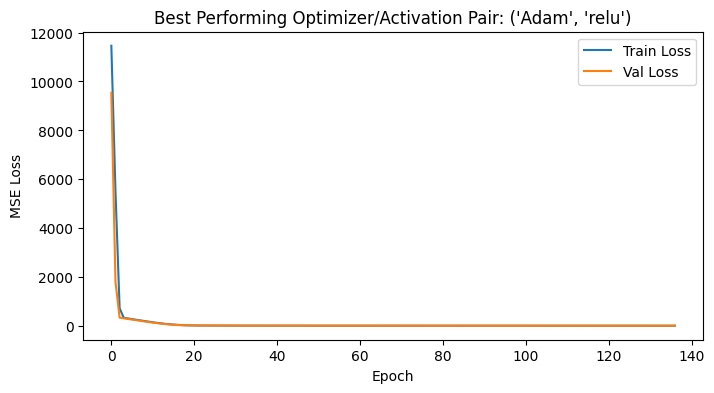


Best Performing Pair: Optimizer=Adam, Activation=relu
Train R2:    0.551
Test  R2:    0.568
Train RMSE:  4.364
Test  RMSE:  4.369
Train MAE:   3.435
Test  MAE:   3.382
Train MAPE:  3.112
Test  MAPE:  3.049
Train MSE:   19.048
Test  MSE:   19.092
Training Time (s): 187.854
Peak Memory (MB): 915.695


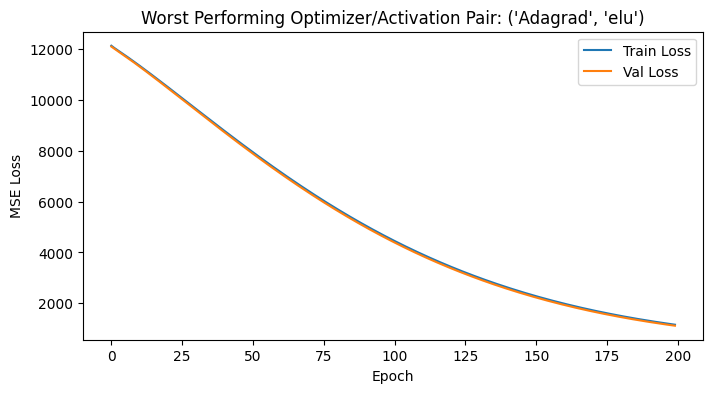


Worst Performing Pair: Optimizer=Adagrad, Activation=elu
Train R2:    -25.933
Test  R2:    -24.338
Train RMSE:  33.806
Test  RMSE:  33.445
Train MAE:   31.506
Test  MAE:   31.128
Train MAPE:  28.892
Test  MAPE:  28.474
Train MSE:   1142.824
Test  MSE:   1118.563
Training Time (s): 261.097
Peak Memory (MB): 852.195


In [ ]:
# RESULTS TABLE (rounded to 3 decimals for clarity!)
results_df = pd.DataFrame(results)

# Display the table rounded to 3 decimals
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

# Loss plots for Best and Worst
for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))

This adds the curves of train, test and val to the plots for 70:30 train-test split. SO THIS WAS USED

In [ ]:
# BASIC CLEANING & FEATURE ENGINEERING
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

# OUTLIER REMOVAL
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, shuffle=True)

# LSTM INPUT SHAPE ADAPTATION
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM  = np.expand_dims(X_test.values, axis=1)

# OPTIMIZER/ACTIVATION PAIRS
pairs = [
    ('Adamax' , 'selu'),
    ('Adam'   , 'relu'),
    ('Nadam'  , 'elu'),
    ('RMSprop', 'selu'),
    ('Adam'   , 'tanh'),
    ('SGD'    , 'softplus'),
    ('Adamax' , 'tanh')
]

def train_lstm_with_profile(X_train_LSTM, y_train, X_test_LSTM, opt_name, act_name):
    optimizer = getattr(optimizers, opt_name)()
    activation = act_name
    model = Sequential([
        Input(shape=(1, X_train_LSTM.shape[2])),
        LSTM(200, activation=activation),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )
    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage # MB
    return model, history, training_time, peak_memory

results = []
histories = {}
models = {}

for opt_name, act_name in pairs:
    print(f"\n--- Training LSTM: Optimizer={opt_name}, Activation={act_name} ---")
    model, history, training_time, peak_memory = train_lstm_with_profile(
        X_train_LSTM, y_train, X_test_LSTM, opt_name, act_name
    )
    histories[(opt_name, act_name)] = history
    models[(opt_name, act_name)] = model

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test  = model.predict(X_test_LSTM,  verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2  = r2_score(y_test , y_pred_test )
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test , y_pred_test ))
    train_mae  = mean_absolute_error(y_train, y_pred_train)
    test_mae   = mean_absolute_error(y_test , y_pred_test )
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape  = np.mean(np.abs((y_test  - y_pred_test ) / y_test )) * 100

    results.append({
        'Optimizer': opt_name,
        'Activation': act_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape,
        'Train_MSE': mean_squared_error(y_train, y_pred_train),
        'Test_MSE' : mean_squared_error(y_test, y_pred_test),
        'Training_Time_sec': training_time,
        'Peak_Memory_MB': peak_memory
    })




--- Training LSTM: Optimizer=Adamax, Activation=selu ---

--- Training LSTM: Optimizer=Adam, Activation=relu ---

--- Training LSTM: Optimizer=Nadam, Activation=elu ---

--- Training LSTM: Optimizer=RMSprop, Activation=selu ---

--- Training LSTM: Optimizer=Adam, Activation=tanh ---

--- Training LSTM: Optimizer=SGD, Activation=softplus ---

--- Training LSTM: Optimizer=Adamax, Activation=tanh ---


Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
1      Adam       relu     0.550    0.560       4.367      4.384      3.444   
0    Adamax       selu     0.545    0.555       4.392      4.410      3.458   
5       SGD   softplus     0.542    0.549       4.408      4.438      3.462   
2     Nadam        elu     0.539    0.546       4.423      4.454      3.474   
3   RMSprop       selu     0.537    0.544       4.430      4.463      3.476   
4      Adam       tanh     0.531    0.537       4.456      4.496      3.502   
6    Adamax       tanh     0.529    0.534       4.468      4.513      3.510   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
1     3.406       3.121      3.071     19.070    19.219            120.346   
0     3.425       3.134      3.089     19.291    19.447            246.895   
5     3.448       3.134      3.106     19.431    19.698             34.234   
2     3.455       3.145      3.112     19.560    19.834            189.481   
3     3.460       3.145      3.115     19.625    19.915             86.599   
4     3.488       3.172      3.143     19.858    20.214            253.318   
6     3.497       3.179      3.149     19.960    20.367            262.084   

   Peak_Memory_MB  
1         879.258  
0         848.398  
5         981.789  
2         914.941  
3         940.207  
4         965.469  
6        1012.625


Best Pair (by Test MSE): ('Adam', 'relu')
Worst Pair (by Test MSE): ('Adamax', 'tanh')

Best training time (sec): 120.346
Best peak mem usage (MB): 879.258

Worst training time (sec): 262.084
Worst peak mem usage (MB): 1012.625


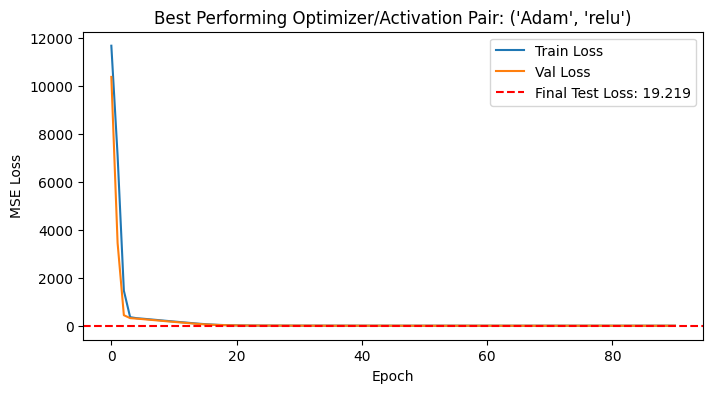


Best Performing Pair: Optimizer=Adam, Activation=relu
Train R2:    0.550
Test  R2:    0.560
Train RMSE:  4.367
Test  RMSE:  4.384
Train MAE:   3.444
Test  MAE:   3.406
Train MAPE:  3.121
Test  MAPE:  3.071
Train MSE:   19.070
Test  MSE:   19.219
Training Time (s): 120.346
Peak Memory (MB): 879.258


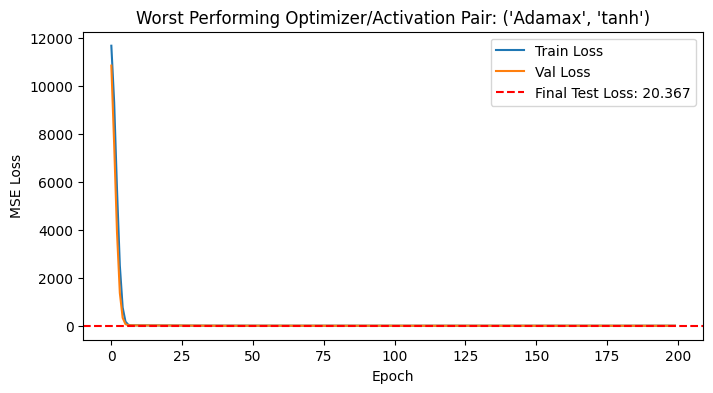


Worst Performing Pair: Optimizer=Adamax, Activation=tanh
Train R2:    0.529
Test  R2:    0.534
Train RMSE:  4.468
Test  RMSE:  4.513
Train MAE:   3.510
Test  MAE:   3.497
Train MAPE:  3.179
Test  MAPE:  3.149
Train MSE:   19.960
Test  MSE:   20.367
Training Time (s): 262.084
Peak Memory (MB): 1012.625


In [ ]:
# RESULTS TABLE (rounded to 3 decimals)
results_df = pd.DataFrame(results)
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

# PLOTS for Best and Worst, with final test loss added
for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    model = models[pair]
    test_loss = model.evaluate(X_test_LSTM, y_test, verbose=0)  # Final test MSE

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label=f'Final Test Loss: {test_loss:.3f}')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))


This is for 80:20 with the curves

In [ ]:
# --- 3. BASIC CLEANING & FEATURE ENGINEERING ---
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)


main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]

# OUTLIER REMOVAL
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

# LSTM INPUT SHAPE ADAPTATION
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM  = np.expand_dims(X_test.values, axis=1)

# OPTIMIZER/ACTIVATION PAIRS ---
pairs = [
    ('Adamax' , 'selu'),
    ('Adam'   , 'relu'),
    ('Nadam'  , 'elu'),
    ('RMSprop', 'selu'),
    ('Adam'   , 'tanh'),
    ('SGD'    , 'softplus'),
    ('Adamax' , 'tanh')
]

def train_lstm_with_profile(X_train_LSTM, y_train, X_test_LSTM, opt_name, act_name):
    optimizer = getattr(optimizers, opt_name)()
    activation = act_name
    model = Sequential([
        Input(shape=(1, X_train_LSTM.shape[2])),
        LSTM(200, activation=activation),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )
    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage # MB
    return model, history, training_time, peak_memory

results = []
histories = {}
models = {}

for opt_name, act_name in pairs:
    print(f"\n--- Training LSTM: Optimizer={opt_name}, Activation={act_name} ---")
    model, history, training_time, peak_memory = train_lstm_with_profile(
        X_train_LSTM, y_train, X_test_LSTM, opt_name, act_name
    )
    histories[(opt_name, act_name)] = history
    models[(opt_name, act_name)] = model

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test  = model.predict(X_test_LSTM,  verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2  = r2_score(y_test , y_pred_test )
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test , y_pred_test ))
    train_mae  = mean_absolute_error(y_train, y_pred_train)
    test_mae   = mean_absolute_error(y_test , y_pred_test )
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape  = np.mean(np.abs((y_test  - y_pred_test ) / y_test )) * 100

    results.append({
        'Optimizer': opt_name,
        'Activation': act_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape,
        'Train_MSE': mean_squared_error(y_train, y_pred_train),
        'Test_MSE' : mean_squared_error(y_test, y_pred_test),
        'Training_Time_sec': training_time,
        'Peak_Memory_MB': peak_memory
    })




--- Training LSTM: Optimizer=Adamax, Activation=selu ---

--- Training LSTM: Optimizer=Adam, Activation=relu ---

--- Training LSTM: Optimizer=Nadam, Activation=elu ---

--- Training LSTM: Optimizer=RMSprop, Activation=selu ---

--- Training LSTM: Optimizer=Adam, Activation=tanh ---

--- Training LSTM: Optimizer=SGD, Activation=softplus ---

--- Training LSTM: Optimizer=Adamax, Activation=tanh ---


Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
1      Adam       relu     0.552    0.570       4.361      4.357      3.435   
2     Nadam        elu     0.550    0.569       4.368      4.360      3.441   
0    Adamax       selu     0.546    0.565       4.388      4.381      3.453   
5       SGD   softplus     0.541    0.558       4.413      4.418      3.465   
3   RMSprop       selu     0.538    0.555       4.430      4.432      3.475   
6    Adamax       tanh     0.528    0.546       4.477      4.476      3.517   
4      Adam       tanh     0.527    0.544       4.481      4.486      3.516   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
1     3.375       3.112      3.043     19.014    18.983            169.072   
2     3.377       3.118      3.045     19.081    19.010            374.247   
0     3.394       3.127      3.059     19.254    19.197            365.620   
5     3.422       3.136      3.082     19.472    19.517             44.447   
3     3.428       3.145      3.087     19.621    19.643            113.951   
6     3.468       3.186      3.125     20.047    20.032            286.159   
4     3.472       3.182      3.126     20.082    20.122            183.069   

   Peak_Memory_MB  
1         884.055  
2         918.176  
0         848.441  
5         986.055  
3         940.312  
6        1016.684  
4         970.262


Best Pair (by Test MSE): ('Adam', 'relu')
Worst Pair (by Test MSE): ('Adam', 'tanh')

Best training time (sec): 169.072
Best peak mem usage (MB): 884.055

Worst training time (sec): 183.069
Worst peak mem usage (MB): 970.262


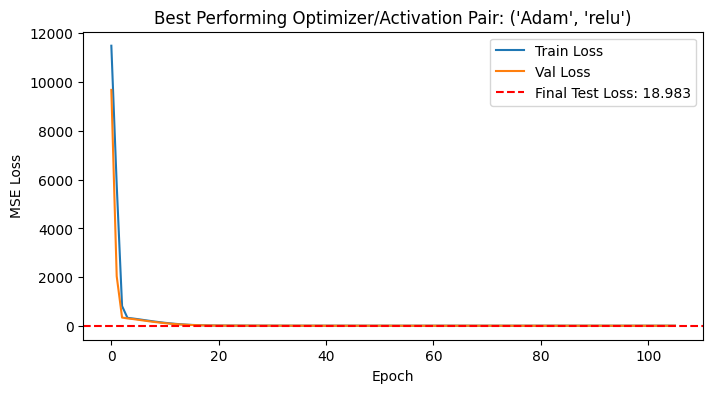


Best Performing Pair: Optimizer=Adam, Activation=relu
Train R2:    0.552
Test  R2:    0.570
Train RMSE:  4.361
Test  RMSE:  4.357
Train MAE:   3.435
Test  MAE:   3.375
Train MAPE:  3.112
Test  MAPE:  3.043
Train MSE:   19.014
Test  MSE:   18.983
Training Time (s): 169.072
Peak Memory (MB): 884.055


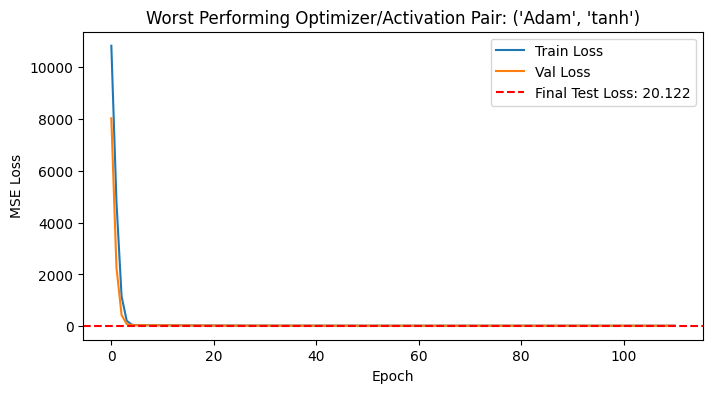


Worst Performing Pair: Optimizer=Adam, Activation=tanh
Train R2:    0.527
Test  R2:    0.544
Train RMSE:  4.481
Test  RMSE:  4.486
Train MAE:   3.516
Test  MAE:   3.472
Train MAPE:  3.182
Test  MAPE:  3.126
Train MSE:   20.082
Test  MSE:   20.122
Training Time (s): 183.069
Peak Memory (MB): 970.262


In [ ]:
# RESULTS TABLE (rounded to 3 decimals)
results_df = pd.DataFrame(results)
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

# PLOTS for Best and Worst, with final test loss added
for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    model = models[pair]
    test_loss = model.evaluate(X_test_LSTM, y_test, verbose=0)  # Final test MSE

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label=f'Final Test Loss: {test_loss:.3f}')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))


This is for All Inputs

In [ ]:
# BASIC CLEANING & FEATURE ENGINEERING
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

# OUTLIER REMOVAL
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

# LSTM INPUT SHAPE ADAPTATION
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM  = np.expand_dims(X_test.values, axis=1)

# OPTIMIZER/ACTIVATION PAIRS
pairs = [
    ('Adamax' , 'selu'),
    ('Adam'   , 'relu'),
    ('Nadam'  , 'elu'),
    ('RMSprop', 'selu'),
    ('Adam'   , 'tanh'),
    ('SGD'    , 'softplus'),
    ('Adamax' , 'tanh')
]

def train_lstm_with_profile(X_train_LSTM, y_train, X_test_LSTM, opt_name, act_name):
    optimizer = getattr(optimizers, opt_name)()
    activation = act_name
    model = Sequential([
        Input(shape=(1, X_train_LSTM.shape[2])),
        LSTM(200, activation=activation),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )
    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage # MB
    return model, history, training_time, peak_memory

results = []
histories = {}
models = {}

for opt_name, act_name in pairs:
    print(f"\n--- Training LSTM: Optimizer={opt_name}, Activation={act_name} ---")
    model, history, training_time, peak_memory = train_lstm_with_profile(
        X_train_LSTM, y_train, X_test_LSTM, opt_name, act_name
    )
    histories[(opt_name, act_name)] = history
    models[(opt_name, act_name)] = model

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test  = model.predict(X_test_LSTM,  verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2  = r2_score(y_test , y_pred_test )
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test , y_pred_test ))
    train_mae  = mean_absolute_error(y_train, y_pred_train)
    test_mae   = mean_absolute_error(y_test , y_pred_test )
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape  = np.mean(np.abs((y_test  - y_pred_test ) / y_test )) * 100

    results.append({
        'Optimizer': opt_name,
        'Activation': act_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape,
        'Train_MSE': mean_squared_error(y_train, y_pred_train),
        'Test_MSE' : mean_squared_error(y_test, y_pred_test),
        'Training_Time_sec': training_time,
        'Peak_Memory_MB': peak_memory
    })




--- Training LSTM: Optimizer=Adamax, Activation=selu ---

--- Training LSTM: Optimizer=Adam, Activation=relu ---

--- Training LSTM: Optimizer=Nadam, Activation=elu ---

--- Training LSTM: Optimizer=RMSprop, Activation=selu ---

--- Training LSTM: Optimizer=Adam, Activation=tanh ---

--- Training LSTM: Optimizer=SGD, Activation=softplus ---

--- Training LSTM: Optimizer=Adamax, Activation=tanh ---


Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
2     Nadam        elu     0.640    0.652       3.947      3.877      3.049   
4      Adam       tanh     0.637    0.651       3.963      3.881      3.060   
6    Adamax       tanh     0.634    0.648       3.981      3.897      3.080   
0    Adamax       selu     0.634    0.645       3.981      3.914      3.078   
1      Adam       relu     0.633    0.645       3.987      3.915      3.081   
3   RMSprop       selu     0.630    0.642       4.004      3.930      3.104   
5       SGD   softplus     0.627    0.638       4.019      3.952      3.117   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
2     2.988       2.746      2.691     15.577    15.027            228.067   
4     2.993       2.755      2.694     15.704    15.064            189.559   
6     3.010       2.776      2.713     15.847    15.184            258.389   
0     3.022       2.773      2.723     15.850    15.319            267.551   
1     3.020       2.777      2.721     15.892    15.326            126.606   
3     3.040       2.800      2.742     16.031    15.448             78.083   
5     3.056       2.814      2.759     16.153    15.616             47.068   

   Peak_Memory_MB  
2         911.680  
4         967.242  
6        1012.879  
0         847.547  
1         880.453  
3         938.379  
5         983.254


Best Pair (by Test MSE): ('Nadam', 'elu')
Worst Pair (by Test MSE): ('SGD', 'softplus')

Best training time (sec): 228.067
Best peak mem usage (MB): 911.680

Worst training time (sec): 47.068
Worst peak mem usage (MB): 983.254


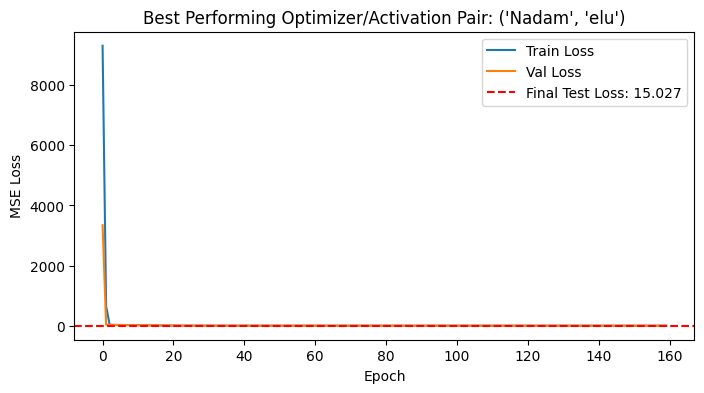


Best Performing Pair: Optimizer=Nadam, Activation=elu
Train R2:    0.640
Test  R2:    0.652
Train RMSE:  3.947
Test  RMSE:  3.877
Train MAE:   3.049
Test  MAE:   2.988
Train MAPE:  2.746
Test  MAPE:  2.691
Train MSE:   15.577
Test  MSE:   15.027
Training Time (s): 228.067
Peak Memory (MB): 911.680


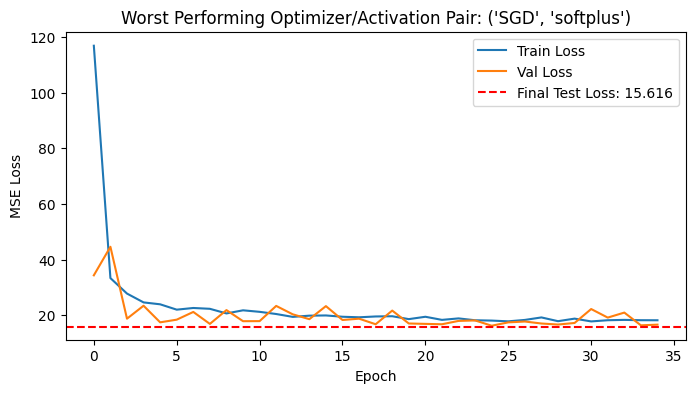


Worst Performing Pair: Optimizer=SGD, Activation=softplus
Train R2:    0.627
Test  R2:    0.638
Train RMSE:  4.019
Test  RMSE:  3.952
Train MAE:   3.117
Test  MAE:   3.056
Train MAPE:  2.814
Test  MAPE:  2.759
Train MSE:   16.153
Test  MSE:   15.616
Training Time (s): 47.068
Peak Memory (MB): 983.254


In [ ]:
# RESULTS TABLE (rounded to 3 decimals)
results_df = pd.DataFrame(results)
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

# PLOTS for Best and Worst, with final test loss added
for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    model = models[pair]
    test_loss = model.evaluate(X_test_LSTM, y_test, verbose=0)  # Final test MSE

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label=f'Final Test Loss: {test_loss:.3f}')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))

Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
2     Nadam        elu     0.640    0.652       3.947      3.877      3.049   
4      Adam       tanh     0.637    0.651       3.963      3.881      3.060   
6    Adamax       tanh     0.634    0.648       3.981      3.897      3.080   
0    Adamax       selu     0.634    0.645       3.981      3.914      3.078   
1      Adam       relu     0.633    0.645       3.987      3.915      3.081   
3   RMSprop       selu     0.630    0.642       4.004      3.930      3.104   
5       SGD   softplus     0.627    0.638       4.019      3.952      3.117   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
2     2.988       2.746      2.691     15.577    15.027            228.067   
4     2.993       2.755      2.694     15.704    15.064            189.559   
6     3.010       2.776      2.713     15.847    15.184            258.389   
0     3.022       2.773      2.723     15.850    15.319            267.551   
1     3.020       2.777      2.721     15.892    15.326            126.606   
3     3.040       2.800      2.742     16.031    15.448             78.083   
5     3.056       2.814      2.759     16.153    15.616             47.068   

   Peak_Memory_MB  
2         911.680  
4         967.242  
6        1012.879  
0         847.547  
1         880.453  
3         938.379  
5         983.254


Best Pair (by Test MSE): ('Nadam', 'elu')
Worst Pair (by Test MSE): ('SGD', 'softplus')

Best training time (sec): 228.067
Best peak mem usage (MB): 911.680

Worst training time (sec): 47.068
Worst peak mem usage (MB): 983.254


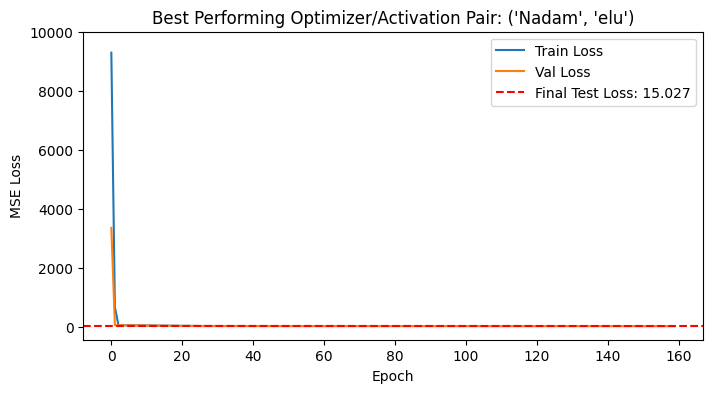


Best Performing Pair: Optimizer=Nadam, Activation=elu
Train R2:    0.640
Test  R2:    0.652
Train RMSE:  3.947
Test  RMSE:  3.877
Train MAE:   3.049
Test  MAE:   2.988
Train MAPE:  2.746
Test  MAPE:  2.691
Train MSE:   15.577
Test  MSE:   15.027
Training Time (s): 228.067
Peak Memory (MB): 911.680


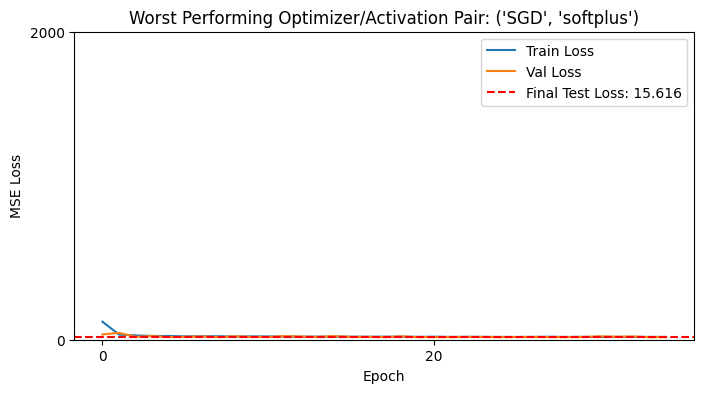


Worst Performing Pair: Optimizer=SGD, Activation=softplus
Train R2:    0.627
Test  R2:    0.638
Train RMSE:  4.019
Test  RMSE:  3.952
Train MAE:   3.117
Test  MAE:   3.056
Train MAPE:  2.814
Test  MAPE:  2.759
Train MSE:   16.153
Test  MSE:   15.616
Training Time (s): 47.068
Peak Memory (MB): 983.254


In [ ]:
# RESULTS TABLE (rounded to 3 decimals)
results_df = pd.DataFrame(results)
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    model = models[pair]
    test_loss = model.evaluate(X_test_LSTM, y_test, verbose=0)  # Final test MSE

    # Scale: x=0,20..., y=0,2000
    epochs_run = len(history.history['loss'])
    x_ticks = np.arange(0, epochs_run+1, 20)
    all_losses = history.history['loss'] + history.history['val_loss'] + [test_loss]
    max_y = int(np.ceil(np.max(all_losses)/2000))*2000 + 1
    y_ticks = np.arange(0, max_y, 2000)

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label=f'Final Test Loss: {test_loss:.3f}')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.legend()
    plt.show()

    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))

# LSTMS - Bidirectional LSTMs

In [ ]:
!pip install tensorflow memory_profiler openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

from memory_profiler import memory_usage
import time

# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

Saving dataset.xlsx to dataset.xlsx


This is for 70:30

In [ ]:
# BASIC CLEANING & FEATURE ENGINEERING
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

# OUTLIER REMOVAL
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, shuffle=True)
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM  = np.expand_dims(X_test.values, axis=1)

# OPTIMIZER/ACTIVATION PAIRS
pairs = [
    ('Adamax' , 'selu'),
    ('Adam'   , 'relu'),
    ('Nadam'  , 'elu'),
    ('RMSprop', 'selu'),
    ('Adam'   , 'tanh'),
    ('SGD'    , 'softplus'),
    ('Adamax' , 'tanh')
]

def train_bidirectional_lstm_with_profile(X_train_LSTM, y_train, opt_name, act_name):
    optimizer = getattr(optimizers, opt_name)()
    activation = act_name
    model = Sequential([
        Input(shape=(1, X_train_LSTM.shape[2])),
        Bidirectional(LSTM(200, activation=activation)),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )
    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage # MB
    return model, history, training_time, peak_memory

results, histories, models = [], {}, {}

for opt_name, act_name in pairs:
    print(f"\n--- Training Bidirectional LSTM: Optimizer={opt_name}, Activation={act_name} ---")
    model, history, training_time, peak_memory = train_bidirectional_lstm_with_profile(
        X_train_LSTM, y_train, opt_name, act_name
    )
    histories[(opt_name, act_name)] = history
    models[(opt_name, act_name)] = model

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test  = model.predict(X_test_LSTM,  verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2  = r2_score(y_test,  y_pred_test )
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test,  y_pred_test ))
    train_mae  = mean_absolute_error(y_train, y_pred_train)
    test_mae   = mean_absolute_error(y_test,  y_pred_test )
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape  = np.mean(np.abs((y_test  - y_pred_test ) / y_test )) * 100

    results.append({
        'Optimizer': opt_name,
        'Activation': act_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape,
        'Train_MSE': mean_squared_error(y_train, y_pred_train),
        'Test_MSE' : mean_squared_error(y_test, y_pred_test),
        'Training_Time_sec': training_time,
        'Peak_Memory_MB': peak_memory
    })


--- Training Bidirectional LSTM: Optimizer=Adamax, Activation=selu ---

--- Training Bidirectional LSTM: Optimizer=Adam, Activation=relu ---

--- Training Bidirectional LSTM: Optimizer=Nadam, Activation=elu ---

--- Training Bidirectional LSTM: Optimizer=RMSprop, Activation=selu ---

--- Training Bidirectional LSTM: Optimizer=Adam, Activation=tanh ---

--- Training Bidirectional LSTM: Optimizer=SGD, Activation=softplus ---

--- Training Bidirectional LSTM: Optimizer=Adamax, Activation=tanh ---


Inconsistent Scale

Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
1      Adam       relu     0.552    0.562       4.357      4.373      3.431   
2     Nadam        elu     0.550    0.561       4.365      4.377      3.441   
0    Adamax       selu     0.549    0.559       4.372      4.386      3.445   
5       SGD   softplus     0.542    0.551       4.405      4.428      3.462   
3   RMSprop       selu     0.539    0.547       4.421      4.447      3.476   
6    Adamax       tanh     0.534    0.540       4.444      4.480      3.491   
4      Adam       tanh     0.535    0.540       4.441      4.481      3.485   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
1     3.393       3.106      3.056     18.986    19.122            207.057   
2     3.395       3.117      3.060     19.054    19.158            394.682   
0     3.403       3.121      3.067     19.115    19.241            541.201   
5     3.441       3.135      3.101     19.400    19.611            113.243   
3     3.454       3.149      3.113     19.549    19.778            174.267   
6     3.473       3.161      3.129     19.752    20.074            365.109   
4     3.473       3.155      3.127     19.721    20.078            393.822   

   Peak_Memory_MB  
1         930.277  
2         989.648  
0         878.344  
5        1118.461  
3        1038.984  
6        1174.367  
4        1086.223


Best Pair (by Test MSE): ('Adam', 'relu')
Worst Pair (by Test MSE): ('Adam', 'tanh')

Best training time (sec): 207.057
Best peak mem usage (MB): 930.277

Worst training time (sec): 393.822
Worst peak mem usage (MB): 1086.223


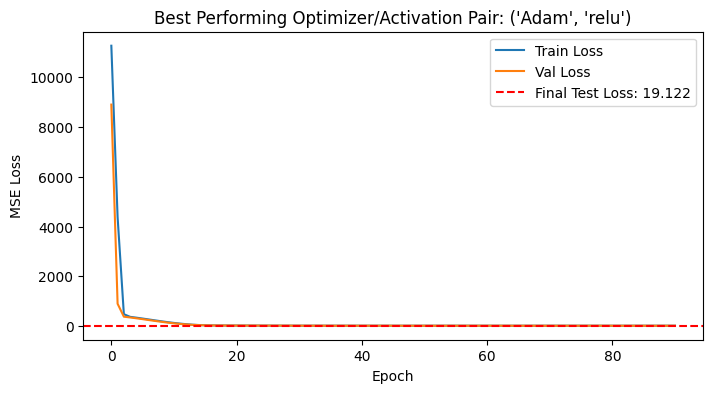


Best Performing Pair: Optimizer=Adam, Activation=relu
Train R2:    0.552
Test  R2:    0.562
Train RMSE:  4.357
Test  RMSE:  4.373
Train MAE:   3.431
Test  MAE:   3.393
Train MAPE:  3.106
Test  MAPE:  3.056
Train MSE:   18.986
Test  MSE:   19.122
Training Time (s): 207.057
Peak Memory (MB): 930.277


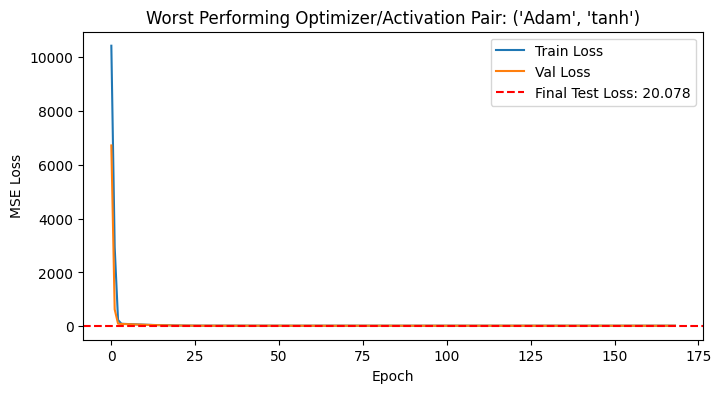


Worst Performing Pair: Optimizer=Adam, Activation=tanh
Train R2:    0.535
Test  R2:    0.540
Train RMSE:  4.441
Test  RMSE:  4.481
Train MAE:   3.485
Test  MAE:   3.473
Train MAPE:  3.155
Test  MAPE:  3.127
Train MSE:   19.721
Test  MSE:   20.078
Training Time (s): 393.822
Peak Memory (MB): 1086.223


In [ ]:
# RESULTS TABLE (rounded to 3 decimals)
results_df = pd.DataFrame(results)
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

# PLOTS for Best and Worst, with final test loss added
for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    model = models[pair]
    test_loss = model.evaluate(X_test_LSTM, y_test, verbose=0)  # Final test MSE

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label=f'Final Test Loss: {test_loss:.3f}')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))

Consistent Scale

Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
1      Adam       relu     0.552    0.562       4.357      4.373      3.431   
2     Nadam        elu     0.550    0.561       4.365      4.377      3.441   
0    Adamax       selu     0.549    0.559       4.372      4.386      3.445   
5       SGD   softplus     0.542    0.551       4.405      4.428      3.462   
3   RMSprop       selu     0.539    0.547       4.421      4.447      3.476   
6    Adamax       tanh     0.534    0.540       4.444      4.480      3.491   
4      Adam       tanh     0.535    0.540       4.441      4.481      3.485   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
1     3.393       3.106      3.056     18.986    19.122            207.057   
2     3.395       3.117      3.060     19.054    19.158            394.682   
0     3.403       3.121      3.067     19.115    19.241            541.201   
5     3.441       3.135      3.101     19.400    19.611            113.243   
3     3.454       3.149      3.113     19.549    19.778            174.267   
6     3.473       3.161      3.129     19.752    20.074            365.109   
4     3.473       3.155      3.127     19.721    20.078            393.822   

   Peak_Memory_MB  
1         930.277  
2         989.648  
0         878.344  
5        1118.461  
3        1038.984  
6        1174.367  
4        1086.223


Best Pair (by Test MSE): ('Adam', 'relu')
Worst Pair (by Test MSE): ('Adam', 'tanh')

Best training time (sec): 207.057
Best peak mem usage (MB): 930.277

Worst training time (sec): 393.822
Worst peak mem usage (MB): 1086.223


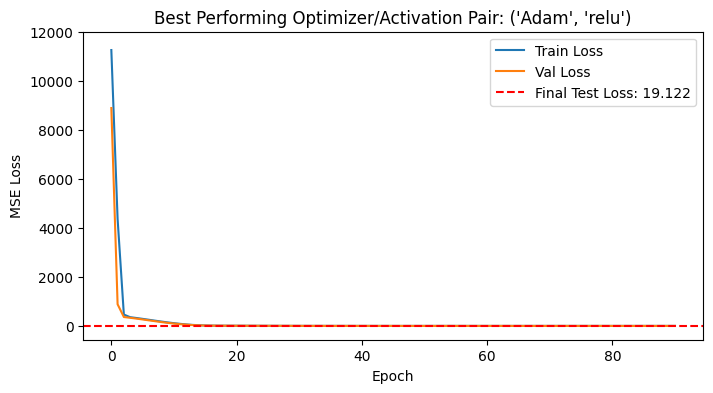


Best Performing Pair: Optimizer=Adam, Activation=relu
Train R2:    0.552
Test  R2:    0.562
Train RMSE:  4.357
Test  RMSE:  4.373
Train MAE:   3.431
Test  MAE:   3.393
Train MAPE:  3.106
Test  MAPE:  3.056
Train MSE:   18.986
Test  MSE:   19.122
Training Time (s): 207.057
Peak Memory (MB): 930.277


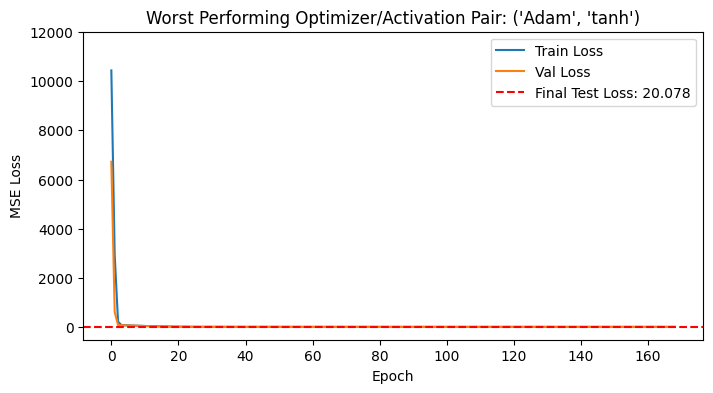


Worst Performing Pair: Optimizer=Adam, Activation=tanh
Train R2:    0.535
Test  R2:    0.540
Train RMSE:  4.441
Test  RMSE:  4.481
Train MAE:   3.485
Test  MAE:   3.473
Train MAPE:  3.155
Test  MAPE:  3.127
Train MSE:   19.721
Test  MSE:   20.078
Training Time (s): 393.822
Peak Memory (MB): 1086.223


In [ ]:
# RESULTS TABLE
results_df = pd.DataFrame(results)
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    model = models[pair]
    test_loss = model.evaluate(X_test_LSTM, y_test, verbose=0)  # Final test MSE

    # Scale: x=0,20..., y=0,2000
    epochs_run = len(history.history['loss'])
    x_ticks = np.arange(0, epochs_run+1, 20)
    all_losses = history.history['loss'] + history.history['val_loss'] + [test_loss]
    max_y = int(np.ceil(np.max(all_losses)/2000))*2000 + 1
    y_ticks = np.arange(0, max_y, 2000)

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label=f'Final Test Loss: {test_loss:.3f}')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.legend()
    plt.show()

    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))

THis is for 80:20 at 4 input features

In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]

# OUTLIER REMOVAL
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM  = np.expand_dims(X_test.values, axis=1)

# OPTIMIZER/ACTIVATION PAIRS
pairs = [
    ('Adamax' , 'selu'),
    ('Adam'   , 'relu'),
    ('Nadam'  , 'elu'),
    ('RMSprop', 'selu'),
    ('Adam'   , 'tanh'),
    ('SGD'    , 'softplus'),
    ('Adamax' , 'tanh')
]

def train_bidirectional_lstm_with_profile(X_train_LSTM, y_train, opt_name, act_name):
    optimizer = getattr(optimizers, opt_name)()
    activation = act_name
    model = Sequential([
        Input(shape=(1, X_train_LSTM.shape[2])),
        Bidirectional(LSTM(200, activation=activation)),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )
    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage # MB
    return model, history, training_time, peak_memory

results, histories, models = [], {}, {}

for opt_name, act_name in pairs:
    print(f"\n--- Training Bidirectional LSTM: Optimizer={opt_name}, Activation={act_name} ---")
    model, history, training_time, peak_memory = train_bidirectional_lstm_with_profile(
        X_train_LSTM, y_train, opt_name, act_name
    )
    histories[(opt_name, act_name)] = history
    models[(opt_name, act_name)] = model

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test  = model.predict(X_test_LSTM,  verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2  = r2_score(y_test,  y_pred_test )
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test,  y_pred_test ))
    train_mae  = mean_absolute_error(y_train, y_pred_train)
    test_mae   = mean_absolute_error(y_test,  y_pred_test )
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape  = np.mean(np.abs((y_test  - y_pred_test ) / y_test )) * 100

    results.append({
        'Optimizer': opt_name,
        'Activation': act_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape,
        'Train_MSE': mean_squared_error(y_train, y_pred_train),
        'Test_MSE' : mean_squared_error(y_test, y_pred_test),
        'Training_Time_sec': training_time,
        'Peak_Memory_MB': peak_memory
    })


--- Training Bidirectional LSTM: Optimizer=Adamax, Activation=selu ---

--- Training Bidirectional LSTM: Optimizer=Adam, Activation=relu ---

--- Training Bidirectional LSTM: Optimizer=Nadam, Activation=elu ---

--- Training Bidirectional LSTM: Optimizer=RMSprop, Activation=selu ---

--- Training Bidirectional LSTM: Optimizer=Adam, Activation=tanh ---

--- Training Bidirectional LSTM: Optimizer=SGD, Activation=softplus ---

--- Training Bidirectional LSTM: Optimizer=Adamax, Activation=tanh ---


Inconsistent Scale

Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
0    Adamax       selu     0.550    0.570       4.369      4.358      3.442   
1      Adam       relu     0.552    0.569       4.360      4.360      3.435   
2     Nadam        elu     0.550    0.569       4.371      4.363      3.441   
3   RMSprop       selu     0.540    0.559       4.419      4.414      3.477   
6    Adamax       tanh     0.533    0.551       4.452      4.453      3.494   
4      Adam       tanh     0.534    0.550       4.448      4.455      3.489   
5       SGD   softplus     0.534    0.546       4.449      4.476      3.493   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
0     3.375       3.119      3.044     19.086    18.990            505.160   
1     3.377       3.111      3.045     19.010    19.008            201.171   
2     3.378       3.116      3.045     19.109    19.038            265.746   
3     3.424       3.153      3.089     19.526    19.486            182.377   
6     3.447       3.164      3.105     19.816    19.829            351.282   
4     3.447       3.158      3.104     19.784    19.844            330.654   
5     3.472       3.161      3.126     19.792    20.033             47.783   

   Peak_Memory_MB  
0         887.086  
1         945.000  
2         998.375  
3        1045.070  
6        1183.090  
4        1092.852  
5        1130.637


Best Pair (by Test MSE): ('Adamax', 'selu')
Worst Pair (by Test MSE): ('SGD', 'softplus')

Best training time (sec): 505.160
Best peak mem usage (MB): 887.086

Worst training time (sec): 47.783
Worst peak mem usage (MB): 1130.637


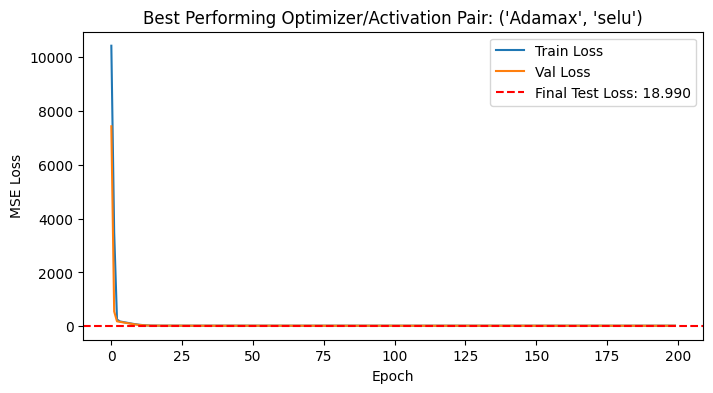


Best Performing Pair: Optimizer=Adamax, Activation=selu
Train R2:    0.550
Test  R2:    0.570
Train RMSE:  4.369
Test  RMSE:  4.358
Train MAE:   3.442
Test  MAE:   3.375
Train MAPE:  3.119
Test  MAPE:  3.044
Train MSE:   19.086
Test  MSE:   18.990
Training Time (s): 505.160
Peak Memory (MB): 887.086


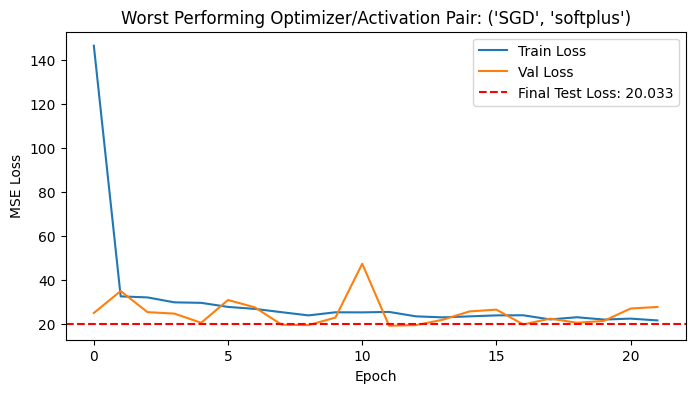


Worst Performing Pair: Optimizer=SGD, Activation=softplus
Train R2:    0.534
Test  R2:    0.546
Train RMSE:  4.449
Test  RMSE:  4.476
Train MAE:   3.493
Test  MAE:   3.472
Train MAPE:  3.161
Test  MAPE:  3.126
Train MSE:   19.792
Test  MSE:   20.033
Training Time (s): 47.783
Peak Memory (MB): 1130.637


In [ ]:
# RESULTS TABLE (rounded to 3 decimals)
results_df = pd.DataFrame(results)
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

# Plots for Best and Worst, with final test loss added
for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    model = models[pair]
    test_loss = model.evaluate(X_test_LSTM, y_test, verbose=0)  # Final test MSE

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label=f'Final Test Loss: {test_loss:.3f}')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))

Consistent Scale

Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
0    Adamax       selu     0.550    0.570       4.369      4.358      3.442   
1      Adam       relu     0.552    0.569       4.360      4.360      3.435   
2     Nadam        elu     0.550    0.569       4.371      4.363      3.441   
3   RMSprop       selu     0.540    0.559       4.419      4.414      3.477   
6    Adamax       tanh     0.533    0.551       4.452      4.453      3.494   
4      Adam       tanh     0.534    0.550       4.448      4.455      3.489   
5       SGD   softplus     0.534    0.546       4.449      4.476      3.493   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
0     3.375       3.119      3.044     19.086    18.990            505.160   
1     3.377       3.111      3.045     19.010    19.008            201.171   
2     3.378       3.116      3.045     19.109    19.038            265.746   
3     3.424       3.153      3.089     19.526    19.486            182.377   
6     3.447       3.164      3.105     19.816    19.829            351.282   
4     3.447       3.158      3.104     19.784    19.844            330.654   
5     3.472       3.161      3.126     19.792    20.033             47.783   

   Peak_Memory_MB  
0         887.086  
1         945.000  
2         998.375  
3        1045.070  
6        1183.090  
4        1092.852  
5        1130.637


Best Pair (by Test MSE): ('Adamax', 'selu')
Worst Pair (by Test MSE): ('SGD', 'softplus')

Best training time (sec): 505.160
Best peak mem usage (MB): 887.086

Worst training time (sec): 47.783
Worst peak mem usage (MB): 1130.637


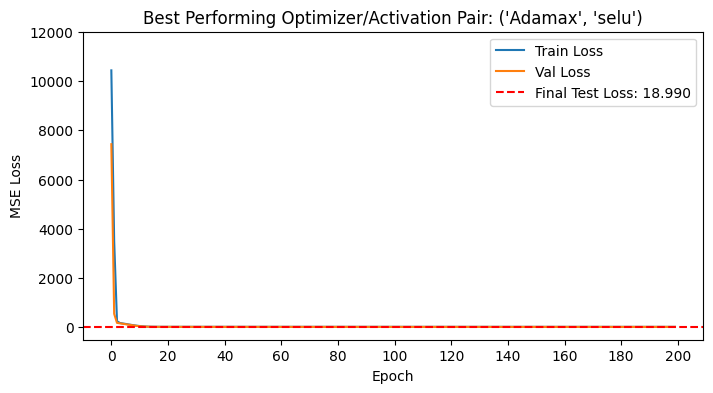


Best Performing Pair: Optimizer=Adamax, Activation=selu
Train R2:    0.550
Test  R2:    0.570
Train RMSE:  4.369
Test  RMSE:  4.358
Train MAE:   3.442
Test  MAE:   3.375
Train MAPE:  3.119
Test  MAPE:  3.044
Train MSE:   19.086
Test  MSE:   18.990
Training Time (s): 505.160
Peak Memory (MB): 887.086


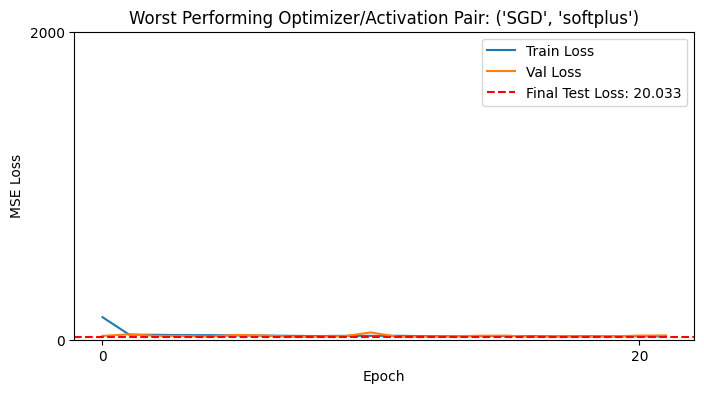


Worst Performing Pair: Optimizer=SGD, Activation=softplus
Train R2:    0.534
Test  R2:    0.546
Train RMSE:  4.449
Test  RMSE:  4.476
Train MAE:   3.493
Test  MAE:   3.472
Train MAPE:  3.161
Test  MAPE:  3.126
Train MSE:   19.792
Test  MSE:   20.033
Training Time (s): 47.783
Peak Memory (MB): 1130.637


In [ ]:
# RESULTS TABLE (rounded to 3 decimals)
results_df = pd.DataFrame(results)
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    model = models[pair]
    test_loss = model.evaluate(X_test_LSTM, y_test, verbose=0)  # Final test MSE

    # Scale: x=0,20..., y=0,2000
    epochs_run = len(history.history['loss'])
    x_ticks = np.arange(0, epochs_run+1, 20)
    all_losses = history.history['loss'] + history.history['val_loss'] + [test_loss]
    max_y = int(np.ceil(np.max(all_losses)/2000))*2000 + 1
    y_ticks = np.arange(0, max_y, 2000)

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label=f'Final Test Loss: {test_loss:.3f}')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.legend()
    plt.show()

    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))

This is for 80: 20 on all Input features

In [ ]:
# BASIC CLEANING & FEATURE ENGINEERING
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

# OUTLIER REMOVAL
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]

X = data[main_features]
y = data['Weight measurement']
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM  = np.expand_dims(X_test.values, axis=1)

# OPTIMIZER/ACTIVATION PAIRS
pairs = [
    ('Adamax' , 'selu'),
    ('Adam'   , 'relu'),
    ('Nadam'  , 'elu'),
    ('RMSprop', 'selu'),
    ('Adam'   , 'tanh'),
    ('SGD'    , 'softplus'),
    ('Adamax' , 'tanh')
]

def train_bidirectional_lstm_with_profile(X_train_LSTM, y_train, opt_name, act_name):
    optimizer = getattr(optimizers, opt_name)()
    activation = act_name
    model = Sequential([
        Input(shape=(1, X_train_LSTM.shape[2])),
        Bidirectional(LSTM(200, activation=activation)),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )
    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage # MB
    return model, history, training_time, peak_memory

results, histories, models = [], {}, {}

for opt_name, act_name in pairs:
    print(f"\n--- Training Bidirectional LSTM: Optimizer={opt_name}, Activation={act_name} ---")
    model, history, training_time, peak_memory = train_bidirectional_lstm_with_profile(
        X_train_LSTM, y_train, opt_name, act_name
    )
    histories[(opt_name, act_name)] = history
    models[(opt_name, act_name)] = model

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test  = model.predict(X_test_LSTM,  verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2  = r2_score(y_test,  y_pred_test )
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test,  y_pred_test ))
    train_mae  = mean_absolute_error(y_train, y_pred_train)
    test_mae   = mean_absolute_error(y_test,  y_pred_test )
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape  = np.mean(np.abs((y_test  - y_pred_test ) / y_test )) * 100

    results.append({
        'Optimizer': opt_name,
        'Activation': act_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape,
        'Train_MSE': mean_squared_error(y_train, y_pred_train),
        'Test_MSE' : mean_squared_error(y_test, y_pred_test),
        'Training_Time_sec': training_time,
        'Peak_Memory_MB': peak_memory
    })


--- Training Bidirectional LSTM: Optimizer=Adamax, Activation=selu ---

--- Training Bidirectional LSTM: Optimizer=Adam, Activation=relu ---

--- Training Bidirectional LSTM: Optimizer=Nadam, Activation=elu ---

--- Training Bidirectional LSTM: Optimizer=RMSprop, Activation=selu ---

--- Training Bidirectional LSTM: Optimizer=Adam, Activation=tanh ---

--- Training Bidirectional LSTM: Optimizer=SGD, Activation=softplus ---

--- Training Bidirectional LSTM: Optimizer=Adamax, Activation=tanh ---


Inconsistent Scale

Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
1      Adam       relu     0.661    0.669       3.832      3.777      2.947   
2     Nadam        elu     0.640    0.651       3.950      3.882      3.055   
4      Adam       tanh     0.637    0.651       3.964      3.882      3.060   
6    Adamax       tanh     0.636    0.649       3.969      3.890      3.064   
0    Adamax       selu     0.634    0.645       3.982      3.912      3.078   
3   RMSprop       selu     0.631    0.642       4.000      3.930      3.101   
5       SGD   softplus     0.628    0.638       4.013      3.955      3.104   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
1     2.908       2.655      2.619     14.687    14.266            299.523   
2     2.994       2.753      2.698     15.600    15.069            382.134   
4     2.989       2.754      2.689     15.710    15.073            289.290   
6     3.000       2.758      2.701     15.751    15.133            421.865   
0     3.020       2.773      2.721     15.853    15.307            512.210   
3     3.043       2.798      2.746     15.998    15.445            152.089   
5     3.057       2.796      2.753     16.106    15.646            129.390   

   Peak_Memory_MB  
1         943.215  
2         998.539  
4        1097.672  
6        1184.902  
0         887.195  
3        1044.387  
5        1130.004


Best Pair (by Test MSE): ('Adam', 'relu')
Worst Pair (by Test MSE): ('SGD', 'softplus')

Best training time (sec): 299.523
Best peak mem usage (MB): 943.215

Worst training time (sec): 129.390
Worst peak mem usage (MB): 1130.004


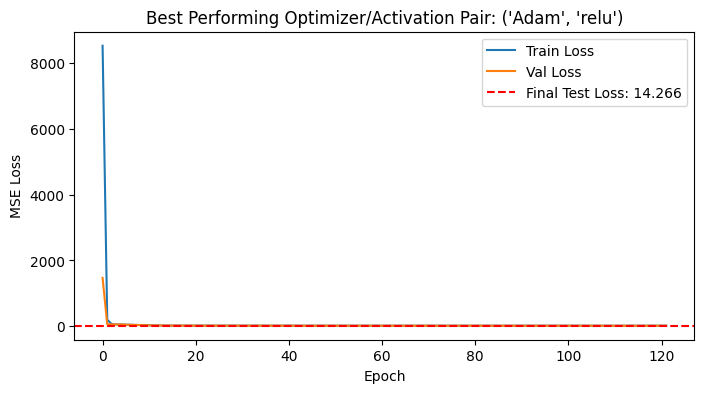


Best Performing Pair: Optimizer=Adam, Activation=relu
Train R2:    0.661
Test  R2:    0.669
Train RMSE:  3.832
Test  RMSE:  3.777
Train MAE:   2.947
Test  MAE:   2.908
Train MAPE:  2.655
Test  MAPE:  2.619
Train MSE:   14.687
Test  MSE:   14.266
Training Time (s): 299.523
Peak Memory (MB): 943.215


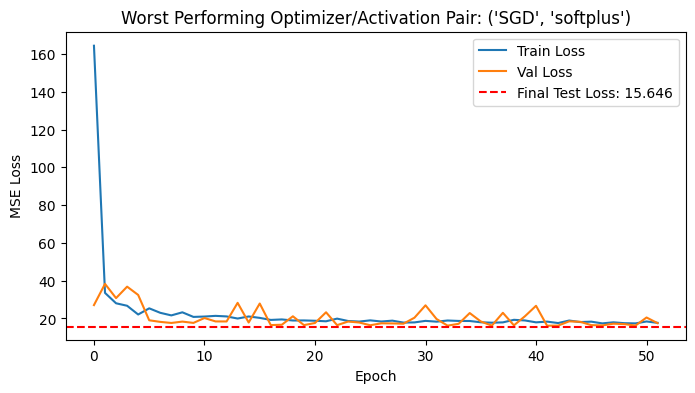


Worst Performing Pair: Optimizer=SGD, Activation=softplus
Train R2:    0.628
Test  R2:    0.638
Train RMSE:  4.013
Test  RMSE:  3.955
Train MAE:   3.104
Test  MAE:   3.057
Train MAPE:  2.796
Test  MAPE:  2.753
Train MSE:   16.106
Test  MSE:   15.646
Training Time (s): 129.390
Peak Memory (MB): 1130.004


In [ ]:
# RESULTS TABLE (rounded to 3 decimals)
results_df = pd.DataFrame(results)
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

# PLOTS for Best and Worst, with final test loss added
for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    model = models[pair]
    test_loss = model.evaluate(X_test_LSTM, y_test, verbose=0)  # Final test MSE

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label=f'Final Test Loss: {test_loss:.3f}')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))

Consistent Scale

Optimizer Activation  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  \
1      Adam       relu     0.661    0.669       3.832      3.777      2.947   
2     Nadam        elu     0.640    0.651       3.950      3.882      3.055   
4      Adam       tanh     0.637    0.651       3.964      3.882      3.060   
6    Adamax       tanh     0.636    0.649       3.969      3.890      3.064   
0    Adamax       selu     0.634    0.645       3.982      3.912      3.078   
3   RMSprop       selu     0.631    0.642       4.000      3.930      3.101   
5       SGD   softplus     0.628    0.638       4.013      3.955      3.104   

   Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  Training_Time_sec  \
1     2.908       2.655      2.619     14.687    14.266            299.523   
2     2.994       2.753      2.698     15.600    15.069            382.134   
4     2.989       2.754      2.689     15.710    15.073            289.290   
6     3.000       2.758      2.701     15.751    15.133            421.865   
0     3.020       2.773      2.721     15.853    15.307            512.210   
3     3.043       2.798      2.746     15.998    15.445            152.089   
5     3.057       2.796      2.753     16.106    15.646            129.390   

   Peak_Memory_MB  
1         943.215  
2         998.539  
4        1097.672  
6        1184.902  
0         887.195  
3        1044.387  
5        1130.004


Best Pair (by Test MSE): ('Adam', 'relu')
Worst Pair (by Test MSE): ('SGD', 'softplus')

Best training time (sec): 299.523
Best peak mem usage (MB): 943.215

Worst training time (sec): 129.390
Worst peak mem usage (MB): 1130.004


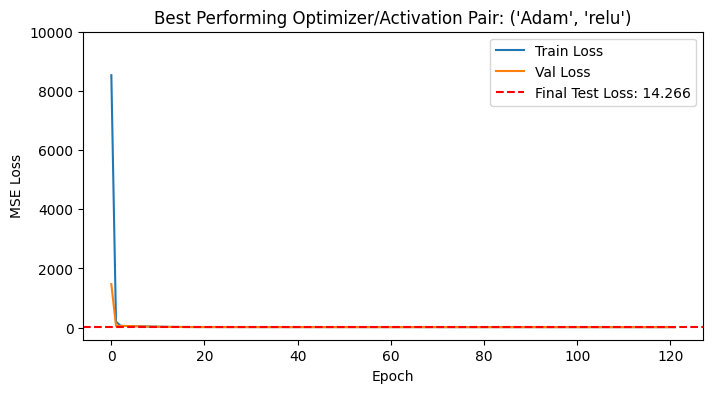


Best Performing Pair: Optimizer=Adam, Activation=relu
Train R2:    0.661
Test  R2:    0.669
Train RMSE:  3.832
Test  RMSE:  3.777
Train MAE:   2.947
Test  MAE:   2.908
Train MAPE:  2.655
Test  MAPE:  2.619
Train MSE:   14.687
Test  MSE:   14.266
Training Time (s): 299.523
Peak Memory (MB): 943.215


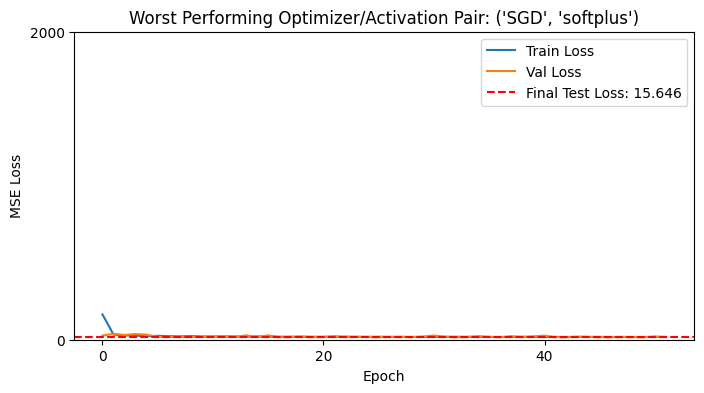


Worst Performing Pair: Optimizer=SGD, Activation=softplus
Train R2:    0.628
Test  R2:    0.638
Train RMSE:  4.013
Test  RMSE:  3.955
Train MAE:   3.104
Test  MAE:   3.057
Train MAPE:  2.796
Test  MAPE:  2.753
Train MSE:   16.106
Test  MSE:   15.646
Training Time (s): 129.390
Peak Memory (MB): 1130.004


In [ ]:
# RESULTS TABLE (rounded to 3 decimals)
results_df = pd.DataFrame(results)
display(results_df.round(3).sort_values('Test_MSE'))

# Best and Worst (by Test MSE)
best_idx = results_df['Test_MSE'].idxmin()
worst_idx = results_df['Test_MSE'].idxmax()
best_pair = (results_df.loc[best_idx, 'Optimizer'], results_df.loc[best_idx, 'Activation'])
worst_pair = (results_df.loc[worst_idx, 'Optimizer'], results_df.loc[worst_idx, 'Activation'])

print(f"\nBest Pair (by Test MSE): {best_pair}")
print(f"Worst Pair (by Test MSE): {worst_pair}")
print("\nBest training time (sec): {:.3f}".format(results_df.loc[best_idx, "Training_Time_sec"]))
print("Best peak mem usage (MB): {:.3f}".format(results_df.loc[best_idx, "Peak_Memory_MB"]))
print("\nWorst training time (sec): {:.3f}".format(results_df.loc[worst_idx, "Training_Time_sec"]))
print("Worst peak mem usage (MB): {:.3f}".format(results_df.loc[worst_idx, "Peak_Memory_MB"]))

for pair, label in zip([best_pair, worst_pair], ['Best', 'Worst']):
    history = histories[pair]
    model = models[pair]
    test_loss = model.evaluate(X_test_LSTM, y_test, verbose=0)  # Final test MSE

    # Scale: x=0,20..., y=0,2000
    epochs_run = len(history.history['loss'])
    x_ticks = np.arange(0, epochs_run+1, 20)
    all_losses = history.history['loss'] + history.history['val_loss'] + [test_loss]
    max_y = int(np.ceil(np.max(all_losses)/2000))*2000 + 1
    y_ticks = np.arange(0, max_y, 2000)

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label=f'Final Test Loss: {test_loss:.3f}')
    plt.title(f'{label} Performing Optimizer/Activation Pair: {pair}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.legend()
    plt.show()

    idx = (results_df['Optimizer'] == pair[0]) & (results_df['Activation'] == pair[1])
    print(f"\n{label} Performing Pair: Optimizer={pair[0]}, Activation={pair[1]}")
    print("Train R2:    {:.3f}".format(results_df.loc[idx, 'Train_R2'].values[0]))
    print("Test  R2:    {:.3f}".format(results_df.loc[idx, 'Test_R2'].values[0]))
    print("Train RMSE:  {:.3f}".format(results_df.loc[idx, 'Train_RMSE'].values[0]))
    print("Test  RMSE:  {:.3f}".format(results_df.loc[idx, 'Test_RMSE'].values[0]))
    print("Train MAE:   {:.3f}".format(results_df.loc[idx, 'Train_MAE'].values[0]))
    print("Test  MAE:   {:.3f}".format(results_df.loc[idx, 'Test_MAE'].values[0]))
    print("Train MAPE:  {:.3f}".format(results_df.loc[idx, 'Train_MAPE'].values[0]))
    print("Test  MAPE:  {:.3f}".format(results_df.loc[idx, 'Test_MAPE'].values[0]))
    print("Train MSE:   {:.3f}".format(results_df.loc[idx, 'Train_MSE'].values[0]))
    print("Test  MSE:   {:.3f}".format(results_df.loc[idx, 'Test_MSE'].values[0]))
    print("Training Time (s): {:.3f}".format(results_df.loc[idx, 'Training_Time_sec'].values[0]))
    print("Peak Memory (MB): {:.3f}".format(results_df.loc[idx, 'Peak_Memory_MB'].values[0]))

# PROPOSED LSTMs for Several Cases

In [ ]:
!pip install tensorflow memory_profiler openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import time
from memory_profiler import memory_usage
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

Saving dataset.xlsx to dataset.xlsx


In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]
X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True
)
X_train_LSTM = np.expand_dims(X_train.values, axis=1) # shape (n_samples, 1, 4)
X_test_LSTM  = np.expand_dims(X_test.values, axis=1)

# CASE DEFINITIONS
def build_bi_lstm_model(case_num, input_shape):
    model = Sequential()
    # First Bidirectional LSTM layer: always present
    model.add(Bidirectional(LSTM(128, activation="relu", return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    if case_num == 1:
        # Case 1: Adam, relu/elu/relu/selu/linear
        model.add(Bidirectional(LSTM(64, activation="elu", return_sequences=True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(32, activation="relu")))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation="selu"))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation="linear"))
        optimizer = tf.keras.optimizers.Adam()
    elif case_num == 2:
        # Case 2: Nadam, relu/elu/selu/linear
        model.add(Bidirectional(LSTM(64, activation="elu", return_sequences=True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(32, activation="relu")))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation="selu"))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation="linear"))
        optimizer = tf.keras.optimizers.Nadam()
    elif case_num == 3:
        # Case 3: Adam, relu/selu/linear
        model.add(Bidirectional(LSTM(64, activation="relu", return_sequences=True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(32, activation="relu")))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation="selu"))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation="linear"))
        optimizer = tf.keras.optimizers.Adam()
    elif case_num == 4:
        # Case 4: Nadam, relu/linear
        model.add(Bidirectional(LSTM(64, activation="relu", return_sequences=True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(32, activation="relu")))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation="linear"))
        optimizer = tf.keras.optimizers.Nadam()
    else:
        raise ValueError("Unknown case.")

    model.compile(optimizer=optimizer, loss="mse")
    return model

case_names = [
    "Case 1: Adam, relu/elu/relu/elu/linear",
    "Case 2: Nadam, elu/relu/relu/linear",
    "Case 3: Adam, relu/relu/selu/linear",
    "Case 4: Nadam, relu/relu/linear"
]

results = []
for case_num, case_name in enumerate(case_names, 1):
    print(f"\n--- Training {case_name} ---")
    model = build_bi_lstm_model(case_num, input_shape=(1, 4))
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )
    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage
    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test = model.predict(X_test_LSTM, verbose=0).flatten()
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    results.append({
        "Case": case_name,
        "Train_R2": train_r2,
        "Test_R2": test_r2,
        "Train_RMSE": train_rmse,
        "Test_RMSE": test_rmse,
        "Train_MAE": train_mae,
        "Test_MAE": test_mae,
        "Train_MAPE": train_mape,
        "Test_MAPE": test_mape,
        "Train_MSE": mean_squared_error(y_train, y_pred_train),
        "Test_MSE": mean_squared_error(y_test, y_pred_test),
        "Training_Time_sec": training_time,
        "Peak_Memory_MB": peak_memory
    })
    print(model.summary())

results_df = pd.DataFrame(results)
print("\n==== All Results (rounded to 3 decimals) ====")
print(results_df.round(3))


--- Training Case 1: Adam, relu/elu/relu/selu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,037,957 (3.96 MB)

 Trainable params: 345,985 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 691,972 (2.64 MB)

None

--- Training Case 2: Nadam, relu/elu/selu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 1, 256)         │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 1, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,037,958 (3.96 MB)

 Trainable params: 345,985 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 691,973 (2.64 MB)

None

--- Training Case 3: Adam, relu/selu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 1, 256)         │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 1, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,037,957 (3.96 MB)

 Trainable params: 345,985 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 691,972 (2.64 MB)

None

--- Training Case 4: Nadam, relu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (None, 1, 256)         │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 1, 128)         │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025,478 (3.91 MB)

 Trainable params: 341,825 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 683,653 (2.61 MB)

None

==== All Results (rounded to 3 decimals) ====
                                      Case  Train_R2  Test_R2  Train_RMSE  \
0  Case 1: Adam, relu/elu/relu/selu/linear     0.534    0.552       4.445   
1      Case 2: Nadam, relu/elu/selu/linear     0.539    0.553       4.418   
2           Case 3: Adam, relu/selu/linear     0.534    0.545       4.444   
3               Case 4: Nadam, relu/linear     0.547    0.558       4.381   

   Test_RMSE  Train_MAE  Test_MAE  Train_MAPE  Test_MAPE  Train_MSE  Test_MSE  \
0      4.425      3.528     3.472       3.217      3.152     19.759    19.578   
1      4.420      3.489     3.450       3.167      3.117     19.520    19.536   
2      4.455      3.486     3.454       3.149      3.104     19.747    19.847   
3      4.393      3.462     3.423       3.141      3.090     19.191    19.295   

   Training_Time_sec  Peak_Memory_MB  
0            118.544         994.895  
1             88.822        1162.672  
2             66.202        1234.359  


I changed the AFs and Optimzer

In [ ]:
!pip install tensorflow memory_profiler openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import time
from memory_profiler import memory_usage
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

import time
from memory_profiler import memory_usage

# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

Saving dataset.xlsx to dataset.xlsx


THis is for 0.3 test size on 4 features


--- Training Case 1: Adam & activations relu/relu/relu/elu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


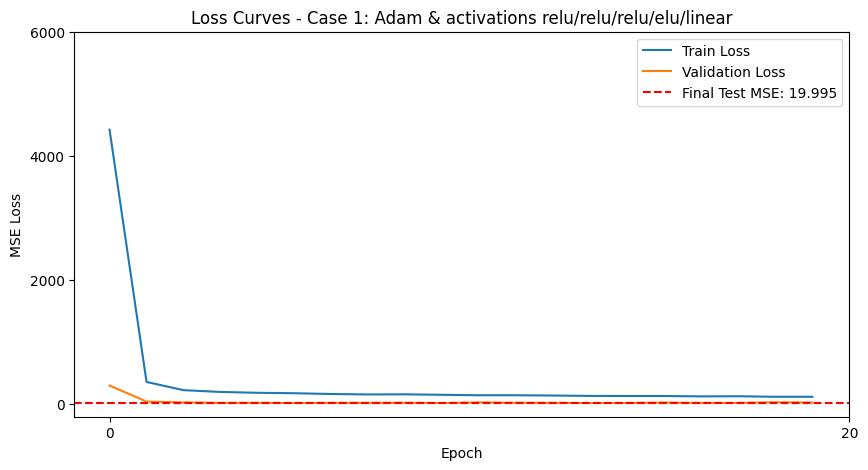


Results for Case 1: Adam & activations relu/relu/relu/elu/linear:
Train R2: 0.534, Test R2: 0.542
Train RMSE: 4.446, Test RMSE: 4.472
Train MAE: 3.493, Test MAE: 3.483
Train MAPE: 3.157%, Test MAPE: 3.133%
Training time (s): 81.48
Peak memory (MB): 987.43

--- Training Case 2: Nadam & activations relu/relu/relu/elu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


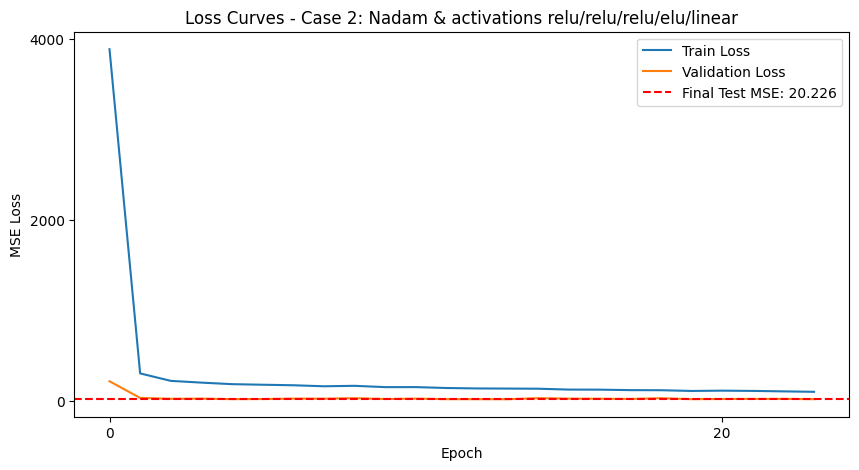


Results for Case 2: Nadam & activations relu/relu/relu/elu/linear:
Train R2: 0.525, Test R2: 0.537
Train RMSE: 4.487, Test RMSE: 4.497
Train MAE: 3.569, Test MAE: 3.544
Train MAPE: 3.249%, Test MAPE: 3.210%
Training time (s): 83.57
Peak memory (MB): 1157.40

--- Training Case 3: Adam & activations relu/ relu/ elu/selu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


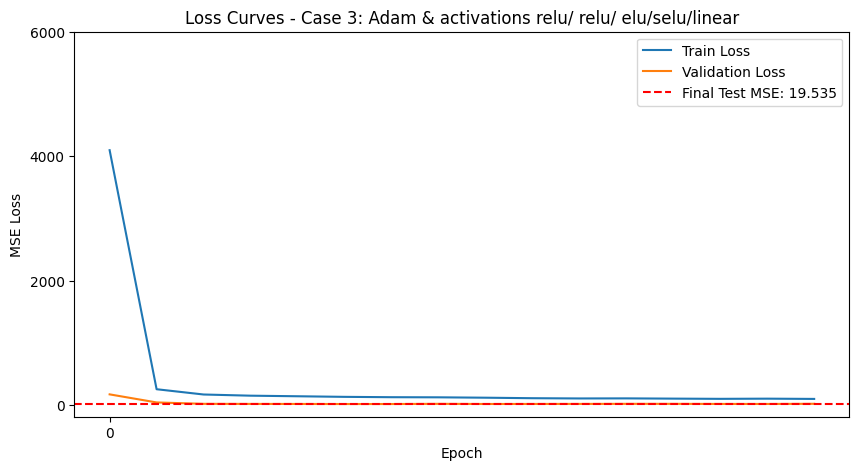


Results for Case 3: Adam & activations relu/ relu/ elu/selu/linear:
Train R2: 0.538, Test R2: 0.553
Train RMSE: 4.423, Test RMSE: 4.420
Train MAE: 3.468, Test MAE: 3.421
Train MAPE: 3.134%, Test MAPE: 3.078%
Training time (s): 60.45
Peak memory (MB): 1229.81

--- Training Case 4: Nadam & activations relu/ relu/ elu/selu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


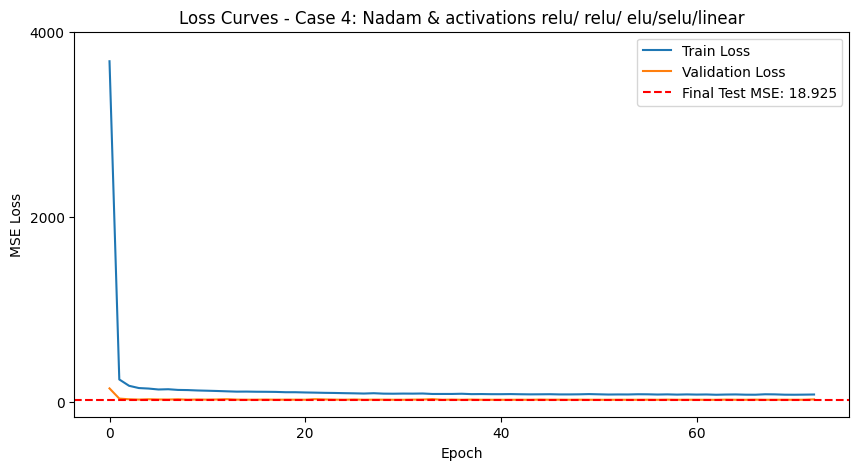


Results for Case 4: Nadam & activations relu/ relu/ elu/selu/linear:
Train R2: 0.555, Test R2: 0.567
Train RMSE: 4.341, Test RMSE: 4.350
Train MAE: 3.427, Test MAE: 3.389
Train MAPE: 3.111%, Test MAPE: 3.060%
Training time (s): 225.75
Peak memory (MB): 1393.30

==== Summary of All Cases ====
                                                Case  Train_R2  Test_R2  \
0  Case 1: Adam & activations relu/relu/relu/elu/...     0.534    0.542   
1  Case 2: Nadam & activations relu/relu/relu/elu...     0.525    0.537   
2  Case 3: Adam & activations relu/ relu/ elu/sel...     0.538    0.553   
3  Case 4: Nadam & activations relu/ relu/ elu/se...     0.555    0.567   

   Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_MAPE  Test_MAPE  \
0       4.446      4.472      3.493     3.483       3.157      3.133   
1       4.487      4.497      3.569     3.544       3.249      3.210   
2       4.423      4.420      3.468     3.421       3.134      3.078   
3       4.341      4.350      3.427     3.

In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]
X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True
)
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM = np.expand_dims(X_test.values, axis=1)

# Model building functions for each case
def build_case_1():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,4)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_case_2():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,4)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='Nadam', loss='mse')
    return model

def build_case_3():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,4)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='elu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_case_4():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,4)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='elu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='Nadam', loss='mse')
    return model

# Train and evaluate loop
cases = [
    ("Case 1: Adam & activations relu/relu/relu/elu/linear", build_case_1),
    ("Case 2: Nadam & activations relu/relu/relu/elu/linear", build_case_2),
    ("Case 3: Adam & activations relu/ relu/ elu/selu/linear", build_case_3),
    ("Case 4: Nadam & activations relu/ relu/ elu/selu/linear", build_case_4)
]

results = []

for case_name, build_fn in cases:
    print(f"\n--- Training {case_name} ---")
    model = build_fn()
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )

    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage  # in MB

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test = model.predict(X_test_LSTM, verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    test_mse = mean_squared_error(y_test, y_pred_test)
    epochs_run = len(history.history['loss'])
    x_ticks = range(0, epochs_run+1, 20)
    max_loss = max(max(history.history['loss']), max(history.history['val_loss']), test_mse)
    y_ticks_max = ((int(max_loss / 2000) + 1) * 2000) if max_loss > 0 else 1
    y_ticks = range(0, y_ticks_max+1, 2000)

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.axhline(test_mse, color='r', linestyle='--', label=f'Final Test MSE: {test_mse:.3f}')
    plt.title(f'Loss Curves - {case_name}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.legend()
    plt.show()

    print(f"\nResults for {case_name}:")
    print(f"Train R2: {train_r2:.3f}, Test R2: {test_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train MAPE: {train_mape:.3f}%, Test MAPE: {test_mape:.3f}%")
    print(f"Training time (s): {training_time:.2f}")
    print(f"Peak memory (MB): {peak_memory:.2f}")

    results.append({
        "Case": case_name,
        "Train_R2": train_r2,
        "Test_R2": test_r2,
        "Train_RMSE": train_rmse,
        "Test_RMSE": test_rmse,
        "Train_MAE": train_mae,
        "Test_MAE": test_mae,
        "Train_MAPE": train_mape,
        "Test_MAPE": test_mape,
        "Train_MSE": mean_squared_error(y_train, y_pred_train),
        "Test_MSE": test_mse,
        "Training_Time_sec": training_time,
        "Peak_Memory_MB": peak_memory
    })

# Summary
results_df = pd.DataFrame(results)
print("\n==== Summary of All Cases ====")
print(results_df.round(3))

Test Size of 0.2 or 20% for 4 features


--- Training Case 1: Adam & activations relu/relu/relu/elu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


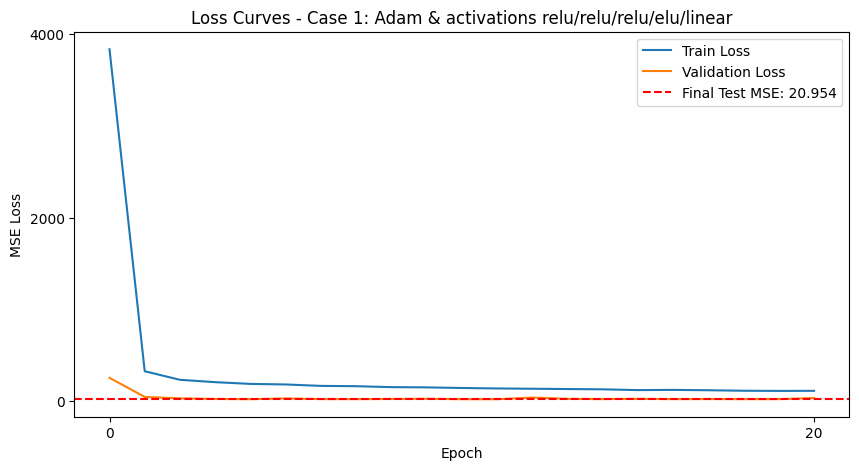


Results for Case 1: Adam & activations relu/relu/relu/elu/linear:
Train R2: 0.516, Test R2: 0.525
Train RMSE: 4.530, Test RMSE: 4.578
Train MAE: 3.553, Test MAE: 3.551
Train MAPE: 3.203%, Test MAPE: 3.186%
Training time (s): 78.70
Peak memory (MB): 994.36

--- Training Case 2: Nadam & activations relu/relu/relu/elu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


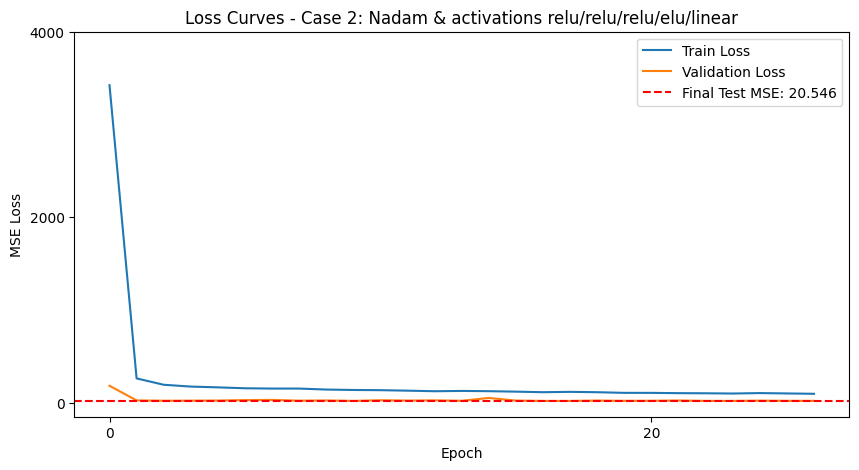


Results for Case 2: Nadam & activations relu/relu/relu/elu/linear:
Train R2: 0.522, Test R2: 0.535
Train RMSE: 4.502, Test RMSE: 4.533
Train MAE: 3.514, Test MAE: 3.501
Train MAPE: 3.164%, Test MAPE: 3.138%
Training time (s): 91.17
Peak memory (MB): 1165.33

--- Training Case 3: Adam & activations relu/ relu/ elu/selu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


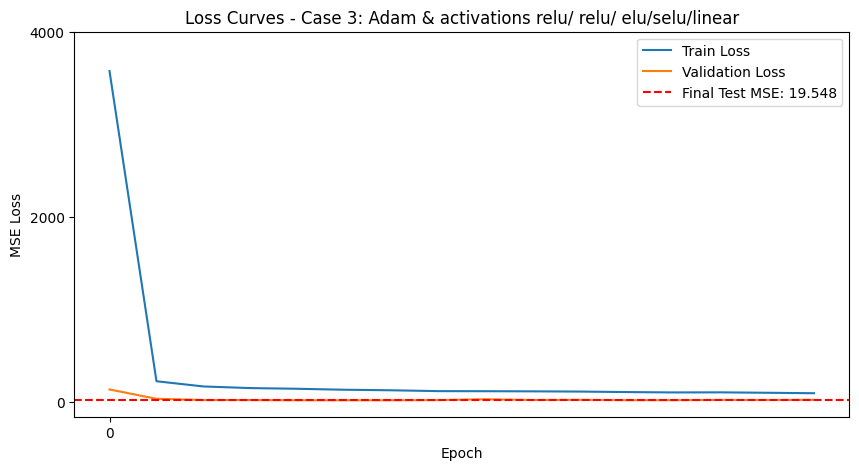


Results for Case 3: Adam & activations relu/ relu/ elu/selu/linear:
Train R2: 0.540, Test R2: 0.557
Train RMSE: 4.418, Test RMSE: 4.421
Train MAE: 3.470, Test MAE: 3.423
Train MAPE: 3.134%, Test MAPE: 3.078%
Training time (s): 54.03
Peak memory (MB): 1240.98

--- Training Case 4: Nadam & activations relu/ relu/ elu/selu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


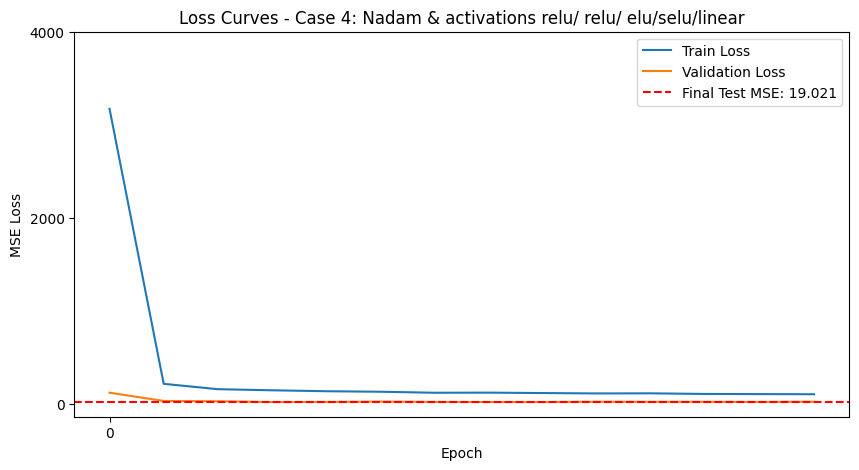


Results for Case 4: Nadam & activations relu/ relu/ elu/selu/linear:
Train R2: 0.540, Test R2: 0.569
Train RMSE: 4.420, Test RMSE: 4.361
Train MAE: 3.489, Test MAE: 3.383
Train MAPE: 3.168%, Test MAPE: 3.060%
Training time (s): 67.87
Peak memory (MB): 1326.41

==== Summary of All Cases ====
                                                Case  Train_R2  Test_R2  \
0  Case 1: Adam & activations relu/relu/relu/elu/...     0.516    0.525   
1  Case 2: Nadam & activations relu/relu/relu/elu...     0.522    0.535   
2  Case 3: Adam & activations relu/ relu/ elu/sel...     0.540    0.557   
3  Case 4: Nadam & activations relu/ relu/ elu/se...     0.540    0.569   

   Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_MAPE  Test_MAPE  \
0       4.530      4.578      3.553     3.551       3.203      3.186   
1       4.502      4.533      3.514     3.501       3.164      3.138   
2       4.418      4.421      3.470     3.423       3.134      3.078   
3       4.420      4.361      3.489     3.3

In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]
X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM = np.expand_dims(X_test.values, axis=1)

# Model building functions for each case
def build_case_1():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,4)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_case_2():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,4)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='Nadam', loss='mse')
    return model

def build_case_3():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,4)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='elu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_case_4():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,4)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='elu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='Nadam', loss='mse')
    return model

# Train and evaluate loop
cases = [
    ("Case 1: Adam & activations relu/relu/relu/elu/linear", build_case_1),
    ("Case 2: Nadam & activations relu/relu/relu/elu/linear", build_case_2),
    ("Case 3: Adam & activations relu/ relu/ elu/selu/linear", build_case_3),
    ("Case 4: Nadam & activations relu/ relu/ elu/selu/linear", build_case_4)
]

results = []

for case_name, build_fn in cases:
    print(f"\n--- Training {case_name} ---")
    model = build_fn()
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )

    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage  # in MB

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test = model.predict(X_test_LSTM, verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    test_mse = mean_squared_error(y_test, y_pred_test)
    epochs_run = len(history.history['loss'])
    x_ticks = range(0, epochs_run+1, 20)
    max_loss = max(max(history.history['loss']), max(history.history['val_loss']), test_mse)
    y_ticks_max = ((int(max_loss / 2000) + 1) * 2000) if max_loss > 0 else 1
    y_ticks = range(0, y_ticks_max+1, 2000)

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.axhline(test_mse, color='r', linestyle='--', label=f'Final Test MSE: {test_mse:.3f}')
    plt.title(f'Loss Curves - {case_name}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.legend()
    plt.show()

    print(f"\nResults for {case_name}:")
    print(f"Train R2: {train_r2:.3f}, Test R2: {test_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train MAPE: {train_mape:.3f}%, Test MAPE: {test_mape:.3f}%")
    print(f"Training time (s): {training_time:.2f}")
    print(f"Peak memory (MB): {peak_memory:.2f}")

    results.append({
        "Case": case_name,
        "Train_R2": train_r2,
        "Test_R2": test_r2,
        "Train_RMSE": train_rmse,
        "Test_RMSE": test_rmse,
        "Train_MAE": train_mae,
        "Test_MAE": test_mae,
        "Train_MAPE": train_mape,
        "Test_MAPE": test_mape,
        "Train_MSE": mean_squared_error(y_train, y_pred_train),
        "Test_MSE": test_mse,
        "Training_Time_sec": training_time,
        "Peak_Memory_MB": peak_memory
    })

# Summary
results_df = pd.DataFrame(results)
print("\n==== Summary of All Cases ====")
print(results_df.round(3))

Test size of 0.2 for All Features


--- Training Case 1: Adam & activations relu/relu/relu/elu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


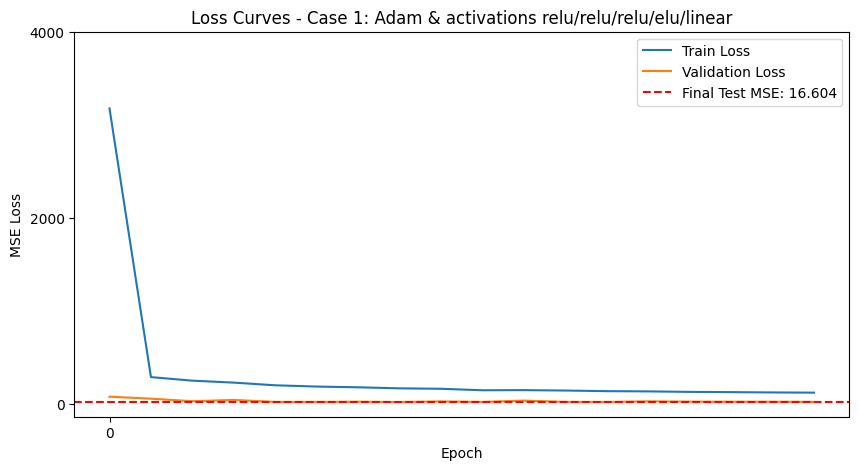


Results for Case 1: Adam & activations relu/relu/relu/elu/linear:
Train R2: 0.606, Test R2: 0.615
Train RMSE: 4.133, Test RMSE: 4.075
Train MAE: 3.211, Test MAE: 3.140
Train MAPE: 2.906%, Test MAPE: 2.841%
Training time (s): 98.42
Peak memory (MB): 997.19

--- Training Case 2: Nadam & activations relu/relu/relu/elu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


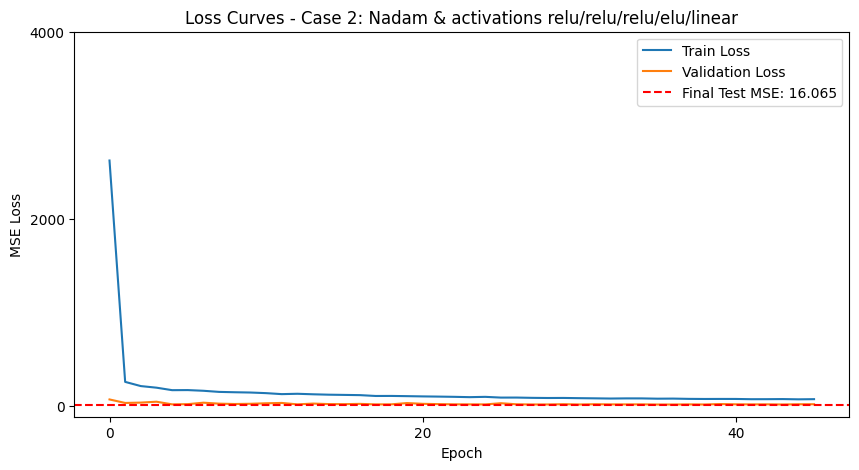


Results for Case 2: Nadam & activations relu/relu/relu/elu/linear:
Train R2: 0.622, Test R2: 0.628
Train RMSE: 4.047, Test RMSE: 4.008
Train MAE: 3.134, Test MAE: 3.085
Train MAPE: 2.835%, Test MAPE: 2.791%
Training time (s): 189.78
Peak memory (MB): 1167.21

--- Training Case 3: Adam & activations relu/ relu/ elu/selu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


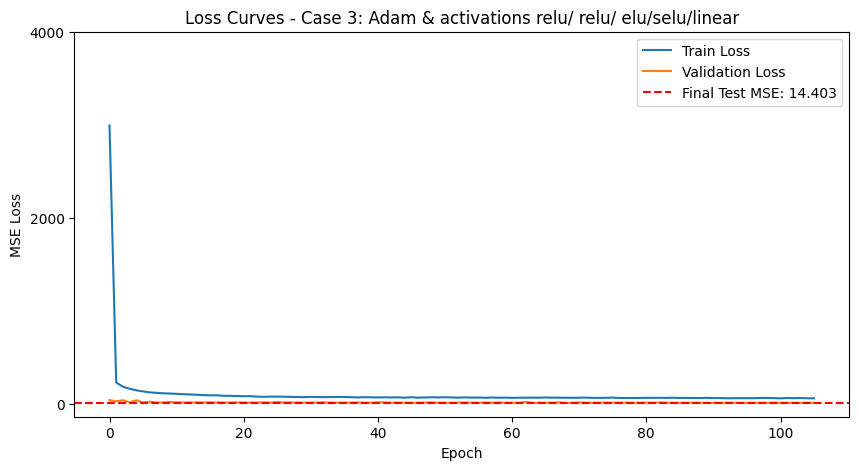


Results for Case 3: Adam & activations relu/ relu/ elu/selu/linear:
Train R2: 0.661, Test R2: 0.666
Train RMSE: 3.829, Test RMSE: 3.795
Train MAE: 2.938, Test MAE: 2.912
Train MAPE: 2.640%, Test MAPE: 2.615%
Training time (s): 364.68
Peak memory (MB): 1241.81

--- Training Case 4: Nadam & activations relu/ relu/ elu/selu/linear ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


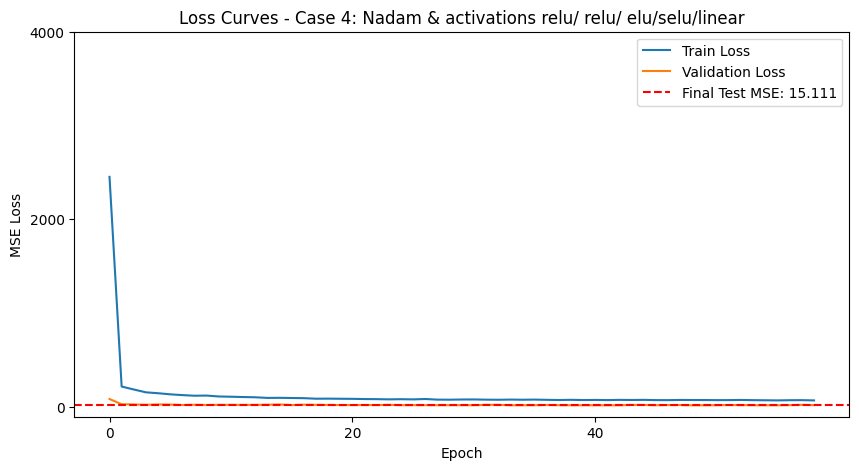


Results for Case 4: Nadam & activations relu/ relu/ elu/selu/linear:
Train R2: 0.644, Test R2: 0.650
Train RMSE: 3.926, Test RMSE: 3.887
Train MAE: 3.011, Test MAE: 2.965
Train MAPE: 2.704%, Test MAPE: 2.661%
Training time (s): 255.65
Peak memory (MB): 1403.05

==== Summary of All Cases ====
                                                Case  Train_R2  Test_R2  \
0  Case 1: Adam & activations relu/relu/relu/elu/...     0.606    0.615   
1  Case 2: Nadam & activations relu/relu/relu/elu...     0.622    0.628   
2  Case 3: Adam & activations relu/ relu/ elu/sel...     0.661    0.666   
3  Case 4: Nadam & activations relu/ relu/ elu/se...     0.644    0.650   

   Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_MAPE  Test_MAPE  \
0       4.133      4.075      3.211     3.140       2.906      2.841   
1       4.047      4.008      3.134     3.085       2.835      2.791   
2       3.829      3.795      2.938     2.912       2.640      2.615   
3       3.926      3.887      3.011     2.

In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]
X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)
X_train_LSTM = np.expand_dims(X_train.values, axis=1)
X_test_LSTM = np.expand_dims(X_test.values, axis=1)

# Model building functions for each case
def build_case_1():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,10)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_case_2():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,10)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='Nadam', loss='mse')
    return model

def build_case_3():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,10)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='elu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_case_4():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1,10)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='elu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='Nadam', loss='mse')
    return model

# Train and evaluate loop
cases = [
    ("Case 1: Adam & activations relu/relu/relu/elu/linear", build_case_1),
    ("Case 2: Nadam & activations relu/relu/relu/elu/linear", build_case_2),
    ("Case 3: Adam & activations relu/ relu/ elu/selu/linear", build_case_3),
    ("Case 4: Nadam & activations relu/ relu/ elu/selu/linear", build_case_4)
]

results = []

for case_name, build_fn in cases:
    print(f"\n--- Training {case_name} ---")
    model = build_fn()
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train_LSTM, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )

    start_time = time.time()
    mem_usage, history = memory_usage((train_fit, ), retval=True, max_usage=True, interval=0.1)
    training_time = time.time() - start_time
    peak_memory = mem_usage  # in MB

    y_pred_train = model.predict(X_train_LSTM, verbose=0).flatten()
    y_pred_test = model.predict(X_test_LSTM, verbose=0).flatten()

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    test_mse = mean_squared_error(y_test, y_pred_test)
    epochs_run = len(history.history['loss'])
    x_ticks = range(0, epochs_run+1, 20)
    max_loss = max(max(history.history['loss']), max(history.history['val_loss']), test_mse)
    y_ticks_max = ((int(max_loss / 2000) + 1) * 2000) if max_loss > 0 else 1
    y_ticks = range(0, y_ticks_max+1, 2000)

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.axhline(test_mse, color='r', linestyle='--', label=f'Final Test MSE: {test_mse:.3f}')
    plt.title(f'Loss Curves - {case_name}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.legend()
    plt.show()

    print(f"\nResults for {case_name}:")
    print(f"Train R2: {train_r2:.3f}, Test R2: {test_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train MAPE: {train_mape:.3f}%, Test MAPE: {test_mape:.3f}%")
    print(f"Training time (s): {training_time:.2f}")
    print(f"Peak memory (MB): {peak_memory:.2f}")

    results.append({
        "Case": case_name,
        "Train_R2": train_r2,
        "Test_R2": test_r2,
        "Train_RMSE": train_rmse,
        "Test_RMSE": test_rmse,
        "Train_MAE": train_mae,
        "Test_MAE": test_mae,
        "Train_MAPE": train_mape,
        "Test_MAPE": test_mape,
        "Train_MSE": mean_squared_error(y_train, y_pred_train),
        "Test_MSE": test_mse,
        "Training_Time_sec": training_time,
        "Peak_Memory_MB": peak_memory
    })

# Summary
results_df = pd.DataFrame(results)
print("\n==== Summary of All Cases ====")
print(results_df.round(3))

# Cross-validation of LSTM Models:

	Model Description	Optimizer/
Activation function	Input Parameters	Validation- Test Sizes
1	VLSTM	Adam-ReLU	4	20%:20%
2	VLSTM	Nadam-Elu	10	20%:20%
3	BLSTM	Adamax-SeLU	4	20%:20%
4	BLSTM	Adam-ReLU	10	20%:20%
5	Case 4	Nadam-ReLU/ ReLu/ Elu/ SeLU/ Linear	10	20%:20%


Case 4: Nadam-ReLU/ ReLu/ Elu/ SeLU/ Linear, 	10	features and 20%:20%

In [ ]:
# Prerequisite for Colab:
!pip install tensorflow memory_profiler openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

!pip install scikit-learn # To install the scikit-learn library in Colab
from sklearn.model_selection import KFold # Import KFold

import time
from memory_profiler import memory_usage
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

import time
from memory_profiler import memory_usage

# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

Saving dataset.xlsx to dataset.xlsx


In [ ]:
# Your preprocessing code from before
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data[mask]
X = data[main_features]
y = data['Weight measurement']


# Scale features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Convert to numpy array and reshape for LSTM input: (samples, timesteps=1, features=10)
X_scaled = X_scaled.values.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Define the Case 4 Model
def build_case_4():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1, 10)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='elu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='Nadam', loss='mse')
    return model

# Function to compute confidence intervals
from scipy import stats

def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    mean_val = np.mean(a)
    se = stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1) if n>1 else 0
    return mean_val, h

# K-Fold Cross Validation with internal validation
def cross_validate_kfold(X, y, k):

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = {
        'Train_R2':[], 'Test_R2':[],
        'Train_RMSE':[], 'Test_RMSE':[],
        'Train_MAE':[], 'Test_MAE':[],
        'Train_MAPE':[], 'Test_MAPE':[]
    }
    all_test_preds = []
    all_test_true = []

    fold_no = 1
    for train_index, test_index in kf.split(X):
        print(f"\n--- Fold {fold_no} / {k} ---")
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Build model fresh for every fold
        model = build_case_4()

        # Early stopping callback
        es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

        history = model.fit(
            X_train_fold, y_train_fold,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )

        # Predictions
        y_train_pred = model.predict(X_train_fold).flatten()
        y_test_pred = model.predict(X_test_fold).flatten()

        # Store predictions and true values for test
        all_test_preds.extend(y_test_pred)
        all_test_true.extend(y_test_fold)

        # Metrics for train and test
        fold_metrics['Train_R2'].append(r2_score(y_train_fold, y_train_pred))
        fold_metrics['Test_R2'].append(r2_score(y_test_fold, y_test_pred))
        fold_metrics['Train_RMSE'].append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))
        fold_metrics['Test_RMSE'].append(np.sqrt(mean_squared_error(y_test_fold, y_test_pred)))
        fold_metrics['Train_MAE'].append(mean_absolute_error(y_train_fold, y_train_pred))
        fold_metrics['Test_MAE'].append(mean_absolute_error(y_test_fold, y_test_pred))
        fold_metrics['Train_MAPE'].append(np.mean(np.abs((y_train_fold - y_train_pred) / y_train_fold)) * 100)
        fold_metrics['Test_MAPE'].append(np.mean(np.abs((y_test_fold - y_test_pred) / y_test_fold)) * 100)

        fold_no += 1

    # Calculate mean, std, variance and confidence intervals for each metric
    summary_stats = {}
    for metric_name, values in fold_metrics.items():
        mean_val = np.mean(values)
        std_val = np.std(values, ddof=1)
        var_val = np.var(values, ddof=1)
        mean_ci, ci_half_width = mean_confidence_interval(values)
        summary_stats[metric_name] = {
            'mean': mean_val,
            'std': std_val,
            'variance': var_val,
            '95%_CI': (mean_ci - ci_half_width, mean_ci + ci_half_width)
        }

    # Wrap predictions and true values to arrays for convenience
    all_test_preds = np.array(all_test_preds)
    all_test_true = np.array(all_test_true)

    return fold_metrics, summary_stats, all_test_preds, all_test_true

# Run cross validation for k=3,5,7,10
ks = [3,5,7,10]
cv_results = {}

for k in ks:
    print(f"\n\n******** Running {k}-Fold Cross Validation ********")
    fold_metrics, summary_stats, preds, trues = cross_validate_kfold(X_scaled, y, k)
    cv_results[k] = {
        'fold_metrics': fold_metrics,
        'summary_stats': summary_stats,
        'predictions': preds,
        'true_values': trues
    }

# Print summary statistics per k
for k, result in cv_results.items():
    print(f"\n==== CV Summary for k={k} ====")
    for metric_name, stats in result['summary_stats'].items():
        print(f"{metric_name}: mean={stats['mean']:.3f}, std={stats['std']:.3f}, var={stats['variance']:.3f}, 95% CI=({stats['95%_CI'][0]:.3f}, {stats['95%_CI'][1]:.3f})")



******** Running 3-Fold Cross Validation ********

--- Fold 1 / 3 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 2 / 3 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 3 / 3 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


******** Running 5-Fold Cross Validation ********

--- Fold 1 / 5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

--- Fold 2 / 5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 3 / 5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 4 / 5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 5 / 5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


******** Running 7-Fold Cross Validation ********

--- Fold 1 / 7 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 2 / 7 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 3 / 7 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 4 / 7 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 5 / 7 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 6 / 7 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 7 / 7 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


******** Running 10-Fold Cross Validation ********

--- Fold 1 / 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 2 / 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 3 / 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 4 / 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 5 / 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 6 / 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 7 / 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 8 / 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 9 / 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Fold 10 / 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

==== CV Summary for k=3 ====
Train_R2: mean=0.593, std=0.028, var=0.001, 95% CI=(0.524, 0.662)
Test_R2: mean=0.593, std=0.024, var=0.001, 95% CI=(0.532, 0.654)
Train_RMSE: mean=4.195, std=0.141, var=0.020, 95% CI=(3.846, 4.544)
Test_RMSE: mean=4.195, std=0.132, var=0.017, 95% CI=(3.867, 4.522)
Train_MAE: mean=3.263, std=0.104, var=0.011, 95% CI=(3.005, 3.521)
Test_MAE: mean=3.260, std=0.095, var=0.009, 95% CI=(3.023, 3.497)
Train_MAPE: mean=2.950, std=0.094, var=0.009, 95% CI=(2.717, 3.182)
Test_MAPE: mean=2.947, std=0.083, var=0.007, 95% CI=(2.741, 3.154)

==== CV Summary for k=5 ====
Train_R2: mean=0.610, std=0.018, var=0.000, 95% CI=(0.587, 0.633)
Test_R2: mean=0.608, std=0.029, var=0.001, 95% CI=(0.572, 0.645)
Train_RMSE: mean=4.109, std=0.103, var=0.011, 95% CI=(3.981, 4.237)
Test_RMSE: mean=4.112, std=0.112, var=0.013, 95% CI=(3.972, 4.252)
Train_MAE: mean=3.202, std=0.071, var=0.005, 95% CI=(3.114, 

The Above code did not have Training time and Peak Memory but this one has

In [ ]:
!pip install tensorflow memory_profiler openpyxl

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats
import time
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

Saving dataset.xlsx to dataset.xlsx


In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]

# Outlier removal on main features (numerical features assumed here)
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # (samples, timesteps=1, features=10)

# Model Builder for Case 4
def build_case_4():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1, 10)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='elu')))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='Nadam', loss='mse')
    return model

# Confidence interval calc function
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    mean_val = np.mean(a)
    se = stats.sem(a) if n > 1 else 0
    h = se * stats.t.ppf((1 + confidence) / 2., n-1) if n > 1 else 0
    return mean_val, h

# Cross-validation for Case 4
def cross_validate_case_4(X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    fold_metrics = {
        'Train_R2': [], 'Test_R2': [],
        'Train_RMSE': [], 'Test_RMSE': [],
        'Train_MAE': [], 'Test_MAE': [],
        'Train_MAPE': [], 'Test_MAPE': [],
        'Training_Time_s': [], 'Peak_Memory_MB': []
    }

    all_test_preds = []
    all_test_true = []

    fold_no = 1
    for train_idx, test_idx in kf.split(X):
        print(f'\nFold {fold_no} / {k}')
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        model = build_case_4()
        es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

        def train_fit():
            return model.fit(
                X_train_fold, y_train_fold,
                validation_split=0.2,
                epochs=200,
                batch_size=32,
                verbose=0,
                callbacks=[es]
            )

        start_time = time.time()
        mem_peak, history = memory_usage((train_fit,), retval=True, max_usage=True, interval=0.1)
        training_time = time.time() - start_time

        # Predict
        y_train_pred = model.predict(X_train_fold, verbose=0).flatten()
        y_test_pred = model.predict(X_test_fold, verbose=0).flatten()

        all_test_preds.extend(y_test_pred)
        all_test_true.extend(y_test_fold)

        # Metrics
        fold_metrics['Train_R2'].append(r2_score(y_train_fold, y_train_pred))
        fold_metrics['Test_R2'].append(r2_score(y_test_fold, y_test_pred))
        fold_metrics['Train_RMSE'].append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))
        fold_metrics['Test_RMSE'].append(np.sqrt(mean_squared_error(y_test_fold, y_test_pred)))
        fold_metrics['Train_MAE'].append(mean_absolute_error(y_train_fold, y_train_pred))
        fold_metrics['Test_MAE'].append(mean_absolute_error(y_test_fold, y_test_pred))
        train_mape = np.mean(np.abs((y_train_fold - y_train_pred) / y_train_fold)) * 100
        test_mape = np.mean(np.abs((y_test_fold - y_test_pred) / y_test_fold)) * 100
        fold_metrics['Train_MAPE'].append(train_mape)
        fold_metrics['Test_MAPE'].append(test_mape)
        fold_metrics['Training_Time_s'].append(training_time)
        fold_metrics['Peak_Memory_MB'].append(mem_peak)

        fold_no += 1

    # Summary stats calculation
    summary = {}
    for metric_name, vals in fold_metrics.items():
        mean_v, ci_half = mean_confidence_interval(vals)
        var_v = np.var(vals, ddof=1) if len(vals) > 1 else 0
        std_v = np.std(vals, ddof=1) if len(vals) > 1 else 0
        summary[metric_name] = {'mean': mean_v, 'std': std_v, 'variance': var_v, '95%_CI': (mean_v - ci_half, mean_v + ci_half)}

    return fold_metrics, summary, np.array(all_test_preds), np.array(all_test_true)


# Run CV for k=3,5,7,10
ks = [3, 5, 7, 10]
cv_results = {}

for k in ks:
    print(f'\n\n======= Running {k}-Fold Cross Validation =======')
    fold_metrics, summary_stats, preds, trues = cross_validate_case_4(X_scaled, y, k)
    cv_results[k] = {
        'fold_metrics': fold_metrics,
        'summary_stats': summary_stats,
        'predictions': preds,
        'true_values': trues
    }


# Print final formatted results as requested
def print_cv_summary(cv_results):
    print("=== Model ===\n")
    for k in sorted(cv_results):
        fm = cv_results[k]['fold_metrics']
        print(f"k={k}: R2={np.mean(fm['Test_R2']):.3f}  RMSE={np.mean(fm['Test_RMSE']):.3f}  MAE={np.mean(fm['Test_MAE']):.3f}  MAPE={np.mean(fm['Test_MAPE']):.3f}  Time={np.mean(fm['Training_Time_s']):.3f}s Mem={np.mean(fm['Peak_Memory_MB']):.2f}MB")

    # Aggregate across all k
    all_r2 = []
    all_rmse = []
    all_mae = []
    all_mape = []
    for res in cv_results.values():
        all_r2.extend(res['fold_metrics']['Test_R2'])
        all_rmse.extend(res['fold_metrics']['Test_RMSE'])
        all_mae.extend(res['fold_metrics']['Test_MAE'])
        all_mape.extend(res['fold_metrics']['Test_MAPE'])

    def calc_stats(arr):
        a = np.array(arr)
        n = len(a)
        mean_v = np.mean(a)
        std_v = np.std(a, ddof=1) if n > 1 else 0
        var_v = np.var(a, ddof=1) if n > 1 else 0
        h = 0
        if n > 1:
            h = stats.sem(a) * stats.t.ppf((1 + 0.95) / 2., n - 1)
        return mean_v, std_v, var_v, (mean_v - h, mean_v + h)

    r2_stats = calc_stats(all_r2)
    rmse_stats = calc_stats(all_rmse)
    mae_stats = calc_stats(all_mae)
    mape_stats = calc_stats(all_mape)

    print("\nR2: Mean={:.3f}, Std={:.3f}, Var={:.5f}, CI=({:.3f}, {:.3f})".format(
        r2_stats[0], r2_stats[1], r2_stats[2], r2_stats[3][0], r2_stats[3][1]))
    print("RMSE: Mean={:.3f}, Std={:.3f}, Var={:.5f}, CI=({:.3f}, {:.3f})".format(
        rmse_stats[0], rmse_stats[1], rmse_stats[2], rmse_stats[3][0], rmse_stats[3][1]))
    print("MAE: Mean={:.3f}, Std={:.3f}, Var={:.5f}, CI=({:.3f}, {:.3f})".format(
        mae_stats[0], mae_stats[1], mae_stats[2], mae_stats[3][0], mae_stats[3][1]))
    print("MAPE: Mean={:.3f}, Std={:.3f}, Var={:.5f}, CI=({:.3f}, {:.3f})".format(
        mape_stats[0], mape_stats[1], mape_stats[2], mape_stats[3][0], mape_stats[3][1]))

    # Best k by mean R2
    mean_r2_per_k = {k: np.mean(cv_results[k]['fold_metrics']['Test_R2']) for k in cv_results}
    best_k = max(mean_r2_per_k, key=mean_r2_per_k.get)
    best_r2 = mean_r2_per_k[best_k]
    print(f"\nBest k for Mean R2: {best_k} with Mean R2 = {best_r2:.6f}")

# Call this function after CV completes:
print_cv_summary(cv_results)



======= Running 3-Fold Cross Validation =======

Fold 1 / 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 2 / 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 3 / 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)




======= Running 5-Fold Cross Validation =======

Fold 1 / 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 2 / 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 3 / 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 4 / 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 5 / 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)




======= Running 7-Fold Cross Validation =======

Fold 1 / 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 2 / 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 3 / 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 4 / 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 5 / 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 6 / 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 7 / 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)




======= Running 10-Fold Cross Validation =======

Fold 1 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 2 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 3 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 4 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 5 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 6 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 7 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 8 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 9 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Fold 10 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


=== Model ===

k=3: R2=0.590  RMSE=4.210  MAE=3.240  MAPE=2.912  Time=83.131s Mem=1141.28MB
k=5: R2=0.595  RMSE=4.184  MAE=3.247  MAPE=2.932  Time=89.864s Mem=1512.23MB
k=7: R2=0.600  RMSE=4.156  MAE=3.243  MAPE=2.937  Time=132.651s Mem=2055.93MB
k=10: R2=0.592  RMSE=4.198  MAE=3.236  MAPE=2.913  Time=98.841s Mem=2805.57MB

R2: Mean=0.594, Std=0.020, Var=0.00041, CI=(0.586, 0.603)
RMSE: Mean=4.185, Std=0.100, Var=0.01007, CI=(4.143, 4.226)
MAE: Mean=3.241, Std=0.081, Var=0.00663, CI=(3.207, 3.274)
MAPE: Mean=2.923, Std=0.080, Var=0.00635, CI=(2.890, 2.956)

Best k for Mean R2: 7 with Mean R2 = 0.599874


# ENSEMBLE METHODS WITH GRIDSEARCHCV

In [ ]:
# Install necessary packages (execute if running in a fresh environment)
!pip install lightgbm catboost xgboost memory_profiler openpyxl

import numpy as np
import pandas as pd
import time
from memory_profiler import memory_usage
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingRegressor, BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))


Saving dataset.xlsx to dataset.xlsx


This is for 30% test size and 4 features

In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)


# Example feature list
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]

from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True
)

# Base regressors
hgb = HistGradientBoostingRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
cat = CatBoostRegressor(verbose=0, random_state=42)
xgb = XGBRegressor(random_state=42, eval_metric='rmse')
rf = RandomForestRegressor(random_state=42)

# Add Stacking Regressor to ensemble_configs
stacking_base_learners = [
    ('hgb', hgb),
    ('lgbm', lgbm),
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf)
]

stacking_regressor = StackingRegressor(
    estimators=stacking_base_learners,
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

ensemble_configs = {
    "Voting Regressor": {
        "model": VotingRegressor(
            estimators=[
                ('hgb', hgb),
                ('lgbm', lgbm),
                ('cat', cat),
                ('xgb', xgb),
                ('rf', rf)
            ]
        ),
        "param_grid": {}
    },
    "Bagging Regressor": {
        "model": BaggingRegressor(
            estimator=RandomForestRegressor(random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [10, 50],
            'max_samples': [0.8, 1.0],
            'max_features': [0.8, 1.0]
        }
    },
    "AdaBoost Regressor": {
    "model": AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
        random_state=42
    ),
    "param_grid": {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1, 0.2]
    }
    },
    "Stacking Regressor": {
        "model": stacking_regressor, # Now stacking_regressor is defined
        "param_grid": {
            'final_estimator__alpha': [0.1, 1, 10]
        }
    }
}

# Add Stacking Regressor to ensemble_configs

stacking_base_learners = [
    ('hgb', hgb),
    ('lgbm', lgbm),
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf)
]

stacking_regressor = StackingRegressor(
    estimators=stacking_base_learners,
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

ensemble_configs["Stacking Regressor"] = {
    "model": stacking_regressor,
    "param_grid": {
        'final_estimator__alpha': [0.1, 1, 10]
    }
}

# Helper function
def grid_search_profile(model, param_grid, X_train, y_train):
    if param_grid:
        gs = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='r2', verbose=0)
        start_time = time.time()
        mem_usage = memory_usage((gs.fit, (X_train, y_train)), max_usage=True)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = gs.best_estimator_
    else:
        start_time = time.time()
        mem_usage = memory_usage((model.fit, (X_train, y_train)), max_usage=True)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = model
        best_model.fit(X_train, y_train)
    return best_model, train_time, peak_mem

# Training and evaluation
import numpy as np
results = {}

for name, config in ensemble_configs.items():
    print(f"\nRunning GridSearch and training for {name}...")
    model = config['model']
    param_grid = config['param_grid']

    best_model, train_time, peak_mem = grid_search_profile(model, param_grid, X_train, y_train)

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Calculate RMSE without the 'squared' argument for compatibility
    train_rmse = mean_squared_error(y_train, y_pred_train) ** 0.5
    test_rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    print(f"{name} Best Parameters: {(param_grid and best_model.get_params()) or 'Default'}")
    print(f"{name} Results:")
    print(f"Train R2: {train_r2:.3f}, Test R2: {test_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train MAPE: {train_mape:.3f}%, Test MAPE: {test_mape:.3f}%")
    print(f"Training Time: {train_time:.2f} sec")
    print(f"Peak Memory: {peak_mem:.2f} MB\n")

    results[name] = {
        'Train_R2': train_r2, 'Test_R2': test_r2,
        'Train_RMSE': train_rmse, 'Test_RMSE': test_rmse,
        'Train_MAE': train_mae, 'Test_MAE': test_mae,
        'Train_MAPE': train_mape, 'Test_MAPE': test_mape,
        'Training_Time_sec': train_time,
        'Peak_Memory_MB': peak_mem,
        'Best_Params': (param_grid and best_model.get_params()) or 'Default'
    }

# Final results summary
results_df = pd.DataFrame(results).T
print("\n=== Final Summary Table ===")
print(results_df.round(3))


Running GridSearch and training for Voting Regressor...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 4
[LightGBM] [Info] Start training from score 110.261799


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 4
[LightGBM] [Info] Start training from score 110.261799


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Voting Regressor Best Parameters: Default
Voting Regressor Results:
Train R2: 0.684, Test R2: 0.568
Train RMSE: 3.661, Test RMSE: 4.344
Train MAE: 2.870, Test MAE: 3.390
Train MAPE: 2.607%, Test MAPE: 3.057%
Training Time: 12.46 sec
Peak Memory: 427.26 MB


Running GridSearch and training for Bagging Regressor...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Bagging Regressor Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': None, 'estimator__max_features': 1.0, 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(random_state=42), 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Bagging Regressor Results:
Train R2: 0.648, Test R2: 0.563
Train RMSE: 3.864, Test RMSE: 4.368
Train MAE: 3.043, Tes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacking Regressor Best Parameters: {'cv': 3, 'estimators': [('hgb', HistGradientBoostingRegressor(random_state=42)), ('lgbm', LGBMRegressor(random_state=42)), ('cat', <catboost.core.CatBoostRegressor object at 0x78f08d967ed0>), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)), ('rf', RandomF

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Test size of 0.2 or 20% AND 4 FEATURES

In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)


# Example feature list
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]

from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)

# Base regressors
hgb = HistGradientBoostingRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
cat = CatBoostRegressor(verbose=0, random_state=42)
xgb = XGBRegressor(random_state=42, eval_metric='rmse')
rf = RandomForestRegressor(random_state=42)

# Add Stacking Regressor to ensemble_configs
stacking_base_learners = [
    ('hgb', hgb),
    ('lgbm', lgbm),
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf)
]

stacking_regressor = StackingRegressor(
    estimators=stacking_base_learners,
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

ensemble_configs = {
    "Voting Regressor": {
        "model": VotingRegressor(
            estimators=[
                ('hgb', hgb),
                ('lgbm', lgbm),
                ('cat', cat),
                ('xgb', xgb),
                ('rf', rf)
            ]
        ),
        "param_grid": {}
    },
    "Bagging Regressor": {
        "model": BaggingRegressor(
            estimator=RandomForestRegressor(random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [10, 50],
            'max_samples': [0.8, 1.0],
            'max_features': [0.8, 1.0]
        }
    },
    "AdaBoost Regressor": {
    "model": AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
        random_state=42
    ),
    "param_grid": {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1, 0.2]
    }
    },
    "Stacking Regressor": {
        "model": stacking_regressor, # Now stacking_regressor is defined
        "param_grid": {
            'final_estimator__alpha': [0.1, 1, 10]
        }
    }
}

# Add Stacking Regressor to ensemble_configs
stacking_base_learners = [
    ('hgb', hgb),
    ('lgbm', lgbm),
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf)
]

stacking_regressor = StackingRegressor(
    estimators=stacking_base_learners,
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

ensemble_configs["Stacking Regressor"] = {
    "model": stacking_regressor,
    "param_grid": {
        'final_estimator__alpha': [0.1, 1, 10]
    }
}

# Helper function
def grid_search_profile(model, param_grid, X_train, y_train):
    if param_grid:
        gs = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='r2', verbose=0)
        start_time = time.time()
        mem_usage = memory_usage((gs.fit, (X_train, y_train)), max_usage=True)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = gs.best_estimator_
    else:
        start_time = time.time()
        mem_usage = memory_usage((model.fit, (X_train, y_train)), max_usage=True)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = model
        best_model.fit(X_train, y_train)
    return best_model, train_time, peak_mem

# Training and evaluation
import numpy as np
results = {}

for name, config in ensemble_configs.items():
    print(f"\nRunning GridSearch and training for {name}...")
    model = config['model']
    param_grid = config['param_grid']

    best_model, train_time, peak_mem = grid_search_profile(model, param_grid, X_train, y_train)

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Calculate RMSE without the 'squared' argument for compatibility
    train_rmse = mean_squared_error(y_train, y_pred_train) ** 0.5
    test_rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    print(f"{name} Best Parameters: {(param_grid and best_model.get_params()) or 'Default'}")
    print(f"{name} Results:")
    print(f"Train R2: {train_r2:.3f}, Test R2: {test_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train MAPE: {train_mape:.3f}%, Test MAPE: {test_mape:.3f}%")
    print(f"Training Time: {train_time:.2f} sec")
    print(f"Peak Memory: {peak_mem:.2f} MB\n")

    results[name] = {
        'Train_R2': train_r2, 'Test_R2': test_r2,
        'Train_RMSE': train_rmse, 'Test_RMSE': test_rmse,
        'Train_MAE': train_mae, 'Test_MAE': test_mae,
        'Train_MAPE': train_mape, 'Test_MAPE': test_mape,
        'Training_Time_sec': train_time,
        'Peak_Memory_MB': peak_mem,
        'Best_Params': (param_grid and best_model.get_params()) or 'Default'
    }

# Final results summary
results_df = pd.DataFrame(results).T
print("\n=== Final Summary Table ===")
print(results_df.round(3))


Running GridSearch and training for Voting Regressor...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 7584, number of used features: 4
[LightGBM] [Info] Start training from score 110.296361


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 7584, number of used features: 4
[LightGBM] [Info] Start training from score 110.296361


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Voting Regressor Best Parameters: Default
Voting Regressor Results:
Train R2: 0.676, Test R2: 0.572
Train RMSE: 3.709, Test RMSE: 4.346
Train MAE: 2.908, Test MAE: 3.370
Train MAPE: 2.641%, Test MAPE: 3.039%
Training Time: 8.95 sec
Peak Memory: 430.17 MB


Running GridSearch and training for Bagging Regressor...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Bagging Regressor Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': None, 'estimator__max_features': 1.0, 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(random_state=42), 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Bagging Regressor Results:
Train R2: 0.641, Test R2: 0.568
Train RMSE: 3.906, Test RMSE: 4.368
Train MAE: 3.073, Tes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacking Regressor Best Parameters: {'cv': 3, 'estimators': [('hgb', HistGradientBoostingRegressor(random_state=42)), ('lgbm', LGBMRegressor(random_state=42)), ('cat', <catboost.core.CatBoostRegressor object at 0x7a656af78990>), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)), ('rf', RandomF

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Data Preprocessing (adjust this to your data source)
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)


# Example feature list
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]

from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)

# Base regressors
hgb = HistGradientBoostingRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
cat = CatBoostRegressor(verbose=0, random_state=42)
xgb = XGBRegressor(random_state=42, eval_metric='rmse')
rf = RandomForestRegressor(random_state=42)

# Add Stacking Regressor to ensemble_configs
stacking_base_learners = [
    ('hgb', hgb),
    ('lgbm', lgbm),
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf)
]

stacking_regressor = StackingRegressor(
    estimators=stacking_base_learners,
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

ensemble_configs = {
    "Voting Regressor": {
        "model": VotingRegressor(
            estimators=[
                ('hgb', hgb),
                ('lgbm', lgbm),
                ('cat', cat),
                ('xgb', xgb),
                ('rf', rf)
            ]
        ),
        "param_grid": {}
    },
    "Bagging Regressor": {
        "model": BaggingRegressor(
            estimator=RandomForestRegressor(random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [10, 50],
            'max_samples': [0.8, 1.0],
            'max_features': [0.8, 1.0]
        }
    },
    "AdaBoost Regressor": {
    "model": AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
        random_state=42
    ),
    "param_grid": {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1, 0.2]
    }
    },
    "Stacking Regressor": {
        "model": stacking_regressor, # Now stacking_regressor is defined
        "param_grid": {
            'final_estimator__alpha': [0.1, 1, 10]
        }
    }
}

# Add Stacking Regressor to ensemble_configs

stacking_base_learners = [
    ('hgb', hgb),
    ('lgbm', lgbm),
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf)
]

stacking_regressor = StackingRegressor(
    estimators=stacking_base_learners,
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

ensemble_configs["Stacking Regressor"] = {
    "model": stacking_regressor,
    "param_grid": {
        'final_estimator__alpha': [0.1, 1, 10]
    }
}

# Helper function
def grid_search_profile(model, param_grid, X_train, y_train):
    if param_grid:
        gs = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='r2', verbose=0)
        start_time = time.time()
        mem_usage = memory_usage((gs.fit, (X_train, y_train)), max_usage=True)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = gs.best_estimator_
    else:
        start_time = time.time()
        mem_usage = memory_usage((model.fit, (X_train, y_train)), max_usage=True)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = model
        best_model.fit(X_train, y_train)
    return best_model, train_time, peak_mem

# Training and evaluation
import numpy as np
results = {}

for name, config in ensemble_configs.items():
    print(f"\nRunning GridSearch and training for {name}...")
    model = config['model']
    param_grid = config['param_grid']

    best_model, train_time, peak_mem = grid_search_profile(model, param_grid, X_train, y_train)

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Calculate RMSE without the 'squared' argument for compatibility
    train_rmse = mean_squared_error(y_train, y_pred_train) ** 0.5
    test_rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    print(f"{name} Best Parameters: {(param_grid and best_model.get_params()) or 'Default'}")
    print(f"{name} Results:")
    print(f"Train R2: {train_r2:.3f}, Test R2: {test_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train MAPE: {train_mape:.3f}%, Test MAPE: {test_mape:.3f}%")
    print(f"Training Time: {train_time:.2f} sec")
    print(f"Peak Memory: {peak_mem:.2f} MB\n")

    results[name] = {
        'Train_R2': train_r2, 'Test_R2': test_r2,
        'Train_RMSE': train_rmse, 'Test_RMSE': test_rmse,
        'Train_MAE': train_mae, 'Test_MAE': test_mae,
        'Train_MAPE': train_mape, 'Test_MAPE': test_mape,
        'Training_Time_sec': train_time,
        'Peak_Memory_MB': peak_mem,
        'Best_Params': (param_grid and best_model.get_params()) or 'Default'
    }

# Final results summary
results_df = pd.DataFrame(results).T
print("\n=== Final Summary Table ===")
print(results_df.round(3))


Running GridSearch and training for Voting Regressor...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 7584, number of used features: 10
[LightGBM] [Info] Start training from score 110.474749


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 7584, number of used features: 10
[LightGBM] [Info] Start training from score 110.474749


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Voting Regressor Best Parameters: Default
Voting Regressor Results:
Train R2: 0.837, Test R2: 0.698
Train RMSE: 2.655, Test RMSE: 3.609
Train MAE: 2.018, Test MAE: 2.746
Train MAPE: 1.817%, Test MAPE: 2.465%
Training Time: 15.84 sec
Peak Memory: 468.57 MB


Running GridSearch and training for Bagging Regressor...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Bagging Regressor Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': None, 'estimator__max_features': 1.0, 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(random_state=42), 'max_features': 1.0, 'max_samples': 0.8, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Bagging Regressor Results:
Train R2: 0.865, Test R2: 0.689
Train RMSE: 2.416, Test RMSE: 3.666
Train MAE: 1.810, Tes

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacking Regressor Best Parameters: {'cv': 3, 'estimators': [('hgb', HistGradientBoostingRegressor(random_state=42)), ('lgbm', LGBMRegressor(random_state=42)), ('cat', <catboost.core.CatBoostRegressor object at 0x7b9b811f1490>), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)), ('rf', RandomF

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# ENSEMBLE METHODS WITH RANDOMSEARCHCV

In [ ]:
# Install additional packages if needed:
!pip install scikit-learn
!pip install scikit-optimize lightgbm catboost xgboost memory_profiler openpyxl

import numpy as np
import pandas as pd
import time
from memory_profiler import memory_usage
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingRegressor, BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import IsolationForest

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV  # For Bayesian optimization example
from skopt.space import Real, Integer

# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


Saving dataset.xlsx to dataset.xlsx


THIS IS FOR TEST SIZE OF 30 (0.3) AND 4 FEATURES

In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)


# Main features example
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]

# Outlier Removal
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True)

### Define models with early stopping configs ###

def create_lgbm():
    return LGBMRegressor(random_state=42, n_jobs=-1,  verbose=0) # Remove early stopping

def create_xgb():
    return XGBRegressor(random_state=42, eval_metric='rmse', n_jobs=-1, verbosity=0) #Remove early stopping

def create_cat():
    return CatBoostRegressor(
        random_seed=42,
        verbose=False
    ) #Remove early stopping


hgb = HistGradientBoostingRegressor(random_state=42)  # sklearn HGB does not support early stopping in sklearn API

lgbm = create_lgbm()
xgb = create_xgb()
cat = create_cat()
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

### Randomized Hyperparameter Grids ###

ensemble_configs = {
    "Voting Regressor": {
        "model": VotingRegressor(
            estimators=[('hgb', hgb), ('lgbm', lgbm), ('cat', cat), ('xgb', xgb), ('rf', rf)]
        ),
        "param_grid": {}  # no tuning here - simple averaging
    },
    "Bagging Regressor": {
        "model": BaggingRegressor(
            estimator=RandomForestRegressor(random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [10, 30, 50],
            'max_samples': [0.6, 0.8, 1.0],
            'max_features': [0.6, 0.8, 1.0]
        }
    },
    "AdaBoost Regressor": {
        "model": AdaBoostRegressor(
            estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [50, 75, 100],
            'learning_rate': [0.01, 0.05, 0.1, 0.2]
        }
    },
    "Stacking Regressor": {
        "model": StackingRegressor(
            estimators=[('hgb', hgb), ('lgbm', lgbm), ('cat', cat), ('xgb', xgb), ('rf', rf)],
            final_estimator=Ridge(),
            cv=3,
            n_jobs=-1,
            passthrough=False
        ),
        "param_grid": {
            'final_estimator__alpha': [0.01, 0.1, 1, 10]
        }
    }
}


### Helper function: RandomizedSearch + memory/time profiling ###
from sklearn.exceptions import FitFailedWarning
import warnings

def random_search_profile(model, param_grid, X_train, y_train, n_iter=20):
    if param_grid:
        rs = RandomizedSearchCV(
            model, param_grid, n_iter=n_iter, cv=3, n_jobs=-1,
            scoring='r2', verbose=0, error_score='raise'
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FitFailedWarning)
            start_time = time.time()
            mem_usage = memory_usage((rs.fit, (X_train, y_train)), max_usage=True, interval=0.1)
            train_time = time.time() - start_time
            peak_mem = mem_usage
        best_model = rs.best_estimator_
    else:
        start_time = time.time()
        mem_usage = memory_usage((model.fit, (X_train, y_train)), max_usage=True, interval=0.1)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = model
        best_model.fit(X_train, y_train)
    return best_model, train_time, peak_mem


# Train, evaluate and report
results = {}

for name, config in ensemble_configs.items():
    print(f"\n=== Training {name} ===")
    model = config['model']
    param_grid = config['param_grid']

    best_model, train_time, peak_mem = random_search_profile(model, param_grid, X_train, y_train, n_iter=20)

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    print(f"{name} Best Parameters: {best_model.get_params() if param_grid else 'Default parameters'}")
    print(f"{name} Results:")
    print(f"Train R2: {train_r2:.3f}, Test R2: {test_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train MAPE: {train_mape:.3f}%, Test MAPE: {test_mape:.3f}%")
    print(f"Training Time (s): {train_time:.2f}")
    print(f"Peak Memory (MB): {peak_mem:.2f}")

    results[name] = {
        "Train_R2": train_r2, "Test_R2": test_r2,
        "Train_RMSE": train_rmse, "Test_RMSE": test_rmse,
        "Train_MAE": train_mae, "Test_MAE": test_mae,
        "Train_MAPE": train_mape, "Test_MAPE": test_mape,
        "Training_Time_s": train_time,
        "Peak_Memory_MB": peak_mem,
        "Best_Params": best_model.get_params() if param_grid else 'Default parameters',
    }

# Final results summary table
results_df = pd.DataFrame(results).T
print("\n=== Final Summary Table ===")
print(results_df.round(3))


=== Training Voting Regressor ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Voting Regressor Best Parameters: Default parameters
Voting Regressor Results:
Train R2: 0.684, Test R2: 0.568
Train RMSE: 3.661, Test RMSE: 4.344
Train MAE: 2.870, Test MAE: 3.390
Train MAPE: 2.607%, Test MAPE: 3.057%
Training Time (s): 9.43
Peak Memory (MB): 428.36

=== Training Bagging Regressor ===


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Bagging Regressor Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': None, 'estimator__max_features': 1.0, 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(random_state=42), 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Bagging Regressor Results:
Train R2: 0.638, Test R2: 0.563
Train RMSE: 3.918, Test RMSE: 4.369
Train MAE: 3.081, Tes

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AdaBoost Regressor Best Parameters: {'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeRegressor(max_depth=3, random_state=42), 'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 100, 'random_state': 42}
AdaBoost Regressor Results:
Train R2: 0.548, Test R2: 0.549
Train RMSE: 4.379, Test RMSE: 4.438
Train MAE: 3.484, Test MAE: 3.486
Train MAPE: 3.167%, Test MAPE: 3.152%
Training Time (s): 13.87
Peak Memory (MB): 855.29

=== Training Stacking Regressor ===


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacking Regressor Best Parameters: {'cv': 3, 'estimators': [('hgb', HistGradientBoostingRegressor(random_state=42)), ('lgbm', LGBMRegressor(n_jobs=-1, random_state=42, verbose=0)), ('cat', <catboost.core.CatBoostRegressor object at 0x79f2cbf7fd90>), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, .

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


THIS IS FOR TEST SIZE OF 20 AND 4 FEATURES

In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)


# Main features example
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]
# (Process data and create X, y accordingly)

iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

### Define models with early stopping configs ###

def create_lgbm():
    return LGBMRegressor(random_state=42, n_jobs=-1,  verbose=0) # Remove early stopping

def create_xgb():
    return XGBRegressor(random_state=42, eval_metric='rmse', n_jobs=-1, verbosity=0) #Remove early stopping

def create_cat():
    return CatBoostRegressor(
        random_seed=42,
        verbose=False
    ) #Remove early stopping


hgb = HistGradientBoostingRegressor(random_state=42)  # sklearn HGB does not support early stopping in sklearn API

lgbm = create_lgbm()
xgb = create_xgb()
cat = create_cat()
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

### Randomized Hyperparameter Grids ###

ensemble_configs = {
    "Voting Regressor": {
        "model": VotingRegressor(
            estimators=[('hgb', hgb), ('lgbm', lgbm), ('cat', cat), ('xgb', xgb), ('rf', rf)]
        ),
        "param_grid": {}  # no tuning here - simple averaging
    },
    "Bagging Regressor": {
        "model": BaggingRegressor(
            estimator=RandomForestRegressor(random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [10, 30, 50],
            'max_samples': [0.6, 0.8, 1.0],
            'max_features': [0.6, 0.8, 1.0]
        }
    },
    "AdaBoost Regressor": {
        "model": AdaBoostRegressor(
            estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [50, 75, 100],
            'learning_rate': [0.01, 0.05, 0.1, 0.2]
        }
    },
    "Stacking Regressor": {
        "model": StackingRegressor(
            estimators=[('hgb', hgb), ('lgbm', lgbm), ('cat', cat), ('xgb', xgb), ('rf', rf)],
            final_estimator=Ridge(),
            cv=3,
            n_jobs=-1,
            passthrough=False
        ),
        "param_grid": {
            'final_estimator__alpha': [0.01, 0.1, 1, 10]
        }
    }
}


### Helper function: RandomizedSearch + memory/time profiling ###
from sklearn.exceptions import FitFailedWarning
import warnings

def random_search_profile(model, param_grid, X_train, y_train, n_iter=20):
    if param_grid:
        rs = RandomizedSearchCV(
            model, param_grid, n_iter=n_iter, cv=3, n_jobs=-1,
            scoring='r2', verbose=0, error_score='raise'
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FitFailedWarning)
            start_time = time.time()
            mem_usage = memory_usage((rs.fit, (X_train, y_train)), max_usage=True, interval=0.1)
            train_time = time.time() - start_time
            peak_mem = mem_usage
        best_model = rs.best_estimator_
    else:
        start_time = time.time()
        mem_usage = memory_usage((model.fit, (X_train, y_train)), max_usage=True, interval=0.1)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = model
        best_model.fit(X_train, y_train)
    return best_model, train_time, peak_mem


# Train, evaluate and report
results = {}

for name, config in ensemble_configs.items():
    print(f"\n=== Training {name} ===")
    model = config['model']
    param_grid = config['param_grid']

    best_model, train_time, peak_mem = random_search_profile(model, param_grid, X_train, y_train, n_iter=20)

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    print(f"{name} Best Parameters: {best_model.get_params() if param_grid else 'Default parameters'}")
    print(f"{name} Results:")
    print(f"Train R2: {train_r2:.3f}, Test R2: {test_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train MAPE: {train_mape:.3f}%, Test MAPE: {test_mape:.3f}%")
    print(f"Training Time (s): {train_time:.2f}")
    print(f"Peak Memory (MB): {peak_mem:.2f}")

    results[name] = {
        "Train_R2": train_r2, "Test_R2": test_r2,
        "Train_RMSE": train_rmse, "Test_RMSE": test_rmse,
        "Train_MAE": train_mae, "Test_MAE": test_mae,
        "Train_MAPE": train_mape, "Test_MAPE": test_mape,
        "Training_Time_s": train_time,
        "Peak_Memory_MB": peak_mem,
        "Best_Params": best_model.get_params() if param_grid else 'Default parameters',
    }

# Final results summary table
results_df = pd.DataFrame(results).T
print("\n=== Final Summary Table ===")
print(results_df.round(3))


=== Training Voting Regressor ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Voting Regressor Best Parameters: Default parameters
Voting Regressor Results:
Train R2: 0.676, Test R2: 0.572
Train RMSE: 3.709, Test RMSE: 4.346
Train MAE: 2.908, Test MAE: 3.370
Train MAPE: 2.641%, Test MAPE: 3.039%
Training Time (s): 6.45
Peak Memory (MB): 431.98

=== Training Bagging Regressor ===


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Bagging Regressor Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': None, 'estimator__max_features': 1.0, 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(random_state=42), 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Bagging Regressor Results:
Train R2: 0.634, Test R2: 0.569
Train RMSE: 3.940, Test RMSE: 4.361
Train MAE: 3.100, Tes

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AdaBoost Regressor Best Parameters: {'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeRegressor(max_depth=3, random_state=42), 'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 75, 'random_state': 42}
AdaBoost Regressor Results:
Train R2: 0.546, Test R2: 0.550
Train RMSE: 4.391, Test RMSE: 4.455
Train MAE: 3.490, Test MAE: 3.469
Train MAPE: 3.173%, Test MAPE: 3.138%
Training Time (s): 13.94
Peak Memory (MB): 888.39

=== Training Stacking Regressor ===


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacking Regressor Best Parameters: {'cv': 3, 'estimators': [('hgb', HistGradientBoostingRegressor(random_state=42)), ('lgbm', LGBMRegressor(n_jobs=-1, random_state=42, verbose=0)), ('cat', <catboost.core.CatBoostRegressor object at 0x7db9d91e8290>), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, .

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


THIS IS FOR 20 TEST SIZE AND ALL FEATURES

In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)


# Main features example
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]
# (Process data and create X, y accordingly)

iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

### Define models with early stopping configs ###

def create_lgbm():
    return LGBMRegressor(random_state=42, n_jobs=-1,  verbose=0) # Remove early stopping

def create_xgb():
    return XGBRegressor(random_state=42, eval_metric='rmse', n_jobs=-1, verbosity=0) #Remove early stopping

def create_cat():
    return CatBoostRegressor(
        random_seed=42,
        verbose=False
    ) #Remove early stopping


hgb = HistGradientBoostingRegressor(random_state=42)

lgbm = create_lgbm()
xgb = create_xgb()
cat = create_cat()
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

### Randomized Hyperparameter Grids ###

ensemble_configs = {
    "Voting Regressor": {
        "model": VotingRegressor(
            estimators=[('hgb', hgb), ('lgbm', lgbm), ('cat', cat), ('xgb', xgb), ('rf', rf)]
        ),
        "param_grid": {}  # no tuning here - simple averaging
    },
    "Bagging Regressor": {
        "model": BaggingRegressor(
            estimator=RandomForestRegressor(random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [10, 30, 50],
            'max_samples': [0.6, 0.8, 1.0],
            'max_features': [0.6, 0.8, 1.0]
        }
    },
    "AdaBoost Regressor": {
        "model": AdaBoostRegressor(
            estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [50, 75, 100],
            'learning_rate': [0.01, 0.05, 0.1, 0.2]
        }
    },
    "Stacking Regressor": {
        "model": StackingRegressor(
            estimators=[('hgb', hgb), ('lgbm', lgbm), ('cat', cat), ('xgb', xgb), ('rf', rf)],
            final_estimator=Ridge(),
            cv=3,
            n_jobs=-1,
            passthrough=False
        ),
        "param_grid": {
            'final_estimator__alpha': [0.01, 0.1, 1, 10]
        }
    }
}


### Helper function: RandomizedSearch + memory/time profiling ###
from sklearn.exceptions import FitFailedWarning
import warnings

def random_search_profile(model, param_grid, X_train, y_train, n_iter=20):
    if param_grid:
        rs = RandomizedSearchCV(
            model, param_grid, n_iter=n_iter, cv=3, n_jobs=-1,
            scoring='r2', verbose=0, error_score='raise'
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FitFailedWarning)
            start_time = time.time()
            mem_usage = memory_usage((rs.fit, (X_train, y_train)), max_usage=True, interval=0.1)
            train_time = time.time() - start_time
            peak_mem = mem_usage
        best_model = rs.best_estimator_
    else:
        start_time = time.time()
        mem_usage = memory_usage((model.fit, (X_train, y_train)), max_usage=True, interval=0.1)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = model
        best_model.fit(X_train, y_train)
    return best_model, train_time, peak_mem


# Train, evaluate and report
results = {}

for name, config in ensemble_configs.items():
    print(f"\n=== Training {name} ===")
    model = config['model']
    param_grid = config['param_grid']

    best_model, train_time, peak_mem = random_search_profile(model, param_grid, X_train, y_train, n_iter=20)

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    print(f"{name} Best Parameters: {best_model.get_params() if param_grid else 'Default parameters'}")
    print(f"{name} Results:")
    print(f"Train R2: {train_r2:.3f}, Test R2: {test_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train MAPE: {train_mape:.3f}%, Test MAPE: {test_mape:.3f}%")
    print(f"Training Time (s): {train_time:.2f}")
    print(f"Peak Memory (MB): {peak_mem:.2f}")

    results[name] = {
        "Train_R2": train_r2, "Test_R2": test_r2,
        "Train_RMSE": train_rmse, "Test_RMSE": test_rmse,
        "Train_MAE": train_mae, "Test_MAE": test_mae,
        "Train_MAPE": train_mape, "Test_MAPE": test_mape,
        "Training_Time_s": train_time,
        "Peak_Memory_MB": peak_mem,
        "Best_Params": best_model.get_params() if param_grid else 'Default parameters',
    }

# Final results summary table
results_df = pd.DataFrame(results).T
print("\n=== Final Summary Table ===")
print(results_df.round(3))


=== Training Voting Regressor ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Voting Regressor Best Parameters: Default parameters
Voting Regressor Results:
Train R2: 0.837, Test R2: 0.698
Train RMSE: 2.655, Test RMSE: 3.609
Train MAE: 2.018, Test MAE: 2.746
Train MAPE: 1.817%, Test MAPE: 2.465%
Training Time (s): 4.05
Peak Memory (MB): 470.58

=== Training Bagging Regressor ===
Bagging Regressor Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': None, 'estimator__max_features': 1.0, 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': Rand

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AdaBoost Regressor Best Parameters: {'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeRegressor(max_depth=3, random_state=42), 'learning_rate': 0.2, 'loss': 'linear', 'n_estimators': 100, 'random_state': 42}
AdaBoost Regressor Results:
Train R2: 0.605, Test R2: 0.596
Train RMSE: 4.139, Test RMSE: 4.176
Train MAE: 3.222, Test MAE: 3.259
Train MAPE: 2.926%, Test MAPE: 2.960%
Training Time (s): 26.06
Peak Memory (MB): 1926.05

=== Training Stacking Regressor ===


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacking Regressor Best Parameters: {'cv': 3, 'estimators': [('hgb', HistGradientBoostingRegressor(random_state=42)), ('lgbm', LGBMRegressor(n_jobs=-1, random_state=42, verbose=0)), ('cat', <catboost.core.CatBoostRegressor object at 0x789e8394e210>), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, .

# CROSS VALIDATION OF SINGLE LSTM MODELS

In [ ]:
!pip install tensorflow memory_profiler openpyxl
!pip install scikit-learn

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from memory_profiler import memory_usage
import time
from scipy import stats

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))

Saving dataset.xlsx to dataset.xlsx


Vanilla LSTM with NAdam-ReLU, 10	features and Validation- Test Sizes of 20%:20%

In [ ]:
# Basic Cleaning & Feature Engineering
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

# Features and outlier removal
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]

from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Confidence Interval Function
def confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    mean_val = np.mean(a)
    if n > 1:
        stderr = stats.sem(a)
        h = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
    else:
        h = 0
    return mean_val, h, np.var(a) if n > 1 else 0, (mean_val - h, mean_val + h)

# Corrected train function with y_val parameter
def train_lstm_with_profile(X_train, y_train, X_val, y_val, opt_name='Nadam', act_name='elu'):
    optimizer = getattr(optimizers, opt_name)()
    model = Sequential([
        Input(shape=(1, X_train.shape[2])),
        LSTM(200, activation=act_name),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )

    start_time = time.time()
    mem_peak, history = memory_usage((train_fit,), retval=True, max_usage=True, interval=0.1)
    train_time = time.time() - start_time
    return model, history, train_time, mem_peak

# k-fold cross-validation function
from sklearn.model_selection import KFold

def cross_validate_case4(X, y, ks=[3,5,7,10]):
    results_all_k = {}

    for k in ks:
        print(f"\nStarting {k}-Fold Cross Validation")
        kf = KFold(n_splits=k, shuffle=True, random_state=42)

        metrics = {'Train_R2':[], 'Test_R2':[],
                   'Train_RMSE':[], 'Test_RMSE':[],
                   'Train_MAE':[], 'Test_MAE':[],
                   'Train_MAPE':[], 'Test_MAPE':[],
                   'Train_Time':[], 'Peak_Mem':[]}

        for train_idx, test_idx in kf.split(X):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

            val_split = int(len(X_train_fold)*0.8)
            X_train, X_val = X_train_fold[:val_split], X_train_fold[val_split:]
            y_train, y_val = y_train_fold.iloc[:val_split], y_train_fold.iloc[val_split:]

            model, hist, train_time, mem_peak = train_lstm_with_profile(X_train, y_train, X_val, y_val)

            y_pred_train = model.predict(X_train).flatten()
            y_pred_test = model.predict(X_test_fold).flatten()

            metrics['Train_R2'].append(r2_score(y_train, y_pred_train))
            metrics['Test_R2'].append(r2_score(y_test_fold, y_pred_test))
            metrics['Train_RMSE'].append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
            metrics['Test_RMSE'].append(np.sqrt(mean_squared_error(y_test_fold, y_pred_test)))
            metrics['Train_MAE'].append(mean_absolute_error(y_train, y_pred_train))
            metrics['Test_MAE'].append(mean_absolute_error(y_test_fold, y_pred_test))
            metrics['Train_MAPE'].append(np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100)
            metrics['Test_MAPE'].append(np.mean(np.abs((y_test_fold - y_pred_test) / y_test_fold)) * 100)
            metrics['Train_Time'].append(train_time)
            metrics['Peak_Mem'].append(mem_peak)

        summary = {}
        for key, vals in metrics.items():
            summary[key] = confidence_interval(vals)

        results_all_k[k] = summary

    print("\n=== Cross-validation Summary ===\n")
    for k, summ in results_all_k.items():
        print(f"k={k}: R2={summ['Test_R2'][0]:.3f}  RMSE={summ['Test_RMSE'][0]:.3f}  MAE={summ['Test_MAE'][0]:.3f}  "
              f"MAPE={summ['Test_MAPE'][0]:.3f}  Time={summ['Train_Time'][0]:.3f}s Mem={summ['Peak_Mem'][0]:.2f}MB")

    metric_keys = ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE']
    for metric in metric_keys:
        means = [results_all_k[k][metric][0] for k in results_all_k]
        stds = [results_all_k[k][metric][1] for k in results_all_k]
        vars_ = [results_all_k[k][metric][2] for k in results_all_k]
        cis = [results_all_k[k][metric][3] for k in results_all_k]

        overall_mean = np.mean(means)
        overall_std = np.mean(stds)
        overall_var = np.mean(vars_)
        overall_ci_low = min(ci[0] for ci in cis)
        overall_ci_high = max(ci[1] for ci in cis)

        print(f"\n{metric.replace('Test_', '')}: Mean={overall_mean:.3f}, Std={overall_std:.3f}, "
              f"Var={overall_var:.5f}, CI=({overall_ci_low:.3f}, {overall_ci_high:.3f})")

    mean_r2_per_k = {k: results_all_k[k]['Test_R2'][0] for k in results_all_k}
    best_k = max(mean_r2_per_k, key=mean_r2_per_k.get)
    print(f"\nBest k for Mean R2: {best_k} with Mean R2 = {mean_r2_per_k[best_k]:.6f}")

    return results_all_k

# un cross-validation for Case 4
results_case4 = cross_validate_case4(X_scaled, y, ks=[3,5,7,10])


Starting 3-Fold Cross Validation
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Starting 5-Fold Cross Validation
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Starting 7-Fold Cross Validation
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
204/204 ━━━━━

Bidirectional LSTM, Adam-ReLU, 10, 20%:20%

In [ ]:
# Data Preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

# Define the 10 features to use
features_10 = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]

from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[features_10]) == 1
data = data.loc[mask]

X = data[features_10]
y = data['Weight measurement']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # Shape: (samples, timesteps=1, features=10)

# Confidence interval calculation function
def confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    mean_val = np.mean(a)
    if n > 1:
        stderr = stats.sem(a)
        h = stderr * stats.t.ppf((1 + confidence) / 2., n -1)
    else:
        h = 0
    return mean_val, h, np.var(a) if n > 1 else 0, (mean_val - h, mean_val + h)

# Bidirectional LSTM train function for cross-validation
def train_bidirectional_lstm_with_profile(X_train, y_train, X_val, y_val, opt_name='Adam', act_name='relu'):
    optimizer = getattr(optimizers, opt_name)()
    model = Sequential([
        Input(shape=(1, X_train.shape[2])),
        Bidirectional(LSTM(200, activation=act_name)),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )

    start = time.time()
    mem_peak, history = memory_usage((train_fit,), retval=True, max_usage=True, interval=0.1)
    train_time = time.time() - start

    return model, history, train_time, mem_peak

# Cross-validation routine for bidirectional LSTM (Adam, ReLU)
from sklearn.model_selection import KFold

def cross_validate_bidirectional_lstm(X, y, ks=[3,5,7,10]):
    results_all_k = {}

    for k in ks:
        print(f"\nStarting {k}-Fold Cross Validation")
        kf = KFold(n_splits=k, shuffle=True, random_state=42)

        metrics = {'Train_R2':[], 'Test_R2':[],
                   'Train_RMSE':[], 'Test_RMSE':[],
                   'Train_MAE':[], 'Test_MAE':[],
                   'Train_MAPE':[], 'Test_MAPE':[],
                   'Train_Time':[], 'Peak_Mem':[]}

        for train_idx, test_idx in kf.split(X):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

            val_split = int(len(X_train_fold) * 0.8)
            X_train, X_val = X_train_fold[:val_split], X_train_fold[val_split:]
            y_train, y_val = y_train_fold.iloc[:val_split], y_train_fold.iloc[val_split:]

            model, hist, train_time, mem_peak = train_bidirectional_lstm_with_profile(X_train, y_train, X_val, y_val)

            y_pred_train = model.predict(X_train).flatten()
            y_pred_test = model.predict(X_test_fold).flatten()

            metrics['Train_R2'].append(r2_score(y_train, y_pred_train))
            metrics['Test_R2'].append(r2_score(y_test_fold, y_pred_test))
            metrics['Train_RMSE'].append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
            metrics['Test_RMSE'].append(np.sqrt(mean_squared_error(y_test_fold, y_pred_test)))
            metrics['Train_MAE'].append(mean_absolute_error(y_train, y_pred_train))
            metrics['Test_MAE'].append(mean_absolute_error(y_test_fold, y_pred_test))
            metrics['Train_MAPE'].append(np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100)
            metrics['Test_MAPE'].append(np.mean(np.abs((y_test_fold - y_pred_test) / y_test_fold)) * 100)
            metrics['Train_Time'].append(train_time)
            metrics['Peak_Mem'].append(mem_peak)

        summary = {}
        for key, vals in metrics.items():
            summary[key] = confidence_interval(vals)

        results_all_k[k] = summary

    print("\n=== Cross-validation Summary ===\n")
    for k, summ in results_all_k.items():
        print(f"k={k}: R2={summ['Test_R2'][0]:.3f}  RMSE={summ['Test_RMSE'][0]:.3f}  MAE={summ['Test_MAE'][0]:.3f}  "
              f"MAPE={summ['Test_MAPE'][0]:.3f}  Time={summ['Train_Time'][0]:.3f}s Mem={summ['Peak_Mem'][0]:.2f}MB")

    metric_keys = ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE']
    for metric in metric_keys:
        means = [results_all_k[k][metric][0] for k in results_all_k]
        stds = [results_all_k[k][metric][1] for k in results_all_k]
        vars_ = [results_all_k[k][metric][2] for k in results_all_k]
        cis = [results_all_k[k][metric][3] for k in results_all_k]

        overall_mean = np.mean(means)
        overall_std = np.mean(stds)
        overall_var = np.mean(vars_)
        overall_ci_low = min(ci[0] for ci in cis)
        overall_ci_high = max(ci[1] for ci in cis)

        print(f"\n{metric.replace('Test_', '')}: Mean={overall_mean:.3f}, Std={overall_std:.3f}, "
              f"Var={overall_var:.5f}, CI=({overall_ci_low:.3f}, {overall_ci_high:.3f})")

    mean_r2_per_k = {k: results_all_k[k]['Test_R2'][0] for k in results_all_k}
    best_k = max(mean_r2_per_k, key=mean_r2_per_k.get)
    print(f"\nBest k for Mean R2: {best_k} with Mean R2 = {mean_r2_per_k[best_k]:.6f}")

    return results_all_k

    # Run the cross-validation
results = cross_validate_bidirectional_lstm(X_scaled, y, ks=[3,5,7,10])


Starting 3-Fold Cross Validation
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Starting 5-Fold Cross Validation
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Starting 7-Fold Cross Validation
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
204/204 ━━━━━━━━━

VLSTM, Adam-ReLU, 4	20%:20%

In [ ]:
# Basic Cleaning & Feature Engineering
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

# Features and outlier removal
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]

from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Confidence Interval Function
def confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    mean_val = np.mean(a)
    if n > 1:
        stderr = stats.sem(a)
        h = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
    else:
        h = 0
    return mean_val, h, np.var(a) if n > 1 else 0, (mean_val - h, mean_val + h)

# Corrected train function with y_val parameter
def train_lstm_with_profile(X_train, y_train, X_val, y_val, opt_name='Adam', act_name='relu'):
    optimizer = getattr(optimizers, opt_name)()
    model = Sequential([
        Input(shape=(1, X_train.shape[2])),
        LSTM(200, activation=act_name),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )

    start_time = time.time()
    mem_peak, history = memory_usage((train_fit,), retval=True, max_usage=True, interval=0.1)
    train_time = time.time() - start_time
    return model, history, train_time, mem_peak

# k-fold cross-validation function
from sklearn.model_selection import KFold

def cross_validate_case4(X, y, ks=[3,5,7,10]):
    results_all_k = {}

    for k in ks:
        print(f"\nStarting {k}-Fold Cross Validation")
        kf = KFold(n_splits=k, shuffle=True, random_state=42)

        metrics = {'Train_R2':[], 'Test_R2':[],
                   'Train_RMSE':[], 'Test_RMSE':[],
                   'Train_MAE':[], 'Test_MAE':[],
                   'Train_MAPE':[], 'Test_MAPE':[],
                   'Train_Time':[], 'Peak_Mem':[]}

        for train_idx, test_idx in kf.split(X):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

            val_split = int(len(X_train_fold)*0.8)
            X_train, X_val = X_train_fold[:val_split], X_train_fold[val_split:]
            y_train, y_val = y_train_fold.iloc[:val_split], y_train_fold.iloc[val_split:]

            model, hist, train_time, mem_peak = train_lstm_with_profile(X_train, y_train, X_val, y_val)

            y_pred_train = model.predict(X_train).flatten()
            y_pred_test = model.predict(X_test_fold).flatten()

            metrics['Train_R2'].append(r2_score(y_train, y_pred_train))
            metrics['Test_R2'].append(r2_score(y_test_fold, y_pred_test))
            metrics['Train_RMSE'].append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
            metrics['Test_RMSE'].append(np.sqrt(mean_squared_error(y_test_fold, y_pred_test)))
            metrics['Train_MAE'].append(mean_absolute_error(y_train, y_pred_train))
            metrics['Test_MAE'].append(mean_absolute_error(y_test_fold, y_pred_test))
            metrics['Train_MAPE'].append(np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100)
            metrics['Test_MAPE'].append(np.mean(np.abs((y_test_fold - y_pred_test) / y_test_fold)) * 100)
            metrics['Train_Time'].append(train_time)
            metrics['Peak_Mem'].append(mem_peak)

        summary = {}
        for key, vals in metrics.items():
            summary[key] = confidence_interval(vals)

        results_all_k[k] = summary

    print("\n=== Cross-validation Summary ===\n")
    for k, summ in results_all_k.items():
        print(f"k={k}: R2={summ['Test_R2'][0]:.3f}  RMSE={summ['Test_RMSE'][0]:.3f}  MAE={summ['Test_MAE'][0]:.3f}  "
              f"MAPE={summ['Test_MAPE'][0]:.3f}  Time={summ['Train_Time'][0]:.3f}s Mem={summ['Peak_Mem'][0]:.2f}MB")

    metric_keys = ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE']
    for metric in metric_keys:
        means = [results_all_k[k][metric][0] for k in results_all_k]
        stds = [results_all_k[k][metric][1] for k in results_all_k]
        vars_ = [results_all_k[k][metric][2] for k in results_all_k]
        cis = [results_all_k[k][metric][3] for k in results_all_k]

        overall_mean = np.mean(means)
        overall_std = np.mean(stds)
        overall_var = np.mean(vars_)
        overall_ci_low = min(ci[0] for ci in cis)
        overall_ci_high = max(ci[1] for ci in cis)

        print(f"\n{metric.replace('Test_', '')}: Mean={overall_mean:.3f}, Std={overall_std:.3f}, "
              f"Var={overall_var:.5f}, CI=({overall_ci_low:.3f}, {overall_ci_high:.3f})")

    mean_r2_per_k = {k: results_all_k[k]['Test_R2'][0] for k in results_all_k}
    best_k = max(mean_r2_per_k, key=mean_r2_per_k.get)
    print(f"\nBest k for Mean R2: {best_k} with Mean R2 = {mean_r2_per_k[best_k]:.6f}")

    return results_all_k

#  Run cross-validation for Case 4
results_case4 = cross_validate_case4(X_scaled, y, ks=[3,5,7,10])


Starting 3-Fold Cross Validation
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Starting 5-Fold Cross Validation
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Starting 7-Fold Cross Validation
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
204/204 ━━━━━━━━━

BLSTM,	Adamax-SeLU, 4

In [ ]:
# Data Preprocessing (adjust as necessary with your actual dataset loading and cleaning)
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

# Define the 10 features to use
features_10 = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig'
]

from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[features_10]) == 1
data = data.loc[mask]

X = data[features_10]
y = data['Weight measurement']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # Shape: (samples, timesteps=1, features=10)

# Confidence interval calculation function
def confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    mean_val = np.mean(a)
    if n > 1:
        stderr = stats.sem(a)
        h = stderr * stats.t.ppf((1 + confidence) / 2., n -1)
    else:
        h = 0
    return mean_val, h, np.var(a) if n > 1 else 0, (mean_val - h, mean_val + h)

# Bidirectional LSTM train function for cross-validation
def train_bidirectional_lstm_with_profile(X_train, y_train, X_val, y_val, opt_name='Adamax', act_name='selu'):
    optimizer = getattr(optimizers, opt_name)()
    model = Sequential([
        Input(shape=(1, X_train.shape[2])),
        Bidirectional(LSTM(200, activation=act_name)),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    def train_fit():
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[es]
        )

    start = time.time()
    mem_peak, history = memory_usage((train_fit,), retval=True, max_usage=True, interval=0.1)
    train_time = time.time() - start

    return model, history, train_time, mem_peak

# Cross-validation routine for bidirectional LSTM (Adam, ReLU)
from sklearn.model_selection import KFold

def cross_validate_bidirectional_lstm(X, y, ks=[3,5,7,10]):
    results_all_k = {}

    for k in ks:
        print(f"\nStarting {k}-Fold Cross Validation")
        kf = KFold(n_splits=k, shuffle=True, random_state=42)

        metrics = {'Train_R2':[], 'Test_R2':[],
                   'Train_RMSE':[], 'Test_RMSE':[],
                   'Train_MAE':[], 'Test_MAE':[],
                   'Train_MAPE':[], 'Test_MAPE':[],
                   'Train_Time':[], 'Peak_Mem':[]}

        for train_idx, test_idx in kf.split(X):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

            val_split = int(len(X_train_fold) * 0.8)
            X_train, X_val = X_train_fold[:val_split], X_train_fold[val_split:]
            y_train, y_val = y_train_fold.iloc[:val_split], y_train_fold.iloc[val_split:]

            model, hist, train_time, mem_peak = train_bidirectional_lstm_with_profile(X_train, y_train, X_val, y_val)

            y_pred_train = model.predict(X_train).flatten()
            y_pred_test = model.predict(X_test_fold).flatten()

            metrics['Train_R2'].append(r2_score(y_train, y_pred_train))
            metrics['Test_R2'].append(r2_score(y_test_fold, y_pred_test))
            metrics['Train_RMSE'].append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
            metrics['Test_RMSE'].append(np.sqrt(mean_squared_error(y_test_fold, y_pred_test)))
            metrics['Train_MAE'].append(mean_absolute_error(y_train, y_pred_train))
            metrics['Test_MAE'].append(mean_absolute_error(y_test_fold, y_pred_test))
            metrics['Train_MAPE'].append(np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100)
            metrics['Test_MAPE'].append(np.mean(np.abs((y_test_fold - y_pred_test) / y_test_fold)) * 100)
            metrics['Train_Time'].append(train_time)
            metrics['Peak_Mem'].append(mem_peak)

        summary = {}
        for key, vals in metrics.items():
            summary[key] = confidence_interval(vals)

        results_all_k[k] = summary

    print("\n=== Cross-validation Summary ===\n")
    for k, summ in results_all_k.items():
        print(f"k={k}: R2={summ['Test_R2'][0]:.3f}  RMSE={summ['Test_RMSE'][0]:.3f}  MAE={summ['Test_MAE'][0]:.3f}  "
              f"MAPE={summ['Test_MAPE'][0]:.3f}  Time={summ['Train_Time'][0]:.3f}s Mem={summ['Peak_Mem'][0]:.2f}MB")

    metric_keys = ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE']
    for metric in metric_keys:
        means = [results_all_k[k][metric][0] for k in results_all_k]
        stds = [results_all_k[k][metric][1] for k in results_all_k]
        vars_ = [results_all_k[k][metric][2] for k in results_all_k]
        cis = [results_all_k[k][metric][3] for k in results_all_k]

        overall_mean = np.mean(means)
        overall_std = np.mean(stds)
        overall_var = np.mean(vars_)
        overall_ci_low = min(ci[0] for ci in cis)
        overall_ci_high = max(ci[1] for ci in cis)

        print(f"\n{metric.replace('Test_', '')}: Mean={overall_mean:.3f}, Std={overall_std:.3f}, "
              f"Var={overall_var:.5f}, CI=({overall_ci_low:.3f}, {overall_ci_high:.3f})")

    mean_r2_per_k = {k: results_all_k[k]['Test_R2'][0] for k in results_all_k}
    best_k = max(mean_r2_per_k, key=mean_r2_per_k.get)
    print(f"\nBest k for Mean R2: {best_k} with Mean R2 = {mean_r2_per_k[best_k]:.6f}")

    return results_all_k

    # === Run the cross-validation ===
results = cross_validate_bidirectional_lstm(X_scaled, y, ks=[3,5,7,10])


Starting 3-Fold Cross Validation
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Starting 5-Fold Cross Validation
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Starting 7-Fold Cross Validation
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
204/204 ━━━━━━━━━━

# CROSS VALIDATION OF ENSEMBLE MODELS

In [ ]:
!pip install lightgbm catboost xgboost memory_profiler openpyxl scikit-optimize

import numpy as np
import pandas as pd
import time
from memory_profiler import memory_usage
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingRegressor, BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.4 MB/s eta 0:00:00


Saving dataset.xlsx to dataset.xlsx


In [ ]:
# Data loading and preprocessing
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)
data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days
median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)
drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]

from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features].values
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define ensemble base models
hgb = HistGradientBoostingRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
cat = CatBoostRegressor(verbose=0, random_state=42)
xgb = XGBRegressor(random_state=42, eval_metric='rmse', use_label_encoder=False)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Stacking regressor with Ridge meta-learner
stacking_regressor = StackingRegressor(
    estimators=[('hgb', hgb), ('lgbm', lgbm), ('cat', cat), ('xgb', xgb), ('rf', rf)],
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

ensemble_configs = {
    "Voting Regressor": {
        "model": VotingRegressor(
            estimators=[('hgb', hgb), ('lgbm', lgbm), ('cat', cat), ('xgb', xgb), ('rf', rf)]
        ),
        "param_grid": {}
    },
    "Bagging Regressor": {
        "model": BaggingRegressor(
            estimator=RandomForestRegressor(random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [10, 30, 50],
            'max_samples': [0.6, 0.8, 1.0],
            'max_features': [0.6, 0.8, 1.0]
        }
    },
    "Stacking Regressor": {
        "model": stacking_regressor,
        "param_grid": {
            'final_estimator__alpha': [0.01, 0.1, 1, 10]
        }
    }
}

# Randomized Search with memory/time profiling
from sklearn.exceptions import FitFailedWarning
import warnings

def randomized_search_with_profile(model, param_grid, X_train, y_train, n_iter=20):
    if param_grid:
        rs = RandomizedSearchCV(
            model, param_grid, n_iter=n_iter, cv=3,
            n_jobs=-1, scoring='r2', verbose=0, error_score='raise'
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FitFailedWarning)
            start_time = time.time()
            mem_usage = memory_usage((rs.fit, (X_train, y_train)), max_usage=True, interval=0.1)
            train_time = time.time() - start_time
            peak_mem = mem_usage
        best_model = rs.best_estimator_
    else:
        start_time = time.time()
        mem_usage = memory_usage((model.fit, (X_train, y_train)), max_usage=True, interval=0.1)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = model
        best_model.fit(X_train, y_train)
    return best_model, train_time, peak_mem

# K-Fold Cross Validation for Ensembles
def kfold_cv_ensemble(X, y, model, param_grid, ks=[3,5,7,10]):
    from sklearn.model_selection import KFold
    results = {}

    for k in ks:
        print(f"\nRunning {k}-Fold Cross Validation")
        kf = KFold(n_splits=k, shuffle=True, random_state=42)

        metrics = {
            'Train_R2': [], 'Test_R2': [],
            'Train_RMSE': [], 'Test_RMSE': [],
            'Train_MAE': [], 'Test_MAE': [],
            'Train_MAPE': [], 'Test_MAPE': [],
            'Training_Time': [], 'Peak_Memory': []
        }

        for train_idx, test_idx in kf.split(X):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

            best_model, train_time, peak_mem = randomized_search_with_profile(model, param_grid, X_train_fold, y_train_fold)

            y_train_pred = best_model.predict(X_train_fold)
            y_test_pred = best_model.predict(X_test_fold)

            metrics['Train_R2'].append(r2_score(y_train_fold, y_train_pred))
            metrics['Test_R2'].append(r2_score(y_test_fold, y_test_pred))
            metrics['Train_RMSE'].append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred))) # Changed here
            metrics['Test_RMSE'].append(np.sqrt(mean_squared_error(y_test_fold, y_test_pred))) # Changed here
            metrics['Train_MAE'].append(mean_absolute_error(y_train_fold, y_train_pred))
            metrics['Test_MAE'].append(mean_absolute_error(y_test_fold, y_test_pred))
            metrics['Train_MAPE'].append(np.mean(np.abs((y_train_fold - y_train_pred) / y_train_fold)) * 100)
            metrics['Test_MAPE'].append(np.mean(np.abs((y_test_fold - y_test_pred) / y_test_fold)) * 100)
            metrics['Training_Time'].append(train_time)
            metrics['Peak_Memory'].append(peak_mem)

        # Summarize per k using confidence intervals
        summary = {}
        for key, values in metrics.items():
            vals = np.array(values)
            mean_val = vals.mean()
            std_val = vals.std(ddof=1)
            var_val = vals.var(ddof=1)
            ci_low, ci_high = 0, 0
            if len(vals) > 1:
                ci = stats.t.interval(0.95, len(vals)-1, loc=mean_val, scale=stats.sem(vals))
                ci_low, ci_high = ci
            summary[key] = (mean_val, std_val, var_val, (ci_low, ci_high))

        results[k] = summary

    # Print results
    print("\n=== Cross-validation Summary ===\n")
    for k, sumstats in results.items():
        print(f"k={k}: R2={sumstats['Test_R2'][0]:.3f}  RMSE={sumstats['Test_RMSE'][0]:.3f}  MAE={sumstats['Test_MAE'][0]:.3f}  "
              f"MAPE={sumstats['Test_MAPE'][0]:.3f}  Time={sumstats['Training_Time'][0]:.3f}s Mem={sumstats['Peak_Memory'][0]:.2f}MB")

    for metric in ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE']:
        means = [results[k][metric][0] for k in results]
        stds = [results[k][metric][1] for k in results]
        vars_ = [results[k][metric][2] for k in results]
        cis = [results[k][metric][3] for k in results]

        overall_mean = np.mean(means)
        overall_std = np.mean(stds)
        overall_var = np.mean(vars_)
        overall_ci_low = min(ci[0] for ci in cis)
        overall_ci_high = max(ci[1] for ci in cis)

        print(f"\n{metric.replace('Test_', '')}: Mean={overall_mean:.3f}, Std={overall_std:.3f}, Var={overall_var:.5f}, "
              f"CI=({overall_ci_low:.3f}, {overall_ci_high:.3f})")

    # Find the best k based on mean Test R2
    mean_r2_per_k = {k: results[k]['Test_R2'][0] for k in results}
    best_k = max(mean_r2_per_k, key=mean_r2_per_k.get)
    best_r2 = mean_r2_per_k[best_k]
    print(f"\nBest k for Mean R2: {best_k} with Mean R2 = {best_r2:.6f}")

    return results


# Example: Running cross-validation for all your ensemble models

results_all_models = {}

for name, config in ensemble_configs.items():
    print(f"\n\n***** Cross-validating {name} *****")
    model = config['model']
    param_grid = config['param_grid']

    res = kfold_cv_ensemble(X_scaled, y, model, param_grid, ks=[3,5,7,10])
    results_all_models[name] = res




***** Cross-validating Voting Regressor *****

Running 3-Fold Cross Validation


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:22:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:22:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnin


Running 5-Fold Cross Validation


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:23:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:23:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnin


Running 7-Fold Cross Validation


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:25:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:25:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnin


Running 10-Fold Cross Validation


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, User


=== Cross-validation Summary ===

k=3: R2=0.693  RMSE=3.644  MAE=2.757  MAPE=2.477  Time=9.606s Mem=534.07MB
k=5: R2=0.697  RMSE=3.619  MAE=2.735  MAPE=2.458  Time=10.597s Mem=637.52MB
k=7: R2=0.697  RMSE=3.616  MAE=2.732  MAPE=2.454  Time=7.684s Mem=646.58MB
k=10: R2=0.697  RMSE=3.615  MAE=2.732  MAPE=2.455  Time=4.857s Mem=677.17MB

R2: Mean=0.696, Std=0.010, Var=0.00012, CI=(0.682, 0.711)

RMSE: Mean=3.623, Std=0.080, Var=0.00731, CI=(3.499, 3.788)

MAE: Mean=2.739, Std=0.055, Var=0.00323, CI=(2.637, 2.878)

MAPE: Mean=2.461, Std=0.044, Var=0.00213, CI=(2.364, 2.591)

Best k for Mean R2: 10 with Mean R2 = 0.697451


***** Cross-validating Bagging Regressor *****

Running 3-Fold Cross Validation


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Running 5-Fold Cross Validation


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


# Final Comparision for The Paper

SR with 70:30

In [ ]:
# --- Data Preprocessing (adjust this to your data source) ---
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)


# Example feature list
main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]

from sklearn.ensemble import IsolationForest # This line is added to import the necessary class.

iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True
)

# Base regressors
hgb = HistGradientBoostingRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
cat = CatBoostRegressor(verbose=0, random_state=42)
xgb = XGBRegressor(random_state=42, eval_metric='rmse')
rf = RandomForestRegressor(random_state=42)

# Add Stacking Regressor to ensemble_configs
stacking_base_learners = [
    ('hgb', hgb),
    ('lgbm', lgbm),
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf)
]

stacking_regressor = StackingRegressor(
    estimators=stacking_base_learners,
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

ensemble_configs = {
    "Voting Regressor": {
        "model": VotingRegressor(
            estimators=[
                ('hgb', hgb),
                ('lgbm', lgbm),
                ('cat', cat),
                ('xgb', xgb),
                ('rf', rf)
            ]
        ),
        "param_grid": {}
    },
    "Bagging Regressor": {
        "model": BaggingRegressor(
            estimator=RandomForestRegressor(random_state=42),
            random_state=42
        ),
        "param_grid": {
            'n_estimators': [10, 50],
            'max_samples': [0.8, 1.0],
            'max_features': [0.8, 1.0]
        }
    },
    "AdaBoost Regressor": {
    "model": AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
        random_state=42
    ),
    "param_grid": {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1, 0.2]
    }
    },
    "Stacking Regressor": {
        "model": stacking_regressor, # Now stacking_regressor is defined
        "param_grid": {
            'final_estimator__alpha': [0.1, 1, 10]
        }
    }
}

# Add Stacking Regressor to ensemble_configs

stacking_base_learners = [
    ('hgb', hgb),
    ('lgbm', lgbm),
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf)
]

stacking_regressor = StackingRegressor(
    estimators=stacking_base_learners,
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

ensemble_configs["Stacking Regressor"] = {
    "model": stacking_regressor,
    "param_grid": {
        'final_estimator__alpha': [0.1, 1, 10]
    }
}

# Helper function
def grid_search_profile(model, param_grid, X_train, y_train):
    if param_grid:
        gs = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='r2', verbose=0)
        start_time = time.time()
        mem_usage = memory_usage((gs.fit, (X_train, y_train)), max_usage=True)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = gs.best_estimator_
    else:
        start_time = time.time()
        mem_usage = memory_usage((model.fit, (X_train, y_train)), max_usage=True)
        train_time = time.time() - start_time
        peak_mem = mem_usage
        best_model = model
        best_model.fit(X_train, y_train)
    return best_model, train_time, peak_mem

# Training and evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

results = {}

n_train = y_train.shape[0]
n_test = y_test.shape[0]
k = X_train.shape[1]  # number of features

def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

for name, config in ensemble_configs.items():
    print(f"\nRunning GridSearch and training for {name}...")
    model = config['model']
    param_grid = config['param_grid']

    best_model, train_time, peak_mem = grid_search_profile(model, param_grid, X_train, y_train)

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # R2 and adj R2
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_adj_r2 = adjusted_r2(train_r2, n_train, k)
    test_adj_r2 = adjusted_r2(test_r2, n_test, k)

    # RMSE/MAE/MAPE
    train_rmse = mean_squared_error(y_train, y_pred_train) ** 0.5
    test_rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    print(f"{name} Best Parameters: {(param_grid and best_model.get_params()) or 'Default'}")
    print(f"{name} Results:")
    print(f"Train R2: {train_r2:.3f} | Adj R2: {train_adj_r2:.3f},  Test R2: {test_r2:.3f} | Adj R2: {test_adj_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}")
    print(f"Train MAPE: {train_mape:.3f}%, Test MAPE: {test_mape:.3f}%")
    print(f"Training Time: {train_time:.2f} sec")
    print(f"Peak Memory: {peak_mem:.2f} MB\n")

    results[name] = {
        'Train_R2': train_r2, 'Test_R2': test_r2,
        'Train_Adj_R2': train_adj_r2, 'Test_Adj_R2': test_adj_r2,
        'Train_RMSE': train_rmse, 'Test_RMSE': test_rmse,
        'Train_MAE': train_mae, 'Test_MAE': test_mae,
        'Train_MAPE': train_mape, 'Test_MAPE': test_mape,
        'Training_Time_sec': train_time,
        'Peak_Memory_MB': peak_mem,
        'Best_Params': (param_grid and best_model.get_params()) or 'Default'
    }

# --- Final results summary
results_df = pd.DataFrame(results).T
print("\n=== Final Summary Table ===")
print(results_df.round(3))


Running GridSearch and training for Voting Regressor...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 10
[LightGBM] [Info] Start training from score 110.470374


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 10
[LightGBM] [Info] Start training from score 110.470374


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Voting Regressor Best Parameters: Default
Voting Regressor Results:
Train R2: 0.841 | Adj R2: 0.841,  Test R2: 0.694 | Adj R2: 0.693
Train RMSE: 2.637, Test RMSE: 3.593
Train MAE: 2.006, Test MAE: 2.736
Train MAPE: 1.807%, Test MAPE: 2.456%
Training Time: 15.16 sec
Peak Memory: 461.16 MB


Running GridSearch and training for Bagging Regressor...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Process MemTimer-2:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.11/dist-packages/memory_profiler.py", line 262, in run
    stop = self.pipe.poll(self.interval)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 440, in _poll
    r = wait([self], timeout)
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  

KeyboardInterrupt: 

In [ ]:
# Ensure all necessary libraries are installed
!pip install lightgbm catboost xgboost memory_profiler openpyxl scikit-learn

# Re-run your code cells after successful installation.#

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest # Import IsolationForest here
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
import numpy as np
import time
from memory_profiler import memory_usage
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# LOAD DATA
from google.colab import files
uploaded = files.upload()
import io


# Data Preprocessing
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]

iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features]
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True
)

# Base regressors
hgb = HistGradientBoostingRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
cat = CatBoostRegressor(verbose=0, random_state=42)
xgb = XGBRegressor(random_state=42, eval_metric='rmse')
rf = RandomForestRegressor(random_state=42)

stacking_base_learners = [
    ('hgb', hgb),
    ('lgbm', lgbm),
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf)
]

stacking_regressor = StackingRegressor(
    estimators=stacking_base_learners,
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

param_grid = {
    'final_estimator__alpha': [0.1, 1, 10]
}

def adjusted_r2(r2, n, k):
    # Avoid division by zero or negative denominator
    if n - k - 1 <= 0:
        return float('nan') # or return r2 or handle as appropriate
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

def grid_search_profile(model, param_grid, X_train, y_train):
    if param_grid:
        gs = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='r2', verbose=0)
        start_time = time.time()
        mem_usage = memory_usage((gs.fit, (X_train, y_train)), max_usage=True)
        train_time = time.time() - start_time
        peak_mem = mem_usage[0] if isinstance(mem_usage, list) else mem_usage # Extract scalar if list
        best_model = gs.best_estimator_
    else:
        start_time = time.time()
        mem_usage = memory_usage((model.fit, (X_train, y_train)), max_usage=True)
        train_time = time.time() - start_time
        peak_mem = mem_usage[0] if isinstance(mem_usage, list) else mem_usage # Extract scalar if list
        best_model = model
        best_model.fit(X_train, y_train)
    return best_model, train_time, peak_mem

# Training and evaluation
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

n_train = y_train.shape[0]
n_test = y_test.shape[0]
k = X_train.shape[1]

print("\nRunning GridSearch and training for Stacking Regressor...")

best_model, train_time, peak_mem = grid_search_profile(stacking_regressor, param_grid, X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_adj_r2 = adjusted_r2(train_r2, n_train, k)
test_adj_r2 = adjusted_r2(test_r2, n_test, k)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
# Ensure y_true is not zero for MAPE calculation
train_mape = np.mean(np.abs((y_train - y_pred_train) / np.clip(y_train, 1e-7, None))) * 100
test_mape = np.mean(np.abs((y_test - y_pred_test) / np.clip(y_test, 1e-7, None))) * 100


print("Stacking Regressor Best Parameters:", best_model.get_params())
print("Results:")
print(f"Train R2: {train_r2:.4f} | Adjusted R2: {train_adj_r2:.4f}")
print(f"Test R2: {test_r2:.4f} | Adjusted R2: {test_adj_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")
print(f"Train MAPE: {train_mape:.4f}% | Test MAPE: {test_mape:.4f}%")
print(f"Training time: {train_time:.2f} seconds")
print(f"Peak memory usage: {peak_mem:.2f} MB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00


Saving dataset.xlsx to dataset.xlsx

Running GridSearch and training for Stacking Regressor...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacking Regressor Best Parameters: {'cv': 3, 'estimators': [('hgb', HistGradientBoostingRegressor(random_state=42)), ('lgbm', LGBMRegressor(random_state=42)), ('cat', <catboost.core.CatBoostRegressor object at 0x7d816af96a50>), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)), ('rf', RandomF

# PyTorch's ANN Approximation of MATLAB's TRAINBR

In [5]:
# Imports
import pandas as pd
import numpy as np
import io
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from google.colab import files

# Upload your dataset (CSV)
from google.colab import files
uploaded = files.upload()
import io

Saving dataset.xlsx to dataset.xlsx


In [7]:
# Data Preprocessing
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]

# Remove outliers
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features].values
y = data['Weight measurement']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to torch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values.reshape(-1,1), dtype=torch.float32)

# Train-Test split 70%-30%
dataset = TensorDataset(X_tensor, y_tensor)
total_len = len(dataset)
train_len = int(0.7 * total_len)
test_len = total_len - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=train_len, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_len)

# Define ANN class
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_size=70, output_size=1):
        super(SimpleANN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        nn.init.uniform_(self.hidden.weight, -1, 1)
        nn.init.uniform_(self.hidden.bias, -1, 1)
        nn.init.uniform_(self.output.weight, -1, 1)
        nn.init.uniform_(self.output.bias, -1, 1)
        self.tansig = torch.tanh
        self.purelin = lambda x: x

    def forward(self, x):
        x = self.tansig(self.hidden(x))
        x = self.purelin(self.output(x))
        return x

input_size = X_scaled.shape[1]
hidden_size = 70
model = SimpleANN(input_size, hidden_size)

criterion = nn.MSELoss()
learning_rate = 0.01
momentum = 0.001
weight_decay = 0.01 ** 2  # approximating the Bayesian regularization

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

max_epochs = 4000
target_loss = 1e-6

# Training loop
for epoch in range(max_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if loss.item() < target_loss:
        print(f"Stopping early at epoch {epoch+1} with training loss {loss.item():.8f}")
        break
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{max_epochs}, Training Loss: {loss.item():.8f}")

# Evaluation metric functions
def r2_score(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return (1 - ss_res / ss_tot).item()

def mse(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2).item()

def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()

# Evaluate training set
model.eval()
with torch.no_grad():
    for inputs, targets in train_loader:
        train_preds = model(inputs)
        train_targets = targets

# Evaluate testing set
with torch.no_grad():
    for inputs, targets in test_loader:
        test_preds = model(inputs)
        test_targets = targets

# Print metrics
print("\n--- Training Performance ---")
print(f"R-squared: {r2_score(train_targets, train_preds):.6f}")
print(f"MSE      : {mse(train_targets, train_preds):.6f}")
print(f"RMSE     : {rmse(train_targets, train_preds):.6f}")

print("\n--- Testing Performance ---")
print(f"R-squared: {r2_score(test_targets, test_preds):.6f}")
print(f"MSE      : {mse(test_targets, test_preds):.6f}")
print(f"RMSE     : {rmse(test_targets, test_preds):.6f}")

Epoch 1/4000, Training Loss: 11713.29199219
Epoch 100/4000, Training Loss: 24.54236794
Epoch 200/4000, Training Loss: 20.09546089
Epoch 300/4000, Training Loss: 24.43063164
Epoch 400/4000, Training Loss: 22.88033104
Epoch 500/4000, Training Loss: 21.85940170
Epoch 600/4000, Training Loss: 21.01285553
Epoch 700/4000, Training Loss: 20.40801430
Epoch 800/4000, Training Loss: 19.89771843
Epoch 900/4000, Training Loss: 19.46995735
Epoch 1000/4000, Training Loss: 19.10633278
Epoch 1100/4000, Training Loss: 18.79318047
Epoch 1200/4000, Training Loss: 18.52011681
Epoch 1300/4000, Training Loss: 18.27862930
Epoch 1400/4000, Training Loss: 18.06193924
Epoch 1500/4000, Training Loss: 17.86460114
Epoch 1600/4000, Training Loss: 17.68140221
Epoch 1700/4000, Training Loss: 17.50729752
Epoch 1800/4000, Training Loss: 17.33815193
Epoch 1900/4000, Training Loss: 17.17320251
Epoch 2000/4000, Training Loss: 17.01626205
Epoch 2100/4000, Training Loss: 16.87084007
Epoch 2200/4000, Training Loss: 16.738046

#More Experimentation with ANN Approximation

ADAM Optimizer + Tanh Activation Function and Batch Rate of 128

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import io
from google.colab import files

# Upload dataset
from google.colab import files
uploaded = files.upload()
import io

Saving dataset.xlsx to dataset.xlsx


In [3]:
# Data Preprocessing
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]


# Remove outliers
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features].values
y = data['Weight measurement'].values

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test split 70%-30%
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define improved ANN with 2 hidden layers and Tanh activations
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[100, 50], output_size=1):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.tanh = nn.Tanh()
        # Initialize weights uniformly [-1,1]
        nn.init.uniform_(self.fc1.weight, -1, 1)
        nn.init.uniform_(self.fc1.bias, -1, 1)
        nn.init.uniform_(self.fc2.weight, -1, 1)
        nn.init.uniform_(self.fc2.bias, -1, 1)
        nn.init.uniform_(self.fc3.weight, -1, 1)
        nn.init.uniform_(self.fc3.bias, -1, 1)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)  # Linear output
        return x

input_size = X_train.shape[1]
model = SimpleANN(input_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Early stopping params
max_epochs = 5000
patience = 100
best_val_loss = float('inf')
trigger_times = 0

# Use train loss for early stopping
for epoch in range(max_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.8f}")

    # Early stopping on train loss
    if train_loss < best_val_loss - 1e-7:
        best_val_loss = train_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluate function
def eval_model(loader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            y_true.append(targets.numpy())
            y_pred.append(outputs.numpy())
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    return y_true, y_pred

y_train_true, y_train_pred = eval_model(train_loader)
y_test_true, y_test_pred = eval_model(test_loader)

def print_metrics(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {label} Performance ---")
    print(f"R-squared: {r2:.6f}")
    print(f"MSE      : {mse:.6f}")
    print(f"RMSE     : {rmse:.6f}")

print_metrics(y_train_true, y_train_pred, "Training")
print_metrics(y_test_true, y_test_pred, "Testing")

Epoch 1: Train Loss = 10701.35766616
Epoch 2: Train Loss = 7805.14745417
Epoch 3: Train Loss = 6710.08511958
Epoch 4: Train Loss = 6115.40145578
Epoch 5: Train Loss = 5675.54051645
Epoch 6: Train Loss = 5286.90050777
Epoch 7: Train Loss = 4928.31568545
Epoch 8: Train Loss = 4593.82149185
Epoch 9: Train Loss = 4279.38822392
Epoch 10: Train Loss = 3983.03907030
Epoch 11: Train Loss = 3691.05627596
Epoch 12: Train Loss = 3391.70923175
Epoch 13: Train Loss = 3136.15887889
Epoch 14: Train Loss = 2896.96060477
Epoch 15: Train Loss = 2673.01017488
Epoch 16: Train Loss = 2463.21837209
Epoch 17: Train Loss = 2266.76794588
Epoch 18: Train Loss = 2082.97627789
Epoch 19: Train Loss = 1911.19532391
Epoch 20: Train Loss = 1750.85619705
Epoch 21: Train Loss = 1601.30693333
Epoch 22: Train Loss = 1462.18599012
Epoch 23: Train Loss = 1332.78667164
Epoch 24: Train Loss = 1212.78831558
Epoch 25: Train Loss = 1101.60743512
Epoch 26: Train Loss = 998.81421454
Epoch 27: Train Loss = 904.02628813
Epoch 28: T

Model architecture uses dropout + Adam Optimizer + ReLU Activation Function + 2 hidden layers + 70:30 Train/Test Split

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import io
from google.colab import files

# Load dataset
from google.colab import files
uploaded = files.upload()
import io

Saving dataset.xlsx to dataset.xlsx


In [2]:
# Data Preprocessing
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]

data = data.dropna(subset=main_features + ['Weight measurement'])

# Remove outliers
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features].values
y = data['Weight measurement'].values

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

# Create datasets and loaders
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size)

# Define model with dropout and ReLU
class ANNWithDropout(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, 50)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()

        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.uniform_(layer.weight, -1, 1)
            nn.init.uniform_(layer.bias, -1, 1)

    def forward(self, x):
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model = ANNWithDropout(X_train.shape[1])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=50, verbose=True)

max_epochs = 5000
patience = 100
best_train_loss = float('inf')
trigger_times = 0

for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    scheduler.step(train_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}")

    if train_loss < best_train_loss - 1e-7:
        best_train_loss = train_loss
        torch.save(model.state_dict(), 'best_model.pt')
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

def evaluate(loader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            y_true.append(targets.numpy())
            y_pred.append(outputs.numpy())
    return np.vstack(y_true), np.vstack(y_pred)

y_train_true, y_train_pred = evaluate(train_loader)
y_test_true, y_test_pred = evaluate(test_loader)

def print_metrics(y_t, y_p, label):
    mse = mean_squared_error(y_t, y_p)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_t, y_p)
    print(f"\n--- {label} Performance ---")
    print(f"R-squared: {r2:.6f}")
    print(f"MSE      : {mse:.6f}")
    print(f"RMSE     : {rmse:.6f}")

print_metrics(y_train_true, y_train_pred, "Training")
print_metrics(y_test_true, y_test_pred, "Testing")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 5016.114034
Epoch 2: Train Loss = 942.217819
Epoch 3: Train Loss = 727.505182
Epoch 4: Train Loss = 712.741830
Epoch 5: Train Loss = 651.713484
Epoch 6: Train Loss = 617.234745
Epoch 7: Train Loss = 586.754686
Epoch 8: Train Loss = 542.232546
Epoch 9: Train Loss = 506.468377
Epoch 10: Train Loss = 486.722659
Epoch 11: Train Loss = 472.501865
Epoch 12: Train Loss = 450.108082
Epoch 13: Train Loss = 438.354158
Epoch 14: Train Loss = 432.323401
Epoch 15: Train Loss = 412.086835
Epoch 16: Train Loss = 404.287298
Epoch 17: Train Loss = 406.011190
Epoch 18: Train Loss = 396.361078
Epoch 19: Train Loss = 390.912084
Epoch 20: Train Loss = 378.221058
Epoch 21: Train Loss = 395.573696
Epoch 22: Train Loss = 384.525636
Epoch 23: Train Loss = 382.138264
Epoch 24: Train Loss = 376.307666
Epoch 25: Train Loss = 367.248730
Epoch 26: Train Loss = 371.605462
Epoch 27: Train Loss = 372.633219
Epoch 28: Train Loss = 364.992962
Epoch 29: Train Loss = 360.192077
Epoch 30: Train Loss =

Model architecture uses dropout + Adam Optimizer + ReLU Activation Function + 2 hidden layers + 80:20 Train/Test Split

In [3]:
# Data Preprocessing
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))
data.rename(columns={'male/female':'gender'}, inplace=True)
data['Date of determination'] = pd.to_datetime(data['Date of determination'])
data['date of birth'] = pd.to_datetime(data['date of birth'])

data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['breed'])], axis=1)

data['age_in_days'] = (data['Date of determination'] - data['date of birth']).dt.days

median_height = data[data['The height of a pig'] != 0]['The height of a pig'].median()
data['The height of a pig'] = data['The height of a pig'].replace(0, median_height)

drop_cols = ['Serial number', 'breed', 'gender', 'Date of determination', 'date of birth']
data = data.drop(columns=drop_cols)

main_features = [
    'Chest circumference of pig',
    'Abdominal circumference of pigs',
    'Waist circumference of pig',
    'Length of pig',
    'The height of a pig',
    'female',
    'male',
    'S21',
    'S23',
    'age_in_days'
]

data = data.dropna(subset=main_features + ['Weight measurement'])

# Remove outliers
iso = IsolationForest(contamination=0.05, random_state=42)
mask = iso.fit_predict(data[main_features]) == 1
data = data.loc[mask]

X = data[main_features].values
y = data['Weight measurement'].values

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

# Create datasets and loaders
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size)

# Define model with dropout and ReLU
class ANNWithDropout(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, 50)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()

        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.uniform_(layer.weight, -1, 1)
            nn.init.uniform_(layer.bias, -1, 1)

    def forward(self, x):
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model = ANNWithDropout(X_train.shape[1])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=50, verbose=True)

max_epochs = 5000
patience = 100
best_train_loss = float('inf')
trigger_times = 0

for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    scheduler.step(train_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}")

    if train_loss < best_train_loss - 1e-7:
        best_train_loss = train_loss
        torch.save(model.state_dict(), 'best_model.pt')
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

def evaluate(loader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            y_true.append(targets.numpy())
            y_pred.append(outputs.numpy())
    return np.vstack(y_true), np.vstack(y_pred)

y_train_true, y_train_pred = evaluate(train_loader)
y_test_true, y_test_pred = evaluate(test_loader)

def print_metrics(y_t, y_p, label):
    mse = mean_squared_error(y_t, y_p)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_t, y_p)
    print(f"\n--- {label} Performance ---")
    print(f"R-squared: {r2:.6f}")
    print(f"MSE      : {mse:.6f}")
    print(f"RMSE     : {rmse:.6f}")

print_metrics(y_train_true, y_train_pred, "Training")
print_metrics(y_test_true, y_test_pred, "Testing")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 6158.510047
Epoch 2: Train Loss = 1032.678215
Epoch 3: Train Loss = 691.056496
Epoch 4: Train Loss = 666.045579
Epoch 5: Train Loss = 589.523239
Epoch 6: Train Loss = 570.554410
Epoch 7: Train Loss = 518.644353
Epoch 8: Train Loss = 464.829717
Epoch 9: Train Loss = 452.416299
Epoch 10: Train Loss = 432.987034
Epoch 11: Train Loss = 414.261495
Epoch 12: Train Loss = 395.087392
Epoch 13: Train Loss = 389.002078
Epoch 14: Train Loss = 371.712397
Epoch 15: Train Loss = 374.396478
Epoch 16: Train Loss = 362.880224
Epoch 17: Train Loss = 347.269768
Epoch 18: Train Loss = 356.595815
Epoch 19: Train Loss = 345.783934
Epoch 20: Train Loss = 348.833581
Epoch 21: Train Loss = 339.481626
Epoch 22: Train Loss = 331.703139
Epoch 23: Train Loss = 348.748352
Epoch 24: Train Loss = 328.114913
Epoch 25: Train Loss = 321.113939
Epoch 26: Train Loss = 318.515661
Epoch 27: Train Loss = 320.665387
Epoch 28: Train Loss = 328.594820
Epoch 29: Train Loss = 317.370099
Epoch 30: Train Loss 

# Pearson Correlations and Significance

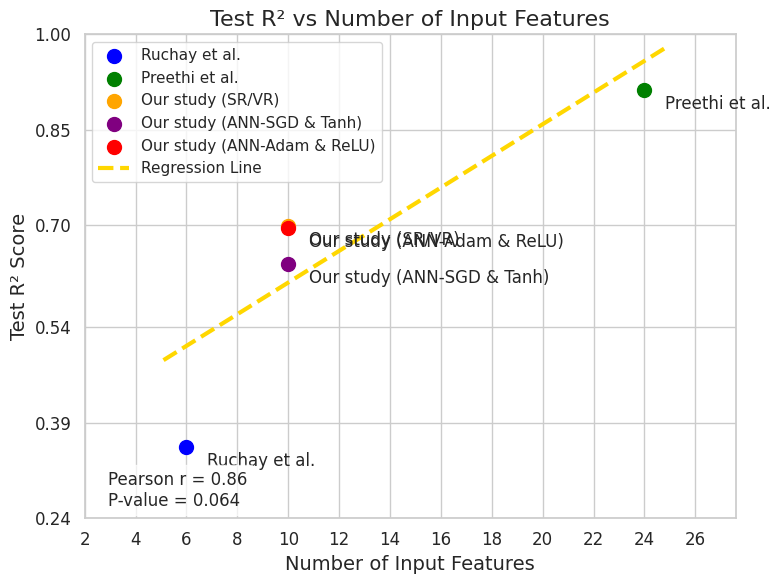

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, linregress

# Data from the table
studies = [
    "Ruchay et al.",
    "Preethi et al.",
    "Our study (SR/VR)",
    "Our study (ANN-SGD & Tanh)",
    "Our study (ANN-Adam & ReLU)"
]
input_features = [6, 24, 10, 10, 10]
test_r2 = [0.352, 0.913, 0.699, 0.639, 0.696]
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Calculate Pearson correlation and regression line
correlation, p_value = pearsonr(input_features, test_r2)
slope, intercept, r_value, p_slope, stderr = linregress(input_features, test_r2)

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = plt.gca()

# Scatter plot with custom colors
for i in range(len(studies)):
    ax.scatter(input_features[i], test_r2[i], s=100, label=studies[i], color=colors[i])

# Plot regression line with thickness
x_vals = np.array(ax.get_xlim())
y_vals = intercept + slope * x_vals
ax.plot(x_vals, y_vals, '--', color='gold', linewidth=3, label='Regression Line')

# Annotate points with offset for better visibility
for i, txt in enumerate(studies):
    ax.annotate(txt, (input_features[i] + 0.8, test_r2[i] - 0.03), fontsize=12)

# Adjust axis limits with padding
x_min, x_max = min(input_features), max(input_features)
y_min, y_max = min(test_r2), max(test_r2)

x_padding = (x_max - x_min) * 0.2  # 20% padding
y_padding = (y_max - y_min) * 0.2

ax.set_xlim(x_min - x_padding, x_max + x_padding)
ax.set_ylim(max(0, y_min - y_padding), min(1, y_max + y_padding))  # R² between 0 and 1

# Improve ticks
ax.xaxis.set_ticks(np.arange(int(x_min - x_padding), int(x_max + x_padding) + 1, 2))
ax.yaxis.set_ticks(np.round(np.linspace(max(0, y_min - y_padding), min(1, y_max + y_padding), 6), 2))

# Titles and labels
plt.title("Test R² vs Number of Input Features", fontsize=16)
plt.xlabel("Number of Input Features", fontsize=14)
plt.ylabel("Test R² Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()

# Display correlation stats
plt.text(x_min - x_padding + 0.5, y_min - y_padding + 0.02,
         f"Pearson r = {correlation:.2f}\nP-value = {p_value:.3f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.show()